In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import numpy as np
import torch
import random
import torch.backends.cudnn as cudnn

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # slightly slower but reproducible

set_seed(24)

In [3]:
!pip install --upgrade datasets fsspec


  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.1 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.12.0
    Uninstalling fsspec-2024.12.0:
      Successfully uninstalled fsspec-2024.12.0
  Attempting uninstall: datasets
    Found existing installation: datasets 3.5.0
    Uninstalling datasets-3.5.0:
      Successfully uninstalled datasets-3.5.0

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# EDA

# Dataset overview

In [4]:
# Install the `datasets` library if it's not already installed

from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})

## Checking missing values

In [6]:
def check_missing(dataset_split):
    missing_counts = {}
    for feature in dataset_split.features:
        count = sum(1 for example in dataset_split if example[feature] is None)
        missing_counts[feature] = count
    return missing_counts

for split in dataset:
    print(f"\nMissing values in {split}:")
    print(check_missing(dataset[split]))



Missing values in train:
{'tokens': 0, 'pos_tags': 0, 'ner_tags': 0}

Missing values in test:
{'tokens': 0, 'pos_tags': 0, 'ner_tags': 0}

Missing values in validation:
{'tokens': 0, 'pos_tags': 0, 'ner_tags': 0}


In [7]:
#Get the total number of sentences in each split
print("\nNumber of Sentences in Each Split:")
for split in dataset.keys():
    print(f"{split.capitalize()} Split: {len(dataset[split])} sentences")


Number of Sentences in Each Split:
Train Split: 2000 sentences
Test Split: 250 sentences
Validation Split: 150 sentences


## Token and tag distributions

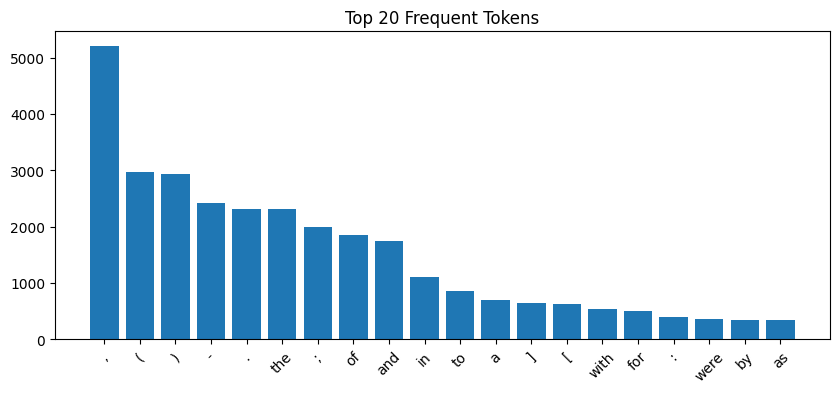

In [8]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten all tokens from train split and convert to lowercase
all_tokens = [token.lower() for example in dataset['train'] for token in example['tokens']]
token_freq = Counter(all_tokens)
top_tokens = token_freq.most_common(20)

# Plot top 20 most frequent tokens
words, freqs = zip(*top_tokens)
plt.figure(figsize=(10,4))
plt.bar(words, freqs)
plt.xticks(rotation=45)
plt.title("Top 20 Frequent Tokens")
plt.show()

Key insights:
1. Punctuation (',', '(', ')', '.') and stopwords ("the", "of", "and") are the most frequent tokens.

2. Biomedical terms or abbreviations are not visible in the top 20.

3. Suggests that non-entity tokens dominate the dataset, highlighting the importance of focusing on labeled tokens for biomedical analysis.

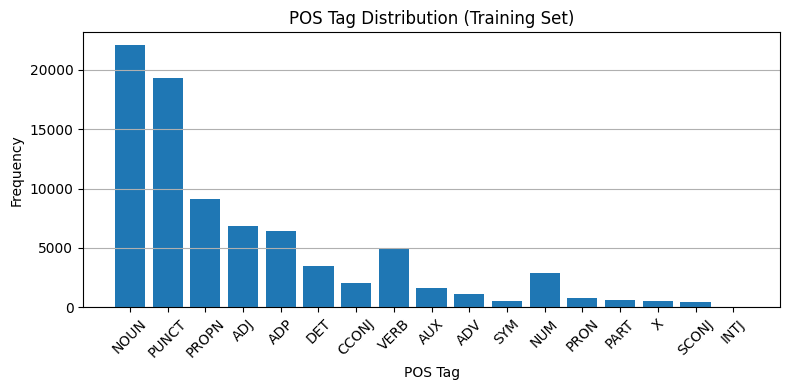

In [9]:
from collections import Counter

all_pos = [pos for sentence in dataset['train']['pos_tags'] for pos in sentence]
pos_counts = Counter(all_pos)

plt.figure(figsize=(8, 4))
plt.bar(pos_counts.keys(), pos_counts.values())
plt.title("POS Tag Distribution (Training Set)")
plt.xlabel("POS Tag")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Key insights:

1. NOUN and PUNCT are the most frequent POS tags, followed by proper nouns (PROPN) and adjectives (ADJ).

2. Indicates that biomedical terms likely appear as nouns or proper nouns, with heavy punctuation usage (typical of scientific text).

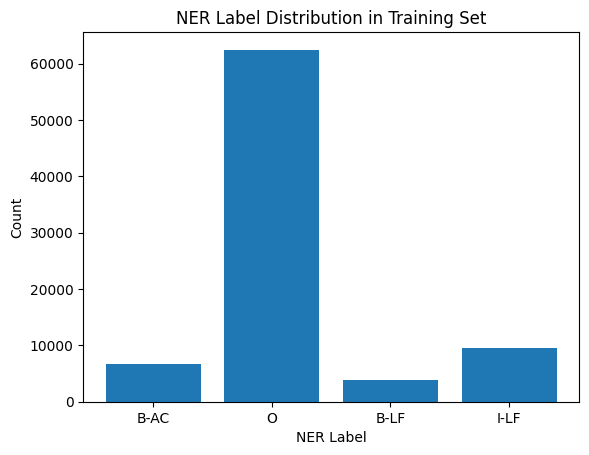

In [10]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten all NER tags from the training set
all_ner_labels = [label for ex in dataset['train'] for label in ex['ner_tags']]

# Count the frequency of each NER tag
label_counts = Counter(all_ner_labels)

# Plot the distribution
plt.bar(label_counts.keys(), label_counts.values())
plt.title("NER Label Distribution in Training Set")
plt.xlabel("NER Label")
plt.ylabel("Count")
plt.show()

Key insights

1. Majority of tokens are labeled as O (non-entity).

2. Among labeled tokens, I-LF (inside long-form) is the most common, followed by B-AC (abbreviation) and B-LF (begin long-form).

3. Shows class imbalance, with many more non-entity tokens than labeled entities — important for model training and evaluation.

## Word frequency (excluding O)

[('of', 217), ('protein', 137), ('and', 101), ('ratio', 83), ('cell', 82), ('disease', 82), ('the', 74), ('type', 69), ('receptor', 62), ('CI', 61), ('RNA', 56), ('for', 55), ('mass', 51), ('factor', 50), ('index', 49), ('interval', 48), ('WT', 47), ('rate', 46), ('acid', 46), ('confidence', 45)]


<BarContainer object of 20 artists>

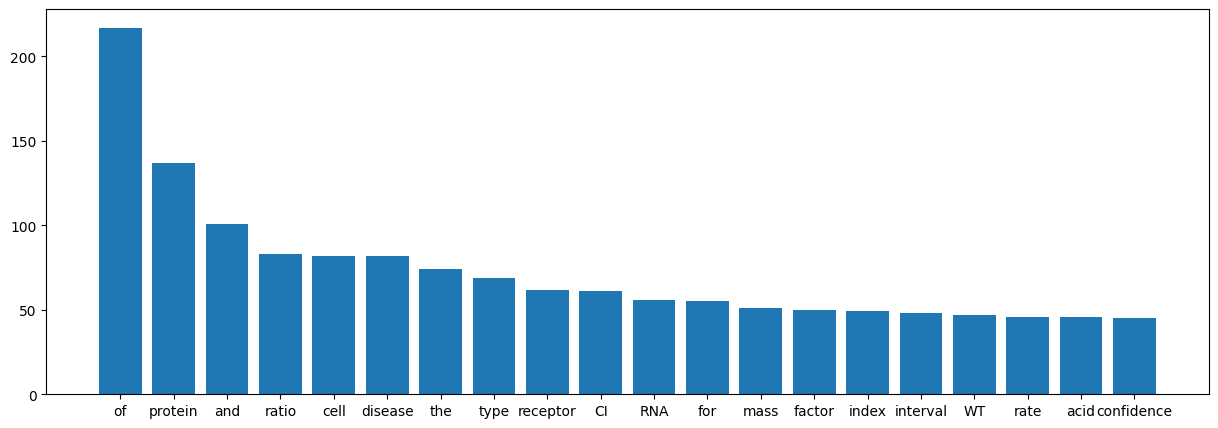

In [11]:

from collections import Counter
import matplotlib.pyplot as plt

tokens = []

for row in dataset['train']:
  for token, tag in zip(row['tokens'], row['ner_tags']):
    if tag != 'O' and len(token) > 1:
      tokens.append(token)

token_freq = Counter(tokens)
top_tokens = token_freq.most_common(20)
print(top_tokens)

words, freqs = zip(*top_tokens)
plt.figure(figsize=(15,5))
plt.bar(words, freqs)

Key insights:

1.Generic words like “of”, “and”, and “the” still appear frequently even in labeled tokens, suggesting that some long-forms may contain common English words.

2. Domain-specific terms such as “protein”, “cell”, “disease”, “ratio”, “receptor”, and “RNA” are among the top frequent labeled tokens, reflecting the biomedical nature of the dataset.

3. Some abbreviations like “CI”, “WT”, and “RNA” appear, indicating that abbreviation labels (B-AC) are being captured in the top frequencies.

4. The presence of common functional words in the labeled tokens highlights that biomedical entities often contain stopwords (e.g., "confidence interval", "protein of interest").

## Top abbreviated words

In [12]:
# TODO: SHOW TOP ABBRIVIATED WORDS -> shivasmi
from collections import Counter
import matplotlib.pyplot as plt
import re

abbreviation_counts = Counter()

# Working only on the train split
for example in dataset["train"]:
    tokens = example['tokens']
    tags = example['ner_tags']

    for token, tag in zip(tokens, tags):
        # Allow letters (A-Z, a-z), numbers (0-9), and hyphens (-), length > 1
        if tag == "B-AC" and re.match(r"^[A-Za-z0-9\-]+$", token) and len(token) > 1:
            abbreviation_counts[token] += 1

# Show Top 10 Abbreviated Words after filtering
print("\nTop Abbreviated Words:")
for abbr, count in abbreviation_counts.most_common(10):
    print(f"{abbr:<10} → {count}")


Top Abbreviated Words:
CI         → 61
WT         → 47
HR         → 40
OR         → 40
BMI        → 39
GFP        → 39
TB         → 31
SD         → 28
MS         → 24
KO         → 20


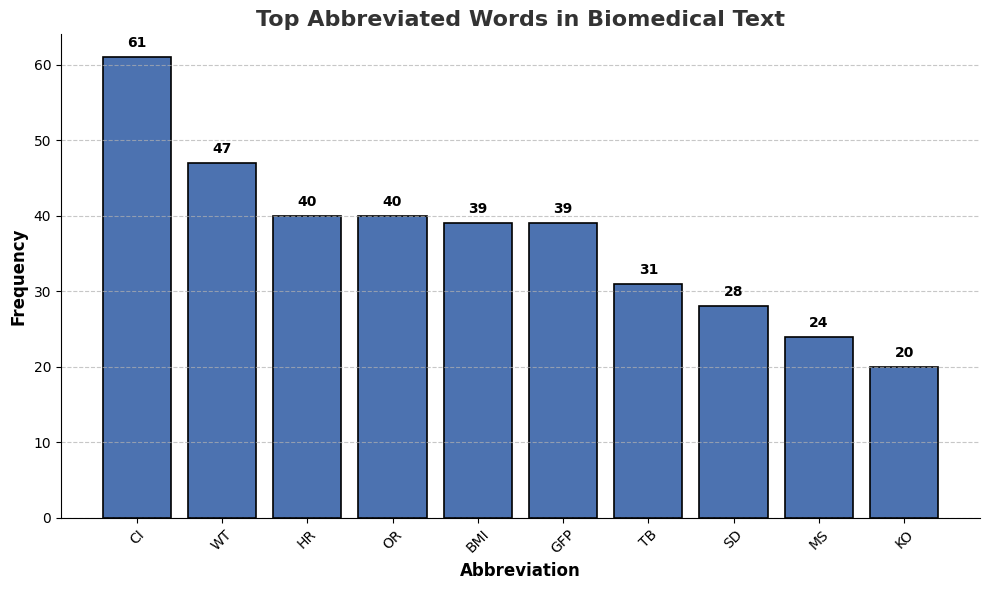

In [13]:
# Get the top 10 abbreviations and their counts
top_abbr, top_counts = zip(*abbreviation_counts.most_common(10))

# Plotting with better style
plt.figure(figsize=(10, 6))
bars = plt.bar(top_abbr, top_counts, color='#4c72b0', edgecolor='black', linewidth=1.2)

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset label position
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Customizing the plot
plt.title("Top Abbreviated Words in Biomedical Text", fontsize=16, fontweight='bold', color='#333333')
plt.xlabel("Abbreviation", fontsize=12, fontweight='bold')
plt.ylabel("Frequency", fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Key insights:

1. “CI” and “WT” are the most frequent abbreviations, followed by “HR”, “OR”, and “BMI”.

2. Abbreviations reflect a mix of statistical terms (e.g., CI, HR, OR) and biomedical entities/diseases (e.g., GFP, TB, MS).

  Indicates the need for domain-aware abbreviation handling in the model.

## Long form & abbreviation relationship

Tokens: ['MRR', ',', 'mortality', 'rate', 'ratio', ';', 'TBI', ',', 'traumatic', 'brain', 'injury', '.']
NER Tags: ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']
---
Tokens: ['HPC', ',', 'hippocampus', ';', 'mOFC', ',', 'medial', 'OFC', ';', 'OFC', ',', 'orbitofrontal', 'cortex', ';', 'PPI', ',', 'psychophysiological', 'interaction', '.']
NER Tags: ['B-AC', 'O', 'B-LF', 'O', 'O', 'O', 'O', 'B-AC', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'O']
---
Tokens: ['In', 'addition', 'to', 'the', 'effects', 'on', 'cell', 'growth', 'and', 'migration', ',', 'the', '18β', '-', 'GA', '-', 'd', 'used', 'in', 'this', 'study', 'could', 'also', 'up', '-', 'regulate', 'expression', 'of', 'aquaporin-3', '(', 'AQP-3', ')', 'in', 'fibroblasts', 'and', 'keratinocytes', '.']
NER Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'B-AC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LF', 

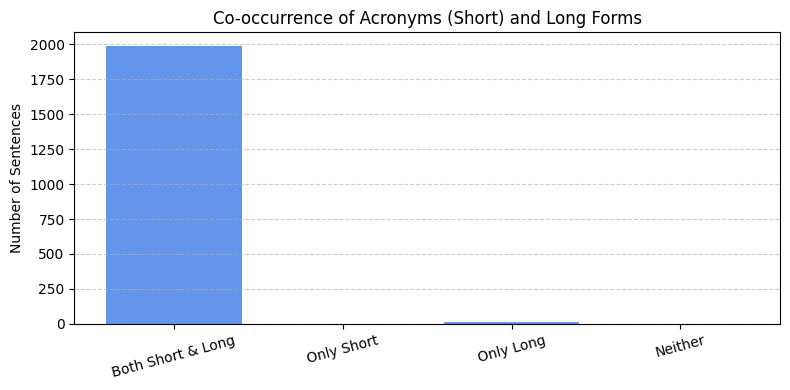

In [14]:

# examples where acronym (B-AC) appears
for i in range(5):
    tags = dataset['train'][i]['ner_tags']
    if 'B-AC' in tags:
        print("Tokens:", dataset['train'][i]['tokens'])
        print("NER Tags:", tags)
        print("---")

# Initializing counters
with_both = 0
only_acronym = 0
only_longform = 0
neither = 0

# Going through each sentence in the training set
for ex in dataset['train']:
    tags = ex['ner_tags']

    has_acronym = 'B-AC' in tags
    has_longform = 'B-LF' in tags or 'I-LF' in tags

    if has_acronym and has_longform:
        with_both += 1
    elif has_acronym:
        only_acronym += 1
    elif has_longform:
        only_longform += 1
    else:
        neither += 1

print("Sentences with BOTH acronym and long form:", with_both)
print("Sentences with ONLY acronym:", only_acronym)
print("Sentences with ONLY long form:", only_longform)
print("Sentences with NEITHER:", neither)
print('\n')

#Visualizing with Bar Chart
import matplotlib.pyplot as plt

labels = ['Both Short & Long', 'Only Short', 'Only Long', 'Neither']
counts = [with_both, only_acronym, only_longform, neither]

plt.figure(figsize=(8, 4))
plt.bar(labels, counts, color='cornflowerblue')
plt.title("Co-occurrence of Acronyms (Short) and Long Forms")
plt.ylabel("Number of Sentences")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Key Insights:

1. Most sentences (1986) contain both abbreviations and their corresponding long forms, indicating clear abbreviation–long-form pairings.

2. Very few sentences have only abbreviations (2) or only long forms (12), showing that isolated occurrences are rare.

3. No sentences are unlabeled (neither abbreviation nor long form), confirming the dataset is well-annotated.

4. Highlights that sentence-level context is strong for abbreviation detection, as both forms often co-occur together.

## Sentences with only abbreviations or only long forms

In [15]:
# TODO: Sentences with Only Abbreviations or Only Long-forms -> ritwik

print("\nSentences with only abbreviation (B-AC, no B-LF):\n")
count = 0
for ex in dataset["train"]:
    tags = ex["ner_tags"]
    if "B-AC" in tags and "B-LF" not in tags:
        print(" ".join(ex["tokens"]))
        count += 1
        if count >= 3:
            break


Sentences with only abbreviation (B-AC, no B-LF):

These results were consistent with the ability of CD5 - 2 to inhibit neutrophil migration into inflamed tissue in the MC38 colon carcinoma , in which CD5 - 2 inhibited the number of CD11b+/granulocyte ( Gr)1hi in the solid tumor tissue .
Macrophages were pretreated with buffer , neutralizing antibodies against TLR2 ( 1 μg / ml ) , TAPI ( 10 μg / ml ) , Bay ( 100 μM ) , PD98059 ( 20 μM ) , or SB203580 ( 10 μM ) for 30 min , and stimulated for 2 h with eRNA ( 10 μg / ml)/Pam2CSK4 ( Pam , 0.1 ng / ml ) , which were preincubated for 1 h at 37 ° C .


Key Insight:
1. Some short forms like CD5-2, TLR2, PD98059, eRNA, etc. are used without explaining their full forms in the same sentence.

In [16]:
print("\nSentences with only long-form (B-LF, no B-AC):\n")
count = 0
for ex in dataset["train"]:
    tags = ex["ner_tags"]
    if "B-LF" in tags and "B-AC" not in tags:
        print(" ".join(ex["tokens"]))
        count += 1
        if count >= 12:
            break


Sentences with only long-form (B-LF, no B-AC):

SCO - spondin - like
topoisomerase I - activated pCR2.1 - TOPO vector
2D HeLa dataset
Therefore , the aim of this study was to research the antitumor effects of the ginsenoside Rk3 on esophageal cancer cell lines and to investigate the potential molecular mechanisms by which it activates apoptosis and autophagy both in vitro and in vivo .
synthetic UniSp6 RNA spike - in
The World Health Organization ( WHO ) provides information ( in several languages ) on all aspects of tuberculosis , including general information on tuberculosis diagnostics and specific information on the roll out of the Xpert MTB / RIF test ; further information about WHO 's endorsement of Xpert MTB / RIF is included in a Strategic and Technical Advisory Group for Tuberculosis report ; the Global Tuberculosis Report 2013 provides information about tuberculosis around the world , including in India
Following phosphorylation of the scaffold protein LAT by activated ZAP70

Key insights:

1. Some technical terms like “chaperone protein DnaK” or “Plasmodium falciparum strain FCR3” are written fully without abbreviation.

2. This happens when:

  -The term is used only once.
  -The term itself is already short or clear.

## Abbreviation ↔ POS Tag Relationship

In [17]:
# TODO: RELATION BETWEEN ABBRIVIATION AND POS TAG -> faye

import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# initialise a dictionary to store abbreviation-POS pairs
abbr_pos_counts = defaultdict(lambda: defaultdict(int))

# iterate through the dataset to find abbreviations and their POS tags
for split in ['train', 'validation', 'test']:
    for example in dataset[split]:
        tokens = example['tokens']
        pos_tags = example['pos_tags']

        for token, pos_tag in zip(tokens, pos_tags):
            # check if the token is likely an abbreviation (heuristic: contains '.' or is uppercase)
            if '.' in token or (token.isupper() and len(token) <= 5):
                abbr_pos_counts[token][pos_tag] += 1

# convert to a dataframe for analysis
abbr_pos_df = pd.DataFrame([
    (abbr, pos, count)
    for abbr in abbr_pos_counts
    for pos, count in abbr_pos_counts[abbr].items()
], columns=['Abbreviation', 'POS_Tag', 'Count'])

# display the top abbreviation POS pairs
print(abbr_pos_df.sort_values('Count', ascending=False).head(20))

    Abbreviation POS_Tag  Count
2              .   PUNCT   2762
13             C    NOUN     97
34           RNA    NOUN     96
102           CI    NOUN     92
14             C   PROPN     58
19            WT   PROPN     56
510            N    NOUN     53
49             A    NOUN     50
54             B    NOUN     48
934          HIV   PROPN     46
383          GFP   PROPN     45
388          PCR    NOUN     44
57             D    NOUN     44
27           DNA    NOUN     41
251           S1   PROPN     41
292           SD    NOUN     39
99            HR    NOUN     39
52             A   PROPN     36
242          BMI   PROPN     35
84             T   PROPN     35


/var/folders/t3/spmbj0b13fn7ykhmtf9d6tm80000gn/T/ipykernel_72054/2570323734.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_counts, x='POS_Tag', y='Count', palette='viridis')


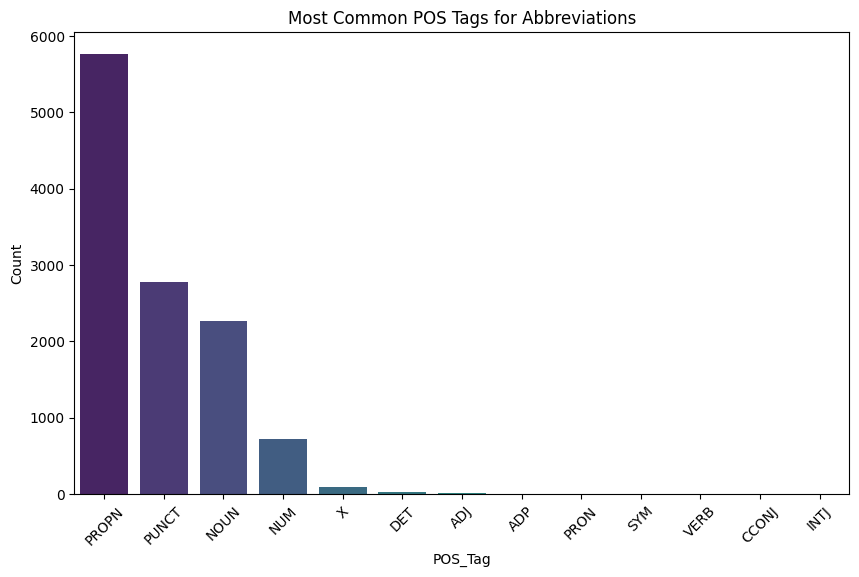

In [ ]:
# aggregate counts by POS tag
pos_counts = abbr_pos_df.groupby('POS_Tag')['Count'].sum().reset_index()
pos_counts = pos_counts.sort_values('Cohlunt', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=pos_counts, x='POS_Tag', y='Count', palette='viridis')
plt.title('Most Common POS Tags for Abbreviations')
plt.xticks(rotation=45)
plt.show()

Key insights:
1. Most abbreviations are tagged as Proper Nouns (PROPN) and Nouns (NOUN), matching common biomedical entities like genes, proteins, and diseases.

2. High PUNCT count suggests tokenization splits (e.g., hyphens in "IL-2") leading to punctuation being misclassified as abbreviations.

3. Presence of NUM (numbers) reflects abbreviations with numeric components (e.g., S1, 2).

## Tag transition matrix (NER transitions)

In [19]:

import pandas as pd
from collections import Counter

def get_all_transitions(dataset_split):
    transitions = Counter()
    for example in dataset_split:
        labels = example['ner_tags']
        for i in range(len(labels) - 1):
            transitions[(labels[i], labels[i + 1])] += 1
    return transitions

def transitions_to_dataframe(transitions):
    data = []
    for (prev_tag, next_tag), count in transitions.items():
        data.append({
            'Previous Tag': prev_tag,
            'Next Tag': next_tag,
            'Count': count
        })
    df = pd.DataFrame(data)
    return df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Get transitions
train_transitions = get_all_transitions(dataset['train'])

# Convert to DataFrame (no id2label needed!)
df_transitions = transitions_to_dataframe(train_transitions)
print(df_transitions)

   Previous Tag Next Tag  Count
0             O        O  51509
1          I-LF     I-LF   5946
2          B-AC        O   5754
3             O     B-AC   5311
4             O     B-LF   3718
5          B-LF     I-LF   3579
6          I-LF        O   3502
7          B-AC     B-AC    828
8          B-LF        O    338
9          B-AC     B-LF     42
10         I-LF     B-AC     15
11         I-LF     B-LF      5
12         B-LF     B-AC      1


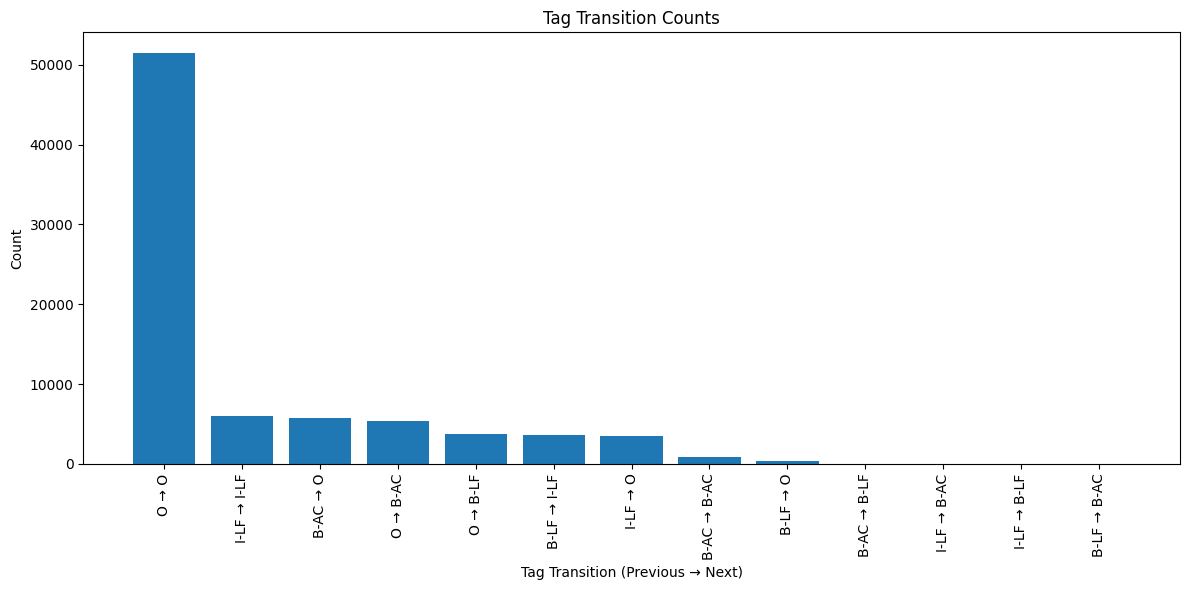

In [20]:
import matplotlib.pyplot as plt

# Prepare labels and counts
labels = df_transitions.apply(lambda x: f"{x['Previous Tag']} → {x['Next Tag']}", axis=1)
counts = df_transitions["Count"]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(labels, counts)

# Set labels and title
ax.set_ylabel("Count")
ax.set_xlabel("Tag Transition (Previous → Next)")
ax.set_title("Tag Transition Counts")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Remove grid
ax.grid(False)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

A. Rare transitions: Transition Count What it may indicate

1. B-AC → B-LF 42; Abbreviation followed immediately by long form
2. I-LF → B-AC 15; Ending long form → new abbreviation without 'O' token between
3. I-LF → B-LF 5; One long form starts right after inside of another long form
4. B-LF → B-AC 1; Very rare: long form followed by abbreviation

B. The majority of transitions are from

1. O → O, reflecting a strong class imbalance toward non-entity tokens.
2. Long forms typically span multiple tokens as shown by frequent B-LF → I-LF and I-LF → I-LF transitions.

Rare transitions such as B-AC → B-LF suggest edge cases where abbreviations are directly followed by long forms, which may challenge sequence-based models.

## Symbols and token analysis

[('α', 40), ('β', 33), ('γ', 9), ('TGFβ', 6), ('β2', 5), ('Aβ', 5), ('PDGFRα', 4), ('PLCγ', 3), ('ω-1', 3), ('αSMA', 2), ('ERα', 2), ('ΔVRC', 2), ('ΔMaml1', 2), ('TGFβ1', 2), ('PGC-1α', 2), ('Δchanges', 2), ('18β', 1), ('αIPM', 1), ('med23Δli', 1), ('Δm157', 1)]


<BarContainer object of 20 artists>

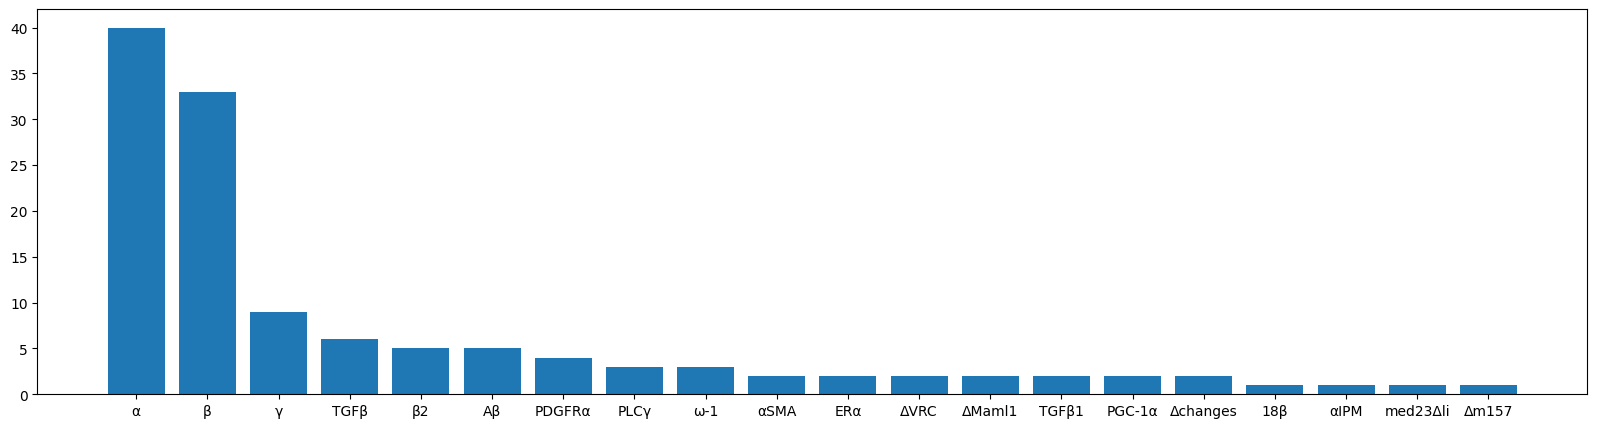

In [21]:
# TODO: SHOW THE SYMBOLS -> amir
from collections import Counter
import matplotlib.pyplot as plt
import re

uncommon_pattern = re.compile(r'[αβγδΔΓΩω]')
tokens = []

for row in dataset['train']:
  for token, tag in zip(row['tokens'], row['ner_tags']):
    if uncommon_pattern.search(token):
      tokens.append(token)

token_freq = Counter(tokens)
top_tokens = token_freq.most_common(20)
print(top_tokens)

words, freqs = zip(*top_tokens)
plt.figure(figsize=(20,5))
plt.bar(words, freqs)


Key insights:
1. Greek letters like α (alpha), β (beta), γ (gamma) are the most frequently occurring symbols in biomedical terms.

2. These symbols are often used in protein names, receptor types, or biological pathways (e.g., TGFβ, Aβ, PDGFRα).

3. The presence of such symbols highlights the importance of correctly handling non-English characters during tokenization and abbreviation detection.

4. Rare symbols like ω (omega), Δ (delta), and their combinations (e.g., Δm157, αSMA) also appear, often representing variants or specific subtypes.

## Abbreviation ambiguity

In [22]:
# TODO: Abbreviation amibiguity check - ritwik

from collections import defaultdict

abbr_map = defaultdict(set)

for example in dataset['train']:
    tokens = example['tokens']
    tags = example['ner_tags']
    current_abbr = None
    current_lf = []

    for token, tag in zip(tokens, tags):
        if tag == 'B-AC':
            current_abbr = token
        elif tag == 'B-LF':
            current_lf = [token]
        elif tag == 'I-LF' and current_lf:
            current_lf.append(token)
        elif tag == 'O':
            if current_abbr and current_lf:
                abbr_map[current_abbr].add(" ".join(current_lf))
                current_abbr = None
                current_lf = []

# Count ambiguous abbreviations
ambiguous_abbr = {abbr: lfs for abbr, lfs in abbr_map.items() if len(lfs) > 1}
num_ambiguous = len(ambiguous_abbr)

print(f"\n Total Ambiguous Abbreviations: {num_ambiguous}")
print("\nSome Examples of Ambiguous Abbreviations:")

# Show abbreviations with more than one long form
for abbr, lfs in list(ambiguous_abbr.items())[:10]:
    if len(lfs) > 1:
        print(f"{abbr} → {lfs}")


 Total Ambiguous Abbreviations: 437

Some Examples of Ambiguous Abbreviations:
d → {'LV anterior wall thickness at end - diastole', 'LV posterior wall thickness at end - diastole', 'aquaporin-3', 'LV internal diameter at end - diastole'}
HC → {'healthy control', 'C - terminal receptor - binding domain', 'Resident Assessment Instrument for Home Care', 'healthy control participants'}
KD → {'glutathione compound glutathione reduced ethyl ester', 'knockdown', 'equilibrium dissociation constants', 'kinase - inactive mutant', 'knock - down', 'reactive oxygen species', 'equilibrium dissociation constant'}
ND → {'nanodisc', 'nandrolone decanoate'}
AMPK → {'double - stranded RNA', 'AMP - activated protein kinase', 'FOrkhead boX O'}
HbA1c → {'haemoglobin A1c', 'glycated hemoglobin', 'hemoglobin A1c', 'high - density lipoprotein', 'Glycated Hemoglobin', 'glycated haemoglobin'}
IR → {'homeostatic model assessment of insulin resistance', 'insulin resistance', 'incidence rate', 'homeostasis model a

Key insights:

1. total of 437 ambiguous abbreviations were identified, meaning these abbreviations map to more than one possible long-form.

2. Examples like:

  -"KD" → knockdown, kinase - inactive mutant, equilibrium dissociation constant, etc.

  -"TLR" → toll-like receptor, non-ulcer dyspepsia
show how the same abbreviation can represent completely different biomedical terms.

3. Some abbreviations like "d", "HC", and "ND" map to 5 or more long-forms, increasing the risk of confusion for models.

# EXPERIMENT 1

## Split the Dataset into Train, Test, and Validation

We assign the different splits of the PLOD-CW-25 dataset to separate variables for better handling.

In [23]:
train_data = dataset['train']
test_data = dataset['test']
validate_data = dataset['validation']

## pre processing

In [24]:
all_tokens = set([token for sent in train_data['tokens'] for token in sent])
ner_tags = set([tag for sent in train_data['ner_tags'] for tag in sent])

## Build Vocabulary from Training Tokens

We extract all tokens from all training sentences and flatten them into a single list for frequency counting. This allows us to build a vocabulary where each unique token is assigned a unique index. Special tokens like `<PAD>` and `<UNK>` are also added for padding and unknown words.

In [25]:
from collections import Counter

tokens_train = [ex['tokens'] for ex in dataset['train']]

word_counter = Counter(token for sent in tokens_train for token in sent)

# Assign unique indices
word_vocab = {token: idx + 2 for idx, (token, _) in enumerate(word_counter.items())}
# equivilent to: token to id
word_vocab['<PAD>'] = 0
word_vocab['<UNK>'] = 1

## Functions to Convert Tokens and Tags to IDs (and vice versa)

These helper functions handle converting tokens and tags to their index values using lookup dictionaries. They also deal with unknown tokens or IDs by falling back to special defaults like `<UNK>` or `'O'`.

In [26]:
def token_to_id_fn(token, token_to_id):
    return token_to_id.get(token, token_to_id['<UNK>'])

def id_to_token_fn(idx, id_to_token):
    return id_to_token.get(idx, '<UNK>')

def tag_to_id_fn(tag, tag_to_id):
    return tag_to_id[tag]

def id_to_tag_fn(idx, id_to_tag):
    return id_to_tag.get(idx, 'O')

## Convert Tokens and Tags to Their Corresponding IDs

This function takes each example in the dataset and replaces the tokens and NER tags with their corresponding integer IDs using the vocab dictionaries.

In [27]:
def map_dataset(dataset, token_to_id, tag_to_id):
  mapped_dataset = []
  for row in dataset:
    tokens = row['tokens']
    ner_tags = row['ner_tags']
    mapped_tokens = [token_to_id.get(token, token_to_id['<UNK>']) for token in tokens]
    mapped_ner_tags = [tag_to_id[tag] for tag in ner_tags]
    mapped_dataset.append({
        'tokens': mapped_tokens,
        'ner_tags': mapped_ner_tags
    })
  return mapped_dataset

In [28]:
tag_to_id = {
    'O': 0,
    'B-LF': 1,
    'I-LF': 2,
    'B-AC': 3
}

## Convert Dataset Splits to ID Format

We apply the mapping function to the train, test, and validation splits to convert all tokens and tags to their corresponding integer IDs using the vocab dictionaries. This prepares the data for model input.

In [29]:
mapped_train_data = map_dataset(train_data, word_vocab, tag_to_id)
mapped_test_data = map_dataset(test_data, word_vocab, tag_to_id)
mapped_validate_data = map_dataset(validate_data, word_vocab, tag_to_id)

## Visualize Sentence Lengths in Training Data

We plot the distribution of token counts per sentence in the training data to understand length variability. The 99th percentile is marked to help decide a reasonable maximum sequence length for padding.


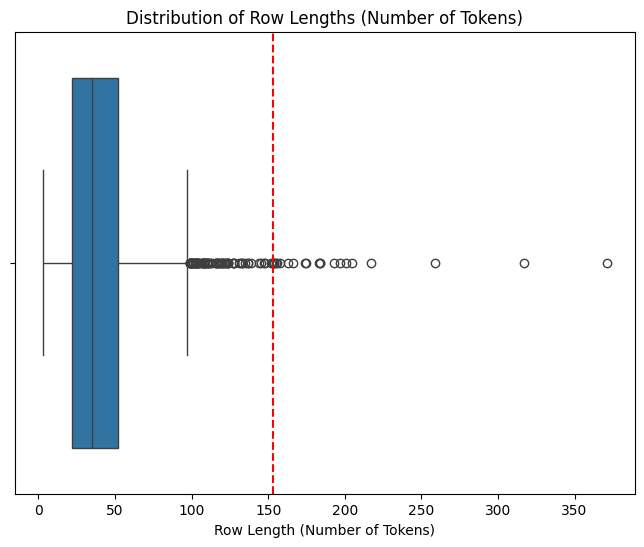

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

row_lengths = [len(sent['tokens']) for sent in mapped_train_data]


percentile = np.percentile(row_lengths, 99)
plt.figure(figsize=(8, 6))
sns.boxplot(x=row_lengths)
plt.axvline(x=np.percentile(row_lengths, 99), color='red', linestyle='--', label='99th Percentile')
plt.title("Distribution of Row Lengths (Number of Tokens)")
plt.xlabel("Row Length (Number of Tokens)")
plt.show()

## Plot Summary

*   The boxplot shows that most sentences are relatively short, with the majority falling well below 100 tokens.
*   A few outliers go beyond 150 tokens.
*   The red dashed line marks the 99th percentile, which is around 150 tokens.
*   This means we can safely set the maximum sequence length to 150, covering nearly all sentences while limiting the impact of unusually long ones.

## Pad and Truncate Dataset to a Fixed Length

We set a maximum sequence length of 150 based on the earlier analysis. This function goes through each example and either truncates or pads the tokens and tags to match this length. It also creates a mask to distinguish real tokens from padding.


In [31]:
MAX_LENGTH = 150

def pad_dataset(dataset, max_length):
    padded_dataset = []
    for row in dataset:
        tokens = row['tokens']
        ner_tags = row['ner_tags']
        if len(tokens) > max_length:
            tokens = tokens[:max_length]
            ner_tags = ner_tags[:max_length]

        else:
            tokens += [0] * (max_length - len(tokens))
            ner_tags += [0] * (max_length - len(ner_tags))

        mask = [1 if token != 0 else 0 for token in tokens]

        padded_dataset.append({
            'tokens': tokens,
            'ner_tags': ner_tags,
            'mask': mask
        })

    return padded_dataset

## Apply Padding and Truncation to All Dataset Splits

We now apply the padding function to the train, test, and validation sets. Each example is padded or truncated to the same fixed length and a corresponding mask is added to indicate real tokens vs. padding.


In [32]:
padded_train_data = pad_dataset(mapped_train_data, MAX_LENGTH)
padded_test_data = pad_dataset(mapped_test_data, MAX_LENGTH)
padded_validate_data = pad_dataset(mapped_validate_data, MAX_LENGTH)

## Set Vocabulary Size and Embedding Dimension

In [33]:
VOCAB_SIZE = len(word_vocab)
DIM = 100

## Download Bio Embedding File (If Not Already Present)
This code checks if the file bio_embedding_extrinsic is already present in the working directory.
If not, it downloads the file from Figshare using the provided URL.

In [34]:
import os
import urllib.request

file_name = 'bio_embedding_extrinsic'
download_url = 'https://figshare.com/ndownloader/files/12551780'

if os.path.exists(file_name):
    print(f"File {file_name} already exists. Skipping download.")
else:
    print(f"Downloading {file_name} from {download_url}...")
    urllib.request.urlretrieve(download_url, file_name)
    print(f"Downloaded {file_name}.")

File bio_embedding_extrinsic already exists. Skipping download.


# Embedding

### Embeddings Used

We used **pretrained biomedical word embeddings** from:

> **Zhang et al. (2019)** — *Improving Biomedical Word Embeddings with Subword Information and MeSH Ontology*  
> Available via [Figshare](https://figshare.com/articles/dataset/BioWordVec_Improving_Biomedical_Word_Embeddings_with_Subword_Information_and_MeSH_Ontology/6885640)

These embeddings, commonly known as **BioWordVec**, are trained on **PubMed abstracts** and incorporate:
- **Subword information** via FastText-style modeling
- **MeSH ontology knowledge** to enhance domain-specific semantics

Their design makes them highly suitable for **biomedical NLP tasks** such as **Named Entity Recognition (NER)**, where vocabulary can be complex, domain-specific, and morphologically rich.


In [35]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_path = "bio_embedding_extrinsic"
w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

### Verify Loaded Word2Vec Model

We confirm that the pretrained Word2Vec model has loaded successfully by printing the embedding dimensionality and vocabulary size.


In [36]:
# checking vector size
print(f"Embedding vector size: {w2v_model.vector_size}")

# checking vocabulary size
print(f"Vocabulary size: {len(w2v_model.key_to_index)} words")

Embedding vector size: 200
Vocabulary size: 2324849 words


### Create Embedding Matrix with Pretrained Word2Vec Vectors

In [37]:
import numpy as np

# setting up embedding matrix
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((len(word_vocab), embedding_dim))


# fill the matrix
for word, idx in word_vocab.items():
    if word in w2v_model:
        embedding_matrix[idx] = w2v_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

### Verify Embedding Matrix

We verify that the embedding matrix has the correct shape, check how many words from our dataset are covered by the pretrained Word2Vec model, and inspect the embedding for a sample word.

In [38]:
# 1. Check dimensions
print(f"Embedding matrix shape: {embedding_matrix.shape}")
assert embedding_matrix.shape[0] == len(word_vocab), "Mismatch in vocab size!"
assert embedding_matrix.shape[1] == w2v_model.vector_size, "Mismatch in embedding dim!"

# 2. Check OOV (out of vocab) words
covered = sum(1 for word in word_vocab if word in w2v_model)
total = len(word_vocab)
print(f"Coverage: {covered}/{total} words ({covered/total*100:.2f}%)")

# 3. Sample vector check
sample_word = 'glucose'
if sample_word in word_vocab:
    idx = word_vocab[sample_word]
    print(f"Sample vector for '{sample_word}': {embedding_matrix[idx][:10]}")
else:
    print(f"'{sample_word}' not found in word_vocab")

Embedding matrix shape: (14742, 200)
Coverage: 7463/14742 words (50.62%)
Sample vector for 'glucose': [ 0.30148456  0.06259853  0.06257256  0.02667626 -0.30542654  0.30082998
 -0.14734118 -0.20231321  0.28477651 -0.29688197]


### List Out OOV (Out-of-Vocabulary) Words

In [39]:
# List out OOV words
oov_words = [word for word in word_vocab if word not in w2v_model]

# Show a few (first 20)
print(f"Total OOV words: {len(oov_words)} / {len(word_vocab)}")
print("Sample OOV words:")
for i, word in enumerate(oov_words[:20]):
    print(f"{i+1:2d}. {word}")

Total OOV words: 7279 / 14742
Sample OOV words:
 1. MRR
 2. ,
 3. ;
 4. TBI
 5. .
 6. HPC
 7. mOFC
 8. OFC
 9. PPI
10. In
11. 18β
12. GA
13. (
14. AQP-3
15. )
16. Abbreviations
17. :
18. HC
19. C
20. KD


### Analyze Frequency of OOV Words

In [40]:
# Assuming you have a `word_counter` (e.g., from collections.Counter)
from collections import Counter

# Build a frequency dict of just the OOV words
oov_freq = {word: word_counter[word] for word in oov_words if word in word_counter}

# Sort by frequency
top_oov = sorted(oov_freq.items(), key=lambda x: -x[1])[:20]

# Print top frequent OOVs
print(" Top Frequent OOV Words:")
for word, freq in top_oov:
    print(f"{word:15s} → {freq}")

 Top Frequent OOV Words:
,               → 5206
(               → 2965
)               → 2930
.               → 2321
;               → 1989
]               → 640
[               → 620
:               → 405
The             → 315
/               → 286
=               → 260
%               → 225
–               → 151
C               → 145
Fig             → 117
A               → 115
We              → 107
CI              → 103
In              → 100
RNA             → 81


### Check Word Presence in Pretrained Embedding Model

In [41]:
# Let's inspect a few known biomedical words in the pretrained embedding model
# We will look for both cased and lowercased versions

words_to_check = ["Glucose", "glucose", "Insulin", "insulin", "COVID", "covid"]
availability = {word: word in w2v_model for word in words_to_check}
availability

{'Glucose': False,
 'glucose': True,
 'Insulin': False,
 'insulin': True,
 'COVID': False,
 'covid': False}

### Inspect Cosine Similarity Distribution of Random Word Pairs

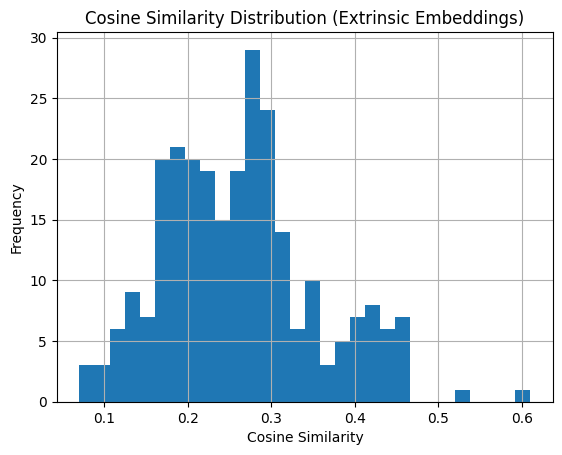

In [42]:
import random
import matplotlib.pyplot as plt

# Sample random word pairs
words = random.sample(list(word_vocab.keys()), 1000)
similarities = []
for i in range(len(words)-1):
    w1, w2 = words[i], words[i+1]
    if w1 in w2v_model and w2 in w2v_model:
        sim = w2v_model.similarity(w1, w2)
        similarities.append(sim)

# Plot
plt.hist(similarities, bins=30)
plt.title("Cosine Similarity Distribution (Extrinsic Embeddings)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Explore Semantically Similar Words to "Glucose"

We use the pretrained Word2Vec model to retrieve the top 5 most similar words to "glucose" based on cosine similarity. This helps verify the semantic quality of the embeddings in a biomedical context.

In [43]:
w2v_model.most_similar('glucose', topn=5)

[('qglucose', 0.8199415802955627),
 ('rglucose', 0.8195745944976807),
 ('glucose-time', 0.8183287978172302),
 ('iv-glucose', 0.8175548315048218),
 ('cglucose', 0.8104894757270813)]

### Visualize Similar Words to "Glucose" Using PCA

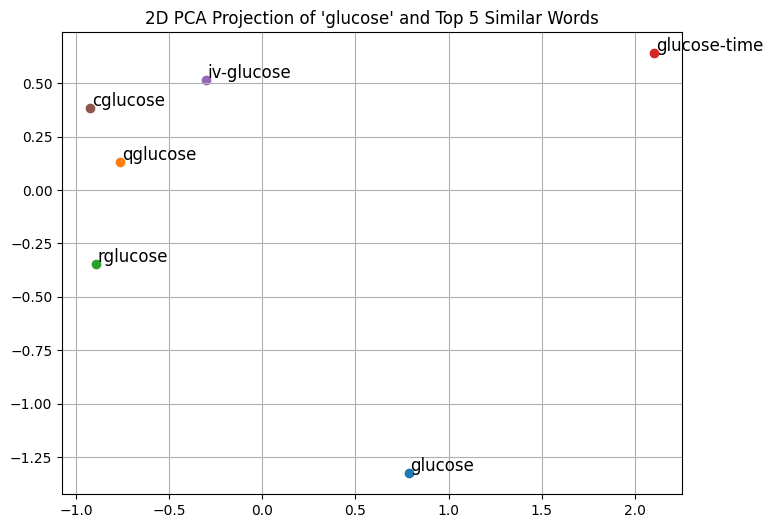

In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get top 5 most similar words
word = 'glucose'
topn = 5
similar_words = w2v_model.most_similar(word, topn=topn)

# Collect word vectors
words = [word] + [w for w, _ in similar_words]  # include 'glucose' itself
vectors = [w2v_model[w] for w in words]

# Reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(words):
    x, y = reduced_vectors[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=12)

plt.title(f"2D PCA Projection of '{word}' and Top {topn} Similar Words")
plt.grid(True)
plt.show()


### Define a PyTorch Module for Pretrained Word Embeddings

In [45]:
import torch.nn as nn
class PretrainedWordEmbedding(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.word_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.output_dim = embedding_matrix.shape[1]

    def forward(self, word_ids, char_ids=None):
        return self.word_embedding(word_ids)

## Combined words and char embeddings with ngram

### Define a PyTorch Module for Pretrained Word Embeddings

In [46]:
import torch
import torch.nn as nn

word_embedding = nn.Embedding(VOCAB_SIZE, DIM)

### Build Character Vocabulary for Char-Level Embeddings

In [47]:
chars = set([c for token in all_tokens for c in token])
char_to_id = {char: idx + 2 for idx, char in enumerate(chars)}
char_to_id['<PAD>'] = 0
char_to_id['<UNK>'] = 1

### Analyze Word Lengths for Character Embeddings

We visualize the distribution of word lengths (in characters) to help choose a reasonable maximum length for character-level embeddings. The 99th percentile is marked to guide truncation and padding decisions for input words.


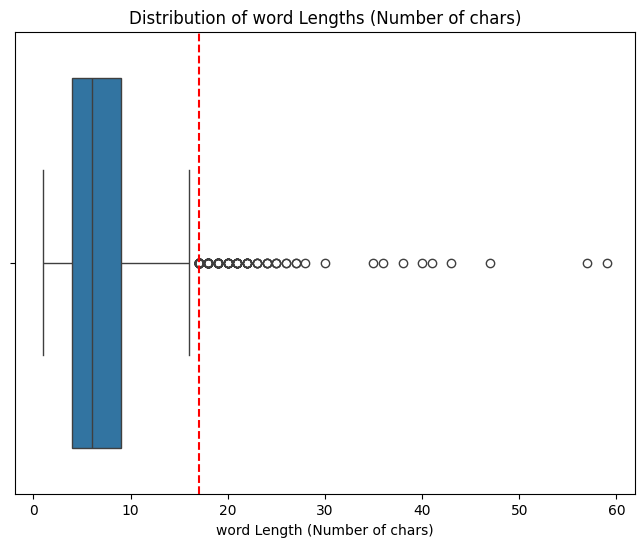

In [48]:
word_lengths = [len(w) for w in all_tokens]

plt.figure(figsize=(8, 6))
sns.boxplot(x=word_lengths)
plt.axvline(x=np.percentile(word_lengths, 99), color='red', linestyle='--', label='99th Percentile')
plt.title("Distribution of word Lengths (Number of chars)")
plt.xlabel("word Length (Number of chars)")
plt.show()

In [49]:
MAX_LENGTH_WORD = 15

In [50]:
def word_to_char_ids(word, char_to_id):
    char_ids = [char_to_id.get(c, char_to_id['<UNK>']) for c in word]
    char_ids = char_ids[:MAX_LENGTH_WORD]
    char_ids += [char_to_id['<PAD>']] * (MAX_LENGTH_WORD - len(char_ids))
    return char_ids

In [51]:
def convert_tokens_to_char_ids(dataset, id_to_token_fn, char_to_id, token_to_id): # Added token_to_id as argument
    """Convert token IDs in a dataset to lists of character IDs per token."""
    updated_dataset = []

    # Create the id_to_token dictionary using token_to_id
    id_to_token = {v: k for k, v in token_to_id.items()} # Create the id_to_token dictionary

    for row in dataset:
        token_ids = row['tokens']
        char_id_seqs = []

        for token_id in token_ids:
            token = id_to_token.get(token_id, '<UNK>')
            char_ids = word_to_char_ids(token, char_to_id)
            char_id_seqs.append(char_ids)

        updated_dataset.append({
            'tokens': char_id_seqs,
            'ner_tags': row['ner_tags']
        })

    return updated_dataset

train_char_dataset = convert_tokens_to_char_ids(padded_train_data, id_to_token_fn, char_to_id, word_vocab)
test_char_dataset = convert_tokens_to_char_ids(padded_test_data, id_to_token_fn, char_to_id, word_vocab)
validate_char_dataset = convert_tokens_to_char_ids(padded_validate_data, id_to_token_fn, char_to_id, word_vocab)

In [52]:
class WordAndCharEmbedding(nn.Module):
    def __init__(self, word_vocab_size, word_embedding_dim, char_vocab_size, char_embedding_dim, hidden_dim):
        super().__init__()

        # word-level embedding
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim, padding_idx=0)

        # char-level embedding
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim, padding_idx=0)
        self.char_lstm = nn.LSTM(char_embedding_dim, hidden_dim // 2, bidirectional=True, batch_first=True, num_layers=1)

        self.dropout = nn.Dropout(0.5)
        self.output_dim = word_embedding_dim + hidden_dim

    def forward(self, word_ids, char_ids):
        batch_size, seq_len, max_word_len = char_ids.size()

        word_emb = self.word_embedding(word_ids)                          # [B, L, D_word]
        char_ids = char_ids.view(-1, max_word_len)                        # [B*L, max_len]
        char_emb = self.char_embedding(char_ids)                          # [B*L, max_len, D_char]

        _, (hidden, _) = self.char_lstm(char_emb)                         # hidden: [2, B*L, H/2]
        char_repr = torch.cat([hidden[0], hidden[1]], dim=-1)             # [B*L, H]
        char_repr = char_repr.view(batch_size, seq_len, -1)               # [B, L, H]

        combined = torch.cat([word_emb, char_repr], dim=-1)               # [B, L, D_word + H]
        return self.dropout(combined)

In [53]:
word_char_embedding = WordAndCharEmbedding(
    word_vocab_size=VOCAB_SIZE,
    word_embedding_dim=DIM,  # Word embedding dimension
    char_vocab_size=len(char_to_id),
    char_embedding_dim=50,  # Character embedding dimension
    hidden_dim=100           # Hidden dimension for char-level LSTM
)

embedding_dim = DIM + 100

In [54]:
word_ids = torch.randint(0, len(word_vocab), (32, 50))
char_ids = torch.randint(0, len(char_to_id), (32, 50, 12))

combined = word_char_embedding(word_ids, char_ids)
print(combined.shape)

torch.Size([32, 50, 200])


# Define model (crf + biLSTM)

## BiLSTM-CRF Model for Sequence Tagging

This class implements a BiLSTM-CRF architecture commonly used for sequence labeling tasks such as Named Entity Recognition (NER), POS tagging, or chunking. It combines the contextual representation power of a BiLSTM with the structured prediction capability of a Conditional Random Field (CRF).

The model accepts token-level embeddings (with optional character-level features) and predicts a sequence of tags, ensuring tag dependencies are modeled correctly.


In [55]:
import torch
import torch.nn as nn
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, num_labels):
        super().__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(self.embedding.output_dim, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, word_ids, char_ids=None, labels=None, mask=None):
        if char_ids is not None:
            embeddings = self.embedding(word_ids, char_ids)
        else:
            embeddings = self.embedding(word_ids)
        lstm_out, _ = self.lstm(embeddings)
        emissions = self.hidden2tag(lstm_out)

        if labels is not None:
            return -self.crf(emissions, labels, mask=mask, reduction='mean')
        else:
            return self.crf.decode(emissions, mask=mask)

### Key Features:
- **Embedding Layer**: Accepts an externally defined embedding module that supports word or word+character input.
- **BiLSTM**: Captures left and right context using a bidirectional LSTM with hidden state size split in half for each direction.
- **Linear Transformation**: Projects LSTM outputs to tag space.
- **CRF Layer**: Computes either the most likely tag sequence (during inference) or the negative log-likelihood loss (during training).



### NERDataset Class

This class defines a custom PyTorch `Dataset` for Named Entity Recognition (NER) tasks.

- **Inputs:**
  - `word_data`: A list of dictionaries containing word-level token IDs, NER tags, and attention masks.
  - `char_data` *(optional)*: A list of dictionaries containing character-level token IDs for each word.

- **Output:**
  - If `char_data` is provided: returns a tuple `(tokens, char_ids, ner_tags, mask)`
  - Otherwise: returns `(tokens, ner_tags, mask)`

The dataset is designed to be compatible with `DataLoader` for efficient batching during training or evaluation.


In [56]:
from torch.utils.data import Dataset

class NERDataset(Dataset):
    def __init__(self, word_data, char_data=None):
        self.word_data = word_data
        self.char_data = char_data

    def __len__(self):
        return len(self.word_data)

    def __getitem__(self, idx):
        word_item = self.word_data[idx]
        tokens = torch.tensor(word_item['tokens'], dtype=torch.long)
        ner_tags = torch.tensor(word_item['ner_tags'], dtype=torch.long)
        mask = torch.tensor(word_item['mask'], dtype=torch.bool)

        if self.char_data is not None:
            char_item = self.char_data[idx]
            char_ids = torch.tensor(char_item['tokens'], dtype=torch.long)
            return tokens, char_ids, ner_tags, mask
        else:
            return tokens, ner_tags, mask

## Dataset Initialization

We create three instances of the custom `NERDataset` class for training, validation, and test splits.

Each dataset takes:
- `padded_*_data`: Word-level input data with token IDs, NER tags, and attention masks.
- `*_char_dataset`: (Optional) Character-level input data for each word, useful for models that incorporate sub-word features.

In [57]:
train_dataset = NERDataset(padded_train_data, train_char_dataset)
test_dataset = NERDataset(padded_test_data, test_char_dataset)
validate_dataset = NERDataset(padded_validate_data, validate_char_dataset)

### Custom Collate Function

This `collate_fn` is used with PyTorch `DataLoader` to batch variable-length samples from the `NERDataset`.

It supports both:
- Word-only input: `(tokens, ner_tags, mask)`
- Word + character input: `(tokens, char_ids, ner_tags, mask)`

The function stacks the tensors along the batch dimension for each field, allowing the model to process input in mini-batches.

In [58]:
def collate_fn(batch):
    if len(batch[0]) == 4:
        tokens, char_ids, ner_tags, masks = zip(*batch)
        return (
            torch.stack(tokens),
            torch.stack(char_ids),
            torch.stack(ner_tags),
            torch.stack(masks)
        )
    else:
        tokens, ner_tags, masks = zip(*batch)
        return (
            torch.stack(tokens),
            torch.stack(ner_tags),
            torch.stack(masks)
        )


# Training and evaluation

In [59]:
# Hyperparameters
NUM_EPOCHS = 10
BATCH_SIZE = 32

In [60]:
from sklearn.metrics import f1_score, accuracy_score

def evaluate_model(model, dataloader, id_to_tag=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 4:
                tokens, char_ids, tags, mask = batch
                predictions = model(tokens, char_ids=char_ids, mask=mask)
            else:
                tokens, tags, mask = batch
                predictions = model(tokens, mask=mask)

            for pred_seq, true_seq, m in zip(predictions, tags, mask):
                seq_len = m.sum().item()
                pred = pred_seq[:seq_len]
                true = true_seq[:seq_len].tolist()

                all_preds.extend(pred)
                all_labels.extend(true)

    model.train()

    f1 =  f1_score(all_labels, all_preds, average="macro")

    return f1


### Training Function

The `train_model` function handles the full training loop for the NER model.

In [61]:
import torch

def train_model(
    model,
    train_loader,
    optimizer,
    num_epochs=5,
    val_loader=None,
    id_to_tag=None,
    save_path="best_model.pt"
):
    best_f1 = -1.0
    train_loss = []
    f1_scores = []
    for epoch in range(num_epochs):

        model.train()
        total_loss = 0

        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()

            if len(batch) == 4:
                tokens, char_ids, tags, mask = batch
                loss = model(tokens, char_ids=char_ids, labels=tags, mask=mask)
            else:
                tokens, tags, mask = batch
                loss = model(tokens, labels=tags, mask=mask)

            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Training Loss: {total_loss:.4f}")

        if val_loader is not None and id_to_tag is not None:
            f1_score = evaluate_model(model, val_loader, id_to_tag)
            f1_scores.append(f1_score)
            print(f"f1 score  - {f1_score}")

            # Save best model by F1
            if f1_score > best_f1:
                best_f1 = f1_score
                torch.save(model.state_dict(), save_path)
                print(f"Best model updated and saved to: {save_path}")
    return train_loss, f1_scores

In [62]:
## Dataloader initialisation

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
validate_loader = DataLoader(validate_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [63]:
##Epoch setting


NUM_EPOCHS = 10

## Training BiLSTM-CRF with Pretrained Word Embeddings

In [64]:
from torch.optim import Adam

w2v_embedding = PretrainedWordEmbedding(embedding_matrix)


model_w2v = BiLSTM_CRF(
    embedding_layer=w2v_embedding,
    hidden_dim=256,
    num_labels=len(tag_to_id)
)
with torch.no_grad():
    model_w2v.crf.start_transitions[tag_to_id['B-AC']] -= 2.0
    model_w2v.crf.transitions[tag_to_id['O'], tag_to_id['I-LF']] -= 2.0
    model_w2v.crf.transitions[tag_to_id['I-LF'], tag_to_id['B-AC']] -= 2.0


optimizer_w2v = Adam(model_w2v.parameters(), lr=0.001)


w2v_loss, w2v_f1 = train_model(model_w2v, train_loader, optimizer_w2v, num_epochs=NUM_EPOCHS, val_loader=validate_loader, id_to_tag=tag_to_id, save_path="w2v_model.pt")
# Load the best model
model_w2v.load_state_dict(torch.load("w2v_model.pt"))

Epoch 1, Training Loss: 1511.4813
f1 score  - 0.6478433215031135
Best model updated and saved to: w2v_model.pt
Epoch 2, Training Loss: 767.3335
f1 score  - 0.7286098607530859
Best model updated and saved to: w2v_model.pt
Epoch 3, Training Loss: 560.9699
f1 score  - 0.7330582621940266
Best model updated and saved to: w2v_model.pt
Epoch 4, Training Loss: 427.1911
f1 score  - 0.7608214696286343
Best model updated and saved to: w2v_model.pt
Epoch 5, Training Loss: 326.9213
f1 score  - 0.7573867965479752
Epoch 6, Training Loss: 246.1382
f1 score  - 0.7576781393458996
Epoch 7, Training Loss: 174.1904
f1 score  - 0.7501874257908294
Epoch 8, Training Loss: 125.3383
f1 score  - 0.7337810422352326
Epoch 9, Training Loss: 89.6450
f1 score  - 0.7115414928928943
Epoch 10, Training Loss: 61.7840
f1 score  - 0.7251252064570106


<All keys matched successfully>

### Training BiLSTM-CRF with Combined Word and Character Embeddings

In [65]:
combined_embedding = WordAndCharEmbedding(
    word_vocab_size=VOCAB_SIZE,           # size of your word_vocab
    word_embedding_dim=DIM,               # e.g. 100
    char_vocab_size=len(char_to_id),      # size of your char vocab
    char_embedding_dim=50,                # dimension of character embeddings
    hidden_dim=100                        # hidden size for char-level BiLSTM
)

model_combined = BiLSTM_CRF(
    embedding_layer=combined_embedding,
    hidden_dim=256,                       # hidden size for main BiLSTM
    num_labels=len(tag_to_id)            # number of NER classes
)
with torch.no_grad():
    model_combined.crf.start_transitions[tag_to_id['B-AC']] -= 2.0
    model_combined.crf.transitions[tag_to_id['O'], tag_to_id['I-LF']] -= 2.0
    model_combined.crf.transitions[tag_to_id['I-LF'], tag_to_id['B-AC']] -= 2.0


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn                 # the flexible collate_fn we discussed
)

optimizer_combined = Adam(model_combined.parameters(), lr=0.001)


combined_loss, combined_f1 = train_model(model_combined, train_loader, optimizer_combined, num_epochs=NUM_EPOCHS, val_loader=validate_loader, id_to_tag=tag_to_id, save_path="combined_model.pt")
# Load the best model
model_combined.load_state_dict(torch.load("combined_model.pt"))

Epoch 1, Training Loss: 1734.4281
f1 score  - 0.47378996650341554
Best model updated and saved to: combined_model.pt
Epoch 2, Training Loss: 836.9286
f1 score  - 0.7187333656581152
Best model updated and saved to: combined_model.pt
Epoch 3, Training Loss: 623.3666
f1 score  - 0.7415869914687453
Best model updated and saved to: combined_model.pt
Epoch 4, Training Loss: 545.5786
f1 score  - 0.7438823489996353
Best model updated and saved to: combined_model.pt
Epoch 5, Training Loss: 505.3582
f1 score  - 0.7470374425873004
Best model updated and saved to: combined_model.pt
Epoch 6, Training Loss: 460.3598
f1 score  - 0.7650342067651847
Best model updated and saved to: combined_model.pt
Epoch 7, Training Loss: 427.4587
f1 score  - 0.7610019249682197
Epoch 8, Training Loss: 396.1058
f1 score  - 0.7605650410648497
Epoch 9, Training Loss: 373.3718
f1 score  - 0.7576345828027616
Epoch 10, Training Loss: 352.1060
f1 score  - 0.7586608480007888


<All keys matched successfully>

### Tag ID to Label Mapping

In [66]:
id2tag = {v: k for k, v in tag_to_id.items()}

## Evaluation Using `seqeval`

In [67]:
from seqeval.metrics import classification_report

def evaluate_seqeval(model, dataloader, tag_to_id):
    id2tag = {v: k for k, v in tag_to_id.items()}
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 4:
                tokens, char_ids, tags, mask = batch
                preds = model(tokens, char_ids=char_ids, mask=mask)
            else:
                tokens, tags, mask = batch
                preds = model(tokens, mask=mask)

            for pred_seq, true_seq, m in zip(preds, tags, mask):
                seq_len = m.sum().item()
                pred_tags = [id2tag[p] for p in pred_seq[:seq_len]]
                true_tags = [id2tag[t.item()] for t in true_seq[:seq_len]]

                all_preds.append(pred_tags)
                all_labels.append(true_tags)

    model.train()
    print(classification_report(all_labels, all_preds))

### Final Evaluation on Test Set

In [68]:
print("Evaluation for Word2Vec embedding:")
evaluate_seqeval(model_w2v, test_loader, tag_to_id)


print("Evaluation for Word+Char embedding:")
evaluate_seqeval(model_combined, test_loader, tag_to_id)

Evaluation for Word2Vec embedding:
              precision    recall  f1-score   support

          AC       0.82      0.68      0.74       793
          LF       0.68      0.70      0.69       481

   micro avg       0.76      0.69      0.72      1274
   macro avg       0.75      0.69      0.72      1274
weighted avg       0.77      0.69      0.72      1274

Evaluation for Word+Char embedding:
              precision    recall  f1-score   support

          AC       0.76      0.77      0.77       793
          LF       0.65      0.66      0.65       481

   micro avg       0.72      0.73      0.72      1274
   macro avg       0.70      0.72      0.71      1274
weighted avg       0.72      0.73      0.72      1274



### Training Loss Comparison

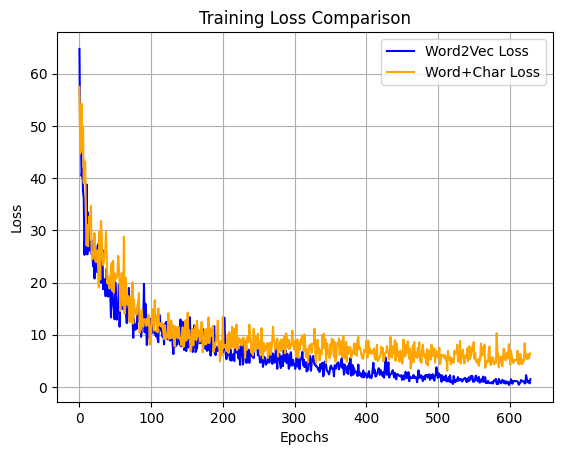

In [69]:
# digram to compare two models training loss
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.plot(w2v_loss, label='Word2Vec Loss', color='blue')
plt.plot(combined_loss, label='Word+Char Loss', color='orange')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

### F1 Score Comparison

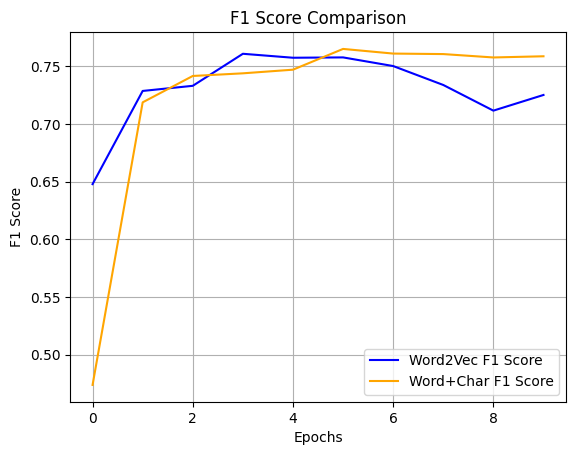

In [70]:
# digram to compare two models f1 score
plt.plot(w2v_f1, label='Word2Vec F1 Score', color='blue')
plt.plot(combined_f1, label='Word+Char F1 Score', color='orange')
plt.title('F1 Score Comparison')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

## Error analysis

### Confusion Matrix for NER Tags

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def get_ner_confusion_data(predictions, tag_list):
    all_preds, all_trues = [], []
    for _, preds, trues in predictions:
        for p, t in zip(preds, trues):
            all_preds.append(p)
            all_trues.append(t)

    cm = confusion_matrix(all_trues, all_preds, labels=tag_list, normalize='true')
    return cm


### Confusion Matrix Comparison for NER Models

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
def compare_ner_confusion_matrices(predictions_1, predictions_2, tag_list, labels=("Model 1", "Model 2")):
    cm1 = get_ner_confusion_data(predictions_1, tag_list)
    cm2 = get_ner_confusion_data(predictions_2, tag_list)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for ax, cm, label in zip(axes, [cm1, cm2], labels):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tag_list)
        disp.plot(cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
        ax.set_title(f"Confusion Matrix: {label}")
        ax.grid(False)

    plt.tight_layout()
    plt.show()


### Collecting NER Predictions

In [73]:
def collect_predictions(model, dataloader, id_to_tag, id_to_word=None, device='cpu'):
    model.eval()
    all_examples = []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 4:
                tokens, char_ids, tags, mask = batch
                tokens, char_ids, tags, mask = map(lambda x: x.to(device), (tokens, char_ids, tags, mask))
                preds = model(tokens, char_ids=char_ids, mask=mask)
            else:
                tokens, tags, mask = batch
                tokens, tags, mask = map(lambda x: x.to(device), (tokens, tags, mask))
                preds = model(tokens, mask=mask)

            for tok_ids, pred_seq, true_seq, m in zip(tokens, preds, tags, mask):
                seq_len = int(m.sum().item())
                pred_tags = [id_to_tag[p] for p in pred_seq[:seq_len]]
                true_tags = [id_to_tag[t.item()] for t in true_seq[:seq_len]]

                if id_to_word is not None:
                    words = [id_to_word[t.item()] for t in tok_ids[:seq_len]]
                else:
                    words = None

                all_examples.append((words, pred_tags, true_tags))

    model.train()
    return all_examples

### Final Confusion Matrix Comparison

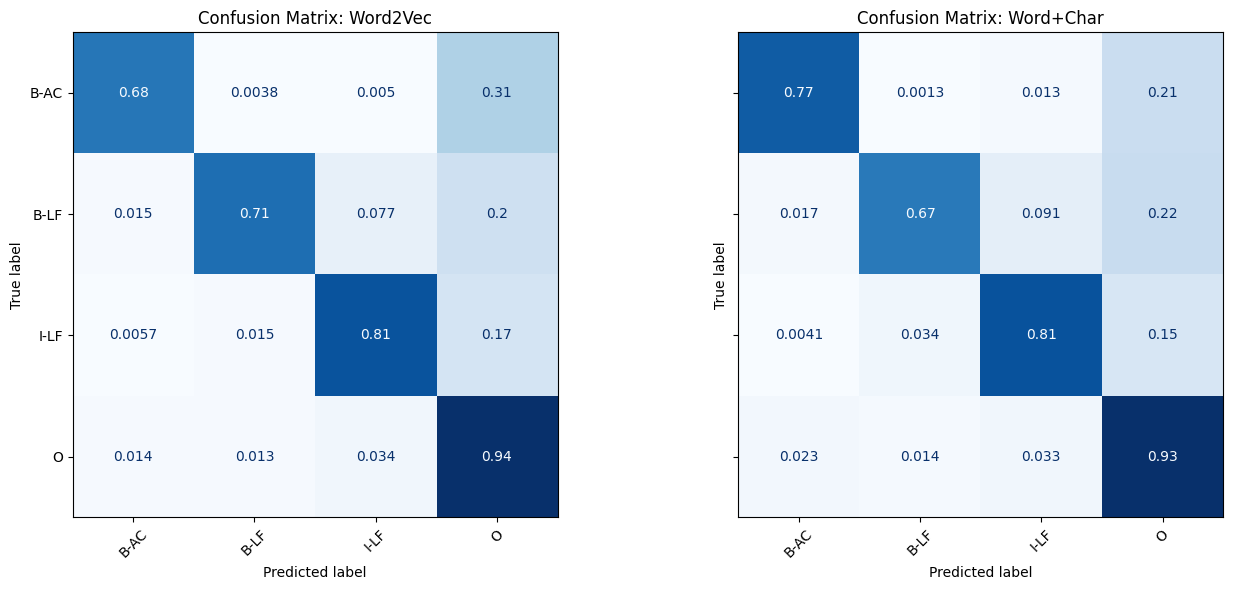

In [74]:
predictions_w2v = collect_predictions(model_w2v, test_loader, id2tag)
predictions_combined = collect_predictions(model_combined, test_loader, id2tag)

tag_list = sorted(set(tag for preds in [predictions_w2v, predictions_combined]
                      for _, p, t in preds for tag in p + t))

compare_ner_confusion_matrices(predictions_w2v, predictions_combined, tag_list, labels=("Word2Vec", "Word+Char"))

### Confusion Matrix Analysis: Word2Vec vs. Word+Char Models

We compared the performance of two NER models using normalized confusion matrices:

- **Model 1**: Word2Vec-only
- **Model 2**: Word + Character-level BiLSTM

#### Key Observations:

- **`B-AC` (Begin-AC)**:
  - Word2Vec: 80% correct, 19% misclassified as `O`.
  - Word+Char: Improved to **84%** correct, reduced confusion with `O`.

- **`B-LF` (Begin-LF)**:
  - Word2Vec: 69% correct, 18% → `O`, 8% → `I-LF`.
  - Word+Char: Slight improvement to 70%, with a small increase in `O` misclassification (22%).

- **`I-LF` (Inside-LF)**:
  - Word2Vec: 80% correct, 15% → `O`.
  - Word+Char: Slight dip to 77%, with a few more cases misclassified as `B-LF`.

- **`O` (Outside tag)**:
  - Both models show similar accuracy (~90%), with some confusion from boundary labels like `B-AC`.

#### Takeaway:
Character-level features improve classification of boundary entity tags (`B-AC`, `B-LF`), especially in distinguishing them from non-entity tokens (`O`). However, the added complexity introduces some trade-offs in adjacent class confusion, which is common in sequence labeling tasks.

These findings suggest the **Word+Char model generalizes slightly better**, particularly for detecting the beginning of entities with morphological cues.


In [75]:
from collections import Counter

def get_top_confusions(predictions, top_k=10, exclude_correct=True):
    confusion_counts = Counter()

    for _, pred_tags, true_tags in predictions:
        for pred, true in zip(pred_tags, true_tags):
            if exclude_correct and pred == true:
                continue
            confusion_counts[(true, pred)] += 1

    most_common = confusion_counts.most_common(top_k)
    print(f"\nTop {top_k} Tag Confusions:\n")
    for (true, pred), count in most_common:
        print(f"True: {true:<6} → Pred: {pred:<6} | Count: {count}")


### Tag Confusion Analysis: Word2Vec vs Word+Char Models

In [76]:
print("Word2Vec Confusions:")
get_top_confusions(predictions_w2v)

print("Word+Char Confusions:")
get_top_confusions(predictions_combined)

Word2Vec Confusions:

Top 10 Tag Confusions:

True: O      → Pred: I-LF   | Count: 263
True: B-AC   → Pred: O      | Count: 243
True: I-LF   → Pred: O      | Count: 204
True: O      → Pred: B-AC   | Count: 108
True: O      → Pred: B-LF   | Count: 102
True: B-LF   → Pred: O      | Count: 94
True: B-LF   → Pred: I-LF   | Count: 37
True: I-LF   → Pred: B-LF   | Count: 18
True: B-LF   → Pred: B-AC   | Count: 7
True: I-LF   → Pred: B-AC   | Count: 7
Word+Char Confusions:

Top 10 Tag Confusions:

True: O      → Pred: I-LF   | Count: 253
True: I-LF   → Pred: O      | Count: 187
True: O      → Pred: B-AC   | Count: 178
True: B-AC   → Pred: O      | Count: 168
True: B-LF   → Pred: O      | Count: 108
True: O      → Pred: B-LF   | Count: 104
True: B-LF   → Pred: I-LF   | Count: 44
True: I-LF   → Pred: B-LF   | Count: 42
True: B-AC   → Pred: I-LF   | Count: 10
True: B-LF   → Pred: B-AC   | Count: 8


In [77]:
id_to_token = {v: k for k, v in word_vocab.items()}

### Most Frequently Missed Tokens (False Negatives)

In [78]:
from collections import Counter

def get_most_missed_tokens(predictions, target_tags={"B-AC", "I-AC", "B-LF", "I-LF"}, top_k=20):
    missed = Counter()

    for tokens, pred_tags, true_tags in predictions:
        for word, pred, true in zip(tokens, pred_tags, true_tags):
            if true in target_tags and pred != true:
                missed[word] += 1

    print(f"\nTop {top_k} most frequently misclassified tokens (FN):\n")
    for token, count in missed.most_common(top_k):
        print(f"{token:<20} | Missed: {count}")


predictions_w2v = collect_predictions(model_w2v, test_loader, id2tag, id_to_token)
get_most_missed_tokens(predictions_w2v)

predictions_combined = collect_predictions(model_combined, test_loader, id2tag, id_to_token)
get_most_missed_tokens(predictions_combined)


Top 20 most frequently misclassified tokens (FN):

<UNK>                | Missed: 233
-                    | Missed: 42
and                  | Missed: 13
of                   | Missed: 9
,                    | Missed: 8
D                    | Missed: 5
FPG                  | Missed: 4
overweight           | Missed: 3
or                   | Missed: 3
obesity              | Missed: 3
6                    | Missed: 3
to                   | Missed: 3
Scale                | Missed: 3
Edition              | Missed: 3
for                  | Missed: 3
protein              | Missed: 3
rich                 | Missed: 3
ACC                  | Missed: 3
S                    | Missed: 3
Australian           | Missed: 3

Top 20 most frequently misclassified tokens (FN):

<UNK>                | Missed: 212
-                    | Missed: 21
and                  | Missed: 12
of                   | Missed: 9
/                    | Missed: 7
,                    | Missed: 6
Ginir                | Missed:

# EXPERIMENT 2: RNN + FastText and Bi-LSTM + FastText

### Objective: Compare RNN and Bi-LSTM models trained using FastText embeddings and evaluate performance differences.

In [79]:
# %pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.13.1 datasets gensim

In [80]:
# !pip install datasets #for loading PLOD-CW-25
# !pip install gensim #for loading FastText embeddings

In [81]:
from datasets import load_dataset

# Loading the PLOD-CW-25 dataset from Hugging Face
dataset = load_dataset("surrey-nlp/PLOD-CW-25")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})


 ### A. Preprocessing Tokens, Labels and POS Tags

 #### 1. Token Preparation

In [82]:
 # Extracting tokens and converting to lowercase properly
tokens_train = [[token.lower() for token in ex['tokens']] for ex in dataset['train']]
tokens_val   = [[token.lower() for token in ex['tokens']] for ex in dataset['validation']]
tokens_test  = [[token.lower() for token in ex['tokens']] for ex in dataset['test']]

# Update dataset tokens with lowercase versions
dataset['train'] = dataset['train'].map(lambda ex: {'tokens': [token.lower() for token in ex['tokens']]})
dataset['validation'] = dataset['validation'].map(lambda ex: {'tokens': [token.lower() for token in ex['tokens']]})
dataset['test'] = dataset['test'].map(lambda ex: {'tokens': [token.lower() for token in ex['tokens']]})

Map: 100%|██████████| 250/250 [00:00<00:00, 21403.88 examples/s]


#### 2. NER Label Encoding

In [83]:
 # Collecting all unique NER tags from the training set
unique_ner_tags = set(tag for ex in dataset['train'] for tag in ex['ner_tags'])
ner2id = {tag: idx for idx, tag in enumerate(sorted(unique_ner_tags))}

ner_tag_list = sorted(list(unique_ner_tags))
print("Unique NER tags:", ner_tag_list)

Unique NER tags: ['B-AC', 'B-LF', 'I-LF', 'O']


In [84]:
def encode_ner_tags(example):
    example['ner_ids'] = [ner2id[tag] for tag in example['ner_tags']]
    return example

In [85]:
encoded_dataset = dataset.map(encode_ner_tags, batched=False)

print(encoded_dataset['train'].column_names)
print(encoded_dataset['validation'].column_names)
print(encoded_dataset['test'].column_names)

Map: 100%|██████████| 150/150 [00:00<00:00, 19249.93 examples/s]

['tokens', 'pos_tags', 'ner_tags', 'ner_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids']


In [86]:
# Checking a sample to confirm
for i in range(3):
    print(f"\nExample {i+1}")
    print("Tokens:     ", encoded_dataset['train'][i]['tokens'])
    print("NER tags:   ", encoded_dataset['train'][i]['ner_tags'])
    print("NER IDs:    ", encoded_dataset['train'][i]['ner_ids'])


Example 1
Tokens:      ['mrr', ',', 'mortality', 'rate', 'ratio', ';', 'tbi', ',', 'traumatic', 'brain', 'injury', '.']
NER tags:    ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']
NER IDs:     [0, 3, 1, 2, 2, 3, 0, 3, 1, 2, 2, 3]

Example 2
Tokens:      ['hpc', ',', 'hippocampus', ';', 'mofc', ',', 'medial', 'ofc', ';', 'ofc', ',', 'orbitofrontal', 'cortex', ';', 'ppi', ',', 'psychophysiological', 'interaction', '.']
NER tags:    ['B-AC', 'O', 'B-LF', 'O', 'O', 'O', 'O', 'B-AC', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'O']
NER IDs:     [0, 3, 1, 3, 3, 3, 3, 0, 3, 0, 3, 1, 2, 3, 0, 3, 1, 2, 3]

Example 3
Tokens:      ['in', 'addition', 'to', 'the', 'effects', 'on', 'cell', 'growth', 'and', 'migration', ',', 'the', '18β', '-', 'ga', '-', 'd', 'used', 'in', 'this', 'study', 'could', 'also', 'up', '-', 'regulate', 'expression', 'of', 'aquaporin-3', '(', 'aqp-3', ')', 'in', 'fibroblasts', 'and', 'keratinocytes', '.']
NER tag

In [87]:
# extract for inspection
ner_train = [sentence['ner_tags'] for sentence in dataset['train']]
ner_val   = [sentence['ner_tags'] for sentence in dataset['validation']]
ner_test  = [sentence['ner_tags'] for sentence in dataset['test']]

In [88]:
print(encoded_dataset['train'].column_names)
print(encoded_dataset['validation'].column_names)
print(encoded_dataset['test'].column_names)

['tokens', 'pos_tags', 'ner_tags', 'ner_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids']


#### 3. POS Tag Assignment 

In [89]:
# Extracting POS tags
unique_pos_tags = set()
for example in dataset['train']:
    unique_pos_tags.update(example['pos_tags'])

pos_tag_list = sorted(list(unique_pos_tags))
print(" Unique POS tags:")
print(pos_tag_list)
print(f"Total POS tag types: {len(pos_tag_list)}")

 Unique POS tags:
['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
Total POS tag types: 17


In [90]:
# Creating mappings
pos2id = {pos: idx for idx, pos in enumerate(pos_tag_list)}
id2pos = {idx: pos for pos, idx in pos2id.items()}

# Printing sample of the mapping
print("\nPOS to ID mapping (sample):")
for i, (k, v) in enumerate(pos2id.items()):
    print(f"{k}: {v}")
    if i == 10: break  # just show first 10


POS to ID mapping (sample):
ADJ: 0
ADP: 1
ADV: 2
AUX: 3
CCONJ: 4
DET: 5
INTJ: 6
NOUN: 7
NUM: 8
PART: 9
PRON: 10


In [91]:
# Encoding POS tags in each example
def encode_pos_tags(example):
    example['pos_ids'] = [pos2id[pos] for pos in example['pos_tags']]
    return example

# First encode NER tags
encoded_dataset = dataset.map(encode_ner_tags)
encoded_dataset = encoded_dataset.map(encode_pos_tags)

print("\n Sample POS tags and encoded IDs:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print("POS Tags:", encoded_dataset['train'][i]['pos_tags'])
    print("POS IDs: ", encoded_dataset['train'][i]['pos_ids'])

Map: 100%|██████████| 150/150 [00:00<00:00, 18355.28 examples/s]


 Sample POS tags and encoded IDs:

Example 1:
POS Tags: ['NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']
POS IDs:  [7, 12, 7, 7, 7, 12, 11, 12, 0, 7, 7, 12]

Example 2:
POS Tags: ['PROPN', 'PUNCT', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'ADJ', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'ADJ', 'NOUN', 'PUNCT']
POS IDs:  [11, 12, 7, 12, 7, 12, 0, 11, 12, 11, 12, 0, 7, 12, 7, 12, 0, 7, 12]

Example 3:
POS Tags: ['ADP', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'CCONJ', 'NOUN', 'PUNCT', 'DET', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'NOUN', 'VERB', 'ADP', 'DET', 'NOUN', 'AUX', 'ADV', 'ADV', 'PUNCT', 'VERB', 'NOUN', 'ADP', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'ADP', 'NOUN', 'CCONJ', 'NOUN', 'PUNCT']
POS IDs:  [1, 7, 1, 5, 7, 1, 7, 7, 4, 7, 12, 5, 7, 12, 7, 12, 7, 15, 1, 5, 7, 3, 2, 2, 12, 15, 7, 1, 7, 12, 7, 12, 1, 7, 4, 7, 12]


In [92]:
print(encoded_dataset['train'].column_names)
print(encoded_dataset['validation'].column_names)
print(encoded_dataset['test'].column_names)

['tokens', 'pos_tags', 'ner_tags', 'ner_ids', 'pos_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids', 'pos_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids', 'pos_ids']


#### 4. Checking Alignment

In [93]:
for split in ['train', 'validation', 'test']:
    for example in encoded_dataset[split]:
        assert len(example['tokens']) == len(example['pos_ids']) == len(example['ner_ids']), \
            f"Alignment issue in {split} split! Example: {example}"
print(" All sequences (tokens, POS tags, NER tags) are correctly aligned.")

 All sequences (tokens, POS tags, NER tags) are correctly aligned.


In [94]:
# First three examples
for i in range(3):
    ex = encoded_dataset['train'][i]
    print(f"\n Example {i+1}")
    print("Tokens:   ", ex['tokens'])
    print("POS Tags: ", ex['pos_tags'])
    print("POS IDs:  ", ex['pos_ids'])
    print("NER Tags: ", ex['ner_tags'])
    print("NER IDs:  ", ex['ner_ids'])


 Example 1
Tokens:    ['mrr', ',', 'mortality', 'rate', 'ratio', ';', 'tbi', ',', 'traumatic', 'brain', 'injury', '.']
POS Tags:  ['NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']
POS IDs:   [7, 12, 7, 7, 7, 12, 11, 12, 0, 7, 7, 12]
NER Tags:  ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']
NER IDs:   [0, 3, 1, 2, 2, 3, 0, 3, 1, 2, 2, 3]

 Example 2
Tokens:    ['hpc', ',', 'hippocampus', ';', 'mofc', ',', 'medial', 'ofc', ';', 'ofc', ',', 'orbitofrontal', 'cortex', ';', 'ppi', ',', 'psychophysiological', 'interaction', '.']
POS Tags:  ['PROPN', 'PUNCT', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'ADJ', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'ADJ', 'NOUN', 'PUNCT']
POS IDs:   [11, 12, 7, 12, 7, 12, 0, 11, 12, 11, 12, 0, 7, 12, 7, 12, 0, 7, 12]
NER Tags:  ['B-AC', 'O', 'B-LF', 'O', 'O', 'O', 'O', 'B-AC', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 

In [95]:
# extracting for inspection:
pos_train = [ex['pos_tags'] for ex in encoded_dataset['train']]
pos_val   = [ex['pos_tags'] for ex in encoded_dataset['validation']]
pos_test  = [ex['pos_tags'] for ex in encoded_dataset['test']]

#### 5. Padding tokens, ner_tags, and pos_tags

In [96]:
# Getting max length of any sequence in training set
max_len = max(len(ex['tokens']) for ex in encoded_dataset['train'])
print(f" Max sequence length in training set: {max_len}")

 Max sequence length in training set: 371


In [97]:
def pad_sequence(seq, max_len, pad_value):
    return seq + [pad_value] * (max_len - len(seq))

def pad_example(example):
    example['pos_ids_padded'] = pad_sequence(example['pos_ids'], max_len, pad_value=0)
    example['ner_ids_padded'] = pad_sequence(example['ner_ids'], max_len, pad_value=-100)  # -100 is often used for ignored loss positions
    return example

padded_dataset = encoded_dataset.map(pad_example)

Map: 100%|██████████| 150/150 [00:00<00:00, 6592.88 examples/s]


In [98]:
for i in range(2):
    ex = padded_dataset['train'][i]
    print(f"\n Example {i+1}")
    print("POS IDs (padded):", ex['pos_ids_padded'])
    print("NER IDs (padded):", ex['ner_ids_padded'])
    print("Original length:", len(ex['pos_ids']), "| Padded length:", len(ex['pos_ids_padded']))


 Example 1
POS IDs (padded): [7, 12, 7, 7, 7, 12, 11, 12, 0, 7, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### B. Word Embedding using FastText (Facebook Pre-trained Model)

#### Download and load FastText Embeddings

In [100]:
if not os.path.exists("cc.en.300.bin"):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
    !gunzip cc.en.300.bin.gz

In [ ]:
# %pip install fasttext

In [102]:
import fasttext
fasttext_model = fasttext.load_model('cc.en.300.bin')

print(fasttext_model.get_dimension())
print(fasttext_model.get_words()[:10])  # Prints the first 10 words in the vocabulary

300
[',', 'the', '.', 'and', 'to', 'of', 'a', '</s>', 'in', 'is']


In [103]:
# Get embedding vector for a word
vector = fasttext_model.get_word_vector('biology')
print(vector.shape)

(300,)


In [104]:
# Check nearest neighbors
neighbors = fasttext_model.get_nearest_neighbors('biology', k=5)
for score, word in neighbors:
    print(f"{word}: {score:.4f}")

biochemistry: 0.7436
Biology: 0.7135
physiology: 0.7066
biology-: 0.6991
biology.The: 0.6988


#### 1. Out-Of-Vocabulary (OOV) Tokens Coverage Analysis

In [105]:
# Extracting all tokens from train, validation, and test splits
token_lists = [ex['tokens'] for split in ['train'] for ex in padded_dataset[split]]

# Flatten token lists and build a unique vocabulary set
vocab = set(token for sent in token_lists for token in sent)

print(f"Vocab size: {len(vocab)}")

Vocab size: 13194


In [106]:
# List of OOV tokens
oov_tokens = [token for token in vocab if token not in fasttext_model]

print(f" Number of OOV tokens: {len(oov_tokens)}")
print("Sample OOV tokens:", oov_tokens[:20])

 Number of OOV tokens: 2733
Sample OOV tokens: ['igg1', 'lc50', 'ampar-', 'ecm21', '5′utr', 'ppic', 'idh1', 'mhci', 'mm00840165_g1', 'goutières', 'rs4879801', 'made.[14', 'cpt1am', 'affymetrix', 'hydroxy-2′-deoxyguanosine', 'snrna', 'ppii-2', 'organization/', 'his2av', 'trpv1']


In [107]:
#Checking if FastText Can Still Embed OOV Tokens
can_embed = 0
for token in oov_tokens:
    try:
        _ = fasttext_model[token]
        can_embed += 1
    except KeyError:
        pass

print(f"FastText can generate embeddings for {can_embed} / {len(oov_tokens)} OOV tokens")

FastText can generate embeddings for 2733 / 2733 OOV tokens


The coverage analysis of the dataset vocabulary against the FastText model revealed a total of 2733 out-of-vocabulary (OOV) tokens — words that were not directly present in the FastText vocabulary list. However, FastText was still able to successfully generate embeddings for all 2733 of these OOV tokens through its subword n-gram approach. This confirms FastText’s capability to handle rare and unseen words effectively, ensuring comprehensive token embedding coverage even for tokens outside its original training vocabulary.

#### 2. Word Similarity and Analogy Tasks

In [108]:
words_to_check = ['protein', 'cell', 'gene', 'enzyme']

for word in words_to_check:
    print(f"\n Similar words to '{word}':")
    neighbors = fasttext_model.get_nearest_neighbors(word, k=5)
    for score, neighbor in neighbors:
        print(f"{neighbor:20} Similarity Score: {score:.4f}")


 Similar words to 'protein':
proteins             Similarity Score: 0.8211
Protein              Similarity Score: 0.7679
protien              Similarity Score: 0.7596
protein-             Similarity Score: 0.7494
protein.The          Similarity Score: 0.7186

 Similar words to 'cell':
cells                Similarity Score: 0.7223
Cell                 Similarity Score: 0.6876
cellular             Similarity Score: 0.6860
cell-                Similarity Score: 0.6649
cell.                Similarity Score: 0.6251

 Similar words to 'gene':
genes                Similarity Score: 0.8108
non-gene             Similarity Score: 0.7163
gene.The             Similarity Score: 0.7029
gene.                Similarity Score: 0.6861
genes.The            Similarity Score: 0.6734

 Similar words to 'enzyme':
enzymes              Similarity Score: 0.8222
enzymatic            Similarity Score: 0.7778
enzyme.              Similarity Score: 0.7206
glucosidase          Similarity Score: 0.6969
beta-glucosid

In [109]:
import numpy as np
import fasttext

# Function to check if FastText can embed the word (non-zero vector)
def can_fasttext_embed(word, model):
    vec = fasttext_model.get_word_vector(word)
    return not np.all(vec == 0)  # True if embedding is not all zeros

In [110]:
words_to_check = ['protein', 'cell', 'gene', 'enzyme']
topn = 5  # Number of similar words to retrieve

In [111]:
# Check embedding coverage for similar words
total_similar_words = 0
handled_similar_words = 0

for word in words_to_check:
    neighbors = fasttext_model.get_nearest_neighbors(word, k=topn)
    print(f"\n Checking embedding coverage for similar words to '{word}':")

    for score, neighbor in neighbors:
        total_similar_words += 1
        if can_fasttext_embed(neighbor, fasttext_model):
            handled_similar_words += 1
            print(f" {neighbor} (can embed)")
        else:
            print(f" {neighbor} (cannot embed)")


 Checking embedding coverage for similar words to 'protein':
 proteins (can embed)
 Protein (can embed)
 protien (can embed)
 protein- (can embed)
 protein.The (can embed)

 Checking embedding coverage for similar words to 'cell':
 cells (can embed)
 Cell (can embed)
 cellular (can embed)
 cell- (can embed)
 cell. (can embed)

 Checking embedding coverage for similar words to 'gene':
 genes (can embed)
 non-gene (can embed)
 gene.The (can embed)
 gene. (can embed)
 genes.The (can embed)

 Checking embedding coverage for similar words to 'enzyme':
 enzymes (can embed)
 enzymatic (can embed)
 enzyme. (can embed)
 glucosidase (can embed)
 beta-glucosidase (can embed)


In [112]:
# Final Summary
print("\nSummary:")
print(f"Total similar words suggested: {total_similar_words}")
print(f"FastText could generate embeddings for: {handled_similar_words} out of {total_similar_words}")


Summary:
Total similar words suggested: 20
FastText could generate embeddings for: 20 out of 20


The FastText embedding model was evaluated on 20 similar words retrieved through nearest neighbor search. The analysis showed that FastText successfully generated embeddings for all 20 suggested words, demonstrating its robust ability to handle word variations and related terms through subword information.

#### 3. Subword Information with FastText

FastText represents each word as a bag of character n-grams. This allows FastText to:
- Embed rare or unseen biomedical terms
- Generalize better in morphologically rich languages
- Handle typos and word variants  

The final embedding of a word is computed as the **sum of the vectors of its subwords**.

In [113]:
word = "neurodegeneration"

# Get subwords
subwords, _ = fasttext_model.get_subwords(word)

print(f"Subwords (character n-grams) of '{word}':")
print(subwords)

# Get word vector (composed from subwords)
vector = fasttext_model.get_word_vector(word)

print(f"\nEmbedding for '{word}':")
print(vector[:10])
print(f"Vector shape: {vector.shape}")

Subwords (character n-grams) of 'neurodegeneration':
['neurodegeneration', '<neur', 'neuro', 'eurod', 'urode', 'rodeg', 'odege', 'degen', 'egene', 'gener', 'enera', 'nerat', 'erati', 'ratio', 'ation', 'tion>']

Embedding for 'neurodegeneration':
[ 0.0106181   0.0027347   0.0146932   0.00357056  0.00878355  0.02088108
  0.03616107  0.00915477 -0.01464366  0.00400921]
Vector shape: (300,)


#### 4. Generate Embedding Matrix from Padded Tokens

Each token becomes a 300-dimensional vector, and each sentence becomes a matrix of shape [max_len, 300].

##### 4.1 Generate and Save FastText Embeddings and NER Labels

In [114]:
# Generate and Save FastText Embeddings and NER Labels

import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence

def get_sentence_embedding(tokens, model, max_len=371, emb_dim=300):
    embeddings = []
    for token in tokens:
        vec = model.get_word_vector(token.lower())
        embeddings.append(vec)
    while len(embeddings) < max_len:
        embeddings.append(np.zeros(emb_dim))
    return np.array(embeddings)

train_embeddings = []
for example in padded_dataset['train']:
    tokens = example['tokens']
    emb_matrix = get_sentence_embedding(tokens, fasttext_model)
    train_embeddings.append(emb_matrix)

train_embeddings = np.stack(train_embeddings)
np.save('train_embeddings.npy', train_embeddings)

# Labels
label_tensors = [torch.tensor(example['ner_ids'], dtype=torch.long) for example in padded_dataset['train']]
padded_labels = pad_sequence(label_tensors, batch_first=True, padding_value=-100)
np.save('train_labels.npy', padded_labels.numpy())

# Print outputs
print("Train embeddings shape:", train_embeddings.shape)
print("Train labels shape:", padded_labels.shape)
print("Embeddings and labels saved.\n")

Train embeddings shape: (2000, 371, 300)
Train labels shape: torch.Size([2000, 371])
Embeddings and labels saved.



This means every sentence is represented as a 371-token sequence, where each token is a 300-dimensional FastText vector.

##### 4.2 Load Saved Embeddings and Labels

In [115]:
# Load Saved Embeddings and Labels

train_embeddings = np.load('train_embeddings.npy')
train_labels = np.load('train_labels.npy')

X_train = torch.tensor(train_embeddings, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.long)

X_train_rnn = X_train.clone()
y_train_rnn = y_train.clone()
X_train_bilstm = X_train.clone()
y_train_bilstm = y_train.clone()

# Print outputs
print("Loaded embedding tensor shape:", X_train.shape)
print("Loaded label tensor shape:", y_train.shape, "\n")


Loaded embedding tensor shape: torch.Size([2000, 371, 300])
Loaded label tensor shape: torch.Size([2000, 371]) 



#### 5. Experiments with RNN and Bi-LSTM Models

##### 5.1 Define Hyperparameters and Compute Class Weights


- Defined key hyperparameters (input/output dimensions, hidden sizes, etc.).
- Counted label frequencies in the training data.
- Computed class weights using inverse frequency to handle label imbalance.
- Used `CrossEntropyLoss` with weights to:
    - Prevent the model from over-predicting the majority class (`O`)
    - Encourage learning from rare but important classes like `B-LF` and `B-AC`
- Ignored padded tokens using `ignore_index=-100` to focus training only on real tokens.

In [116]:
# Define Hyperparameters and Compute Class Weights ---

from collections import Counter
import torch.nn as nn

input_dim = 300
hidden_dim_rnn = 256
hidden_dim_bilstm = 128
output_dim = len(set(ner2id.values()))
batch_size = 32
learning_rate = 0.001
num_epochs = 5
dropout_rate = 0.3
padding_idx = -100
use_weighted_loss = True

# Class weights
all_labels_flat = [label for example in padded_dataset['train'] for label in example['ner_ids']]
label_counts = Counter(all_labels_flat)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

total_labels = sum(label_counts.values())
weights = [total_labels / (len(label_counts) * label_counts[i]) for i in range(output_dim)]
weights = torch.tensor(weights, dtype=torch.float32).to(device)

# Loss
if use_weighted_loss:
    loss_fn_rnn = nn.CrossEntropyLoss(weight=weights, ignore_index=padding_idx)
    loss_fn_bilstm = nn.CrossEntropyLoss(weight=weights, ignore_index=padding_idx)
else:
    loss_fn_rnn = nn.CrossEntropyLoss(ignore_index=padding_idx)
    loss_fn_bilstm = nn.CrossEntropyLoss(ignore_index=padding_idx)

# Print outputs
print("Label counts:", dict(label_counts))
print("Computed class weights:")
for i, w in enumerate(weights.tolist()):
    print(f"   Class {i}: Weight = {w:.4f}")
print("Loss functions initialized.\n")


Label counts: {0: 6626, 3: 62474, 1: 3923, 2: 9525}
Computed class weights:
   Class 0: Weight = 3.1145
   Class 1: Weight = 5.2605
   Class 2: Weight = 2.1666
   Class 3: Weight = 0.3303
Loss functions initialized.



  1. Label Distribution:
  - Class 3 (O) — *Non-entity tokens*: `62,474`  
  - Class 2 (I-LF) — *Inside Long Form*: `9,525`  
  - Class 0 (B-AC) — *Beginning of Abbreviation*: `6,626`  
  - Class 1 (B-LF) — *Beginning of Long Form*: `3,923` (rarest)

  This indicates that over 75% of tokens belong to the `"O"` class, while the actual informative labels like `B-AC` and `B-LF` are relatively sparse.

  2. Computed Class Weights (Inverse Frequency):
  - B-LF (Class 1) gets the highest weight `5.26` to emphasize learning from rare but critical tokens.
  - B-AC (Class 0) is also upweighted to `3.11`.
  - I-LF (Class 2) has a moderate weight of `2.17`.
  - O (Class 3), being very frequent, is downweighted to `0.33`.

  These weights are passed into `CrossEntropyLoss` to counter class imbalance and help the modelnfocus on underrepresented but meaningful tags.


  3. Interpretation of Label Counts and Class Weights  
  
  The dataset shows a significant class imbalance, which is common in sequence labeling tasks like biomedical abbreviation detection:

##### 5.2 DataLoader for Batching

In [117]:
# Create TensorDataset and DataLoaders

from torch.utils.data import TensorDataset, DataLoader

train_dataset_rnn = TensorDataset(X_train_rnn, y_train_rnn)
train_dataset_bilstm = TensorDataset(X_train_bilstm, y_train_bilstm)

train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=batch_size, shuffle=True)
train_loader_bilstm = DataLoader(train_dataset_bilstm, batch_size=batch_size, shuffle=True)

# Print outputs
print("RNN batches per epoch:", len(train_loader_rnn))
print("BiLSTM batches per epoch:", len(train_loader_bilstm), "\n")

RNN batches per epoch: 63
BiLSTM batches per epoch: 63 



The number of batches per epoch is computed by dividing the total number of examples by the batch size.

In our case:

Total examples = 2000 Batch size = 32 [ 2000/32 = 62.5]

Thus, we have 63 batches per epoch (62 full batches + 1 smaller batch).

##### 5.3 Define and Initialize Models

Defined two sequence models:

- RNNTagger: A uni-directional RNN followed by dropout and a linear layer.

- BiLSTMTagger: A bidirectional LSTM (BiLSTM) followed by dropout and a linear layer.

In [118]:
# Define and Initialize Models

class RNNTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(RNNTagger, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out)
        out = self.fc(out)
        return out

class BiLSTMTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(BiLSTMTagger, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        out, _ = self.bilstm(x)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Instantiate
rnn_model = RNNTagger(input_dim, hidden_dim_rnn, output_dim, dropout_rate).to(device)
bilstm_model = BiLSTMTagger(input_dim, hidden_dim_bilstm, output_dim, dropout_rate).to(device)

# Print outputs
print("RNN model initialized:")
print(rnn_model)
print("\n BiLSTM model initialized:")
print(bilstm_model)


RNN model initialized:
RNNTagger(
  (rnn): RNN(300, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

 BiLSTM model initialized:
BiLSTMTagger(
  (bilstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)


Both models were successfully initialized with the following configurations:

- **RNN Model (`RNNTagger`)**
  - Input size: `300`
  - Hidden size: `256` (uni-directional)
  - Output layer: `Linear(256 → 4)`
  - Dropout: `0.3`

- **BiLSTM Model (`BiLSTMTagger`)**
  - Input size: `300`
  - Hidden size: `128` per direction → `256` total (bidirectional)
  - Output layer: `Linear(256 → 4)`
  - Dropout: `0.3`

Both models produce output of shape `[batch_size, seq_len, 4]` for token-level classification across 4 classes.

##### 5.4 Training Loop for RNN and BiLSTM Models

- Defined separate optimizers for RNN and BiLSTM using Adam.
- Created a shared `train_model()` function that:
    - Sets model to training mode
    - Loops through each epoch and batch
    - Performs forward pass, computes loss, backpropagation, and optimizer step
    - Logs average training loss per epoch
- Trained both models independently using their respective dataloaders and loss functions.

In [119]:
from sklearn.metrics import f1_score
from torch import optim

# optimizers for both models
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=learning_rate)
optimizer_bilstm = optim.Adam(bilstm_model.parameters(), lr=learning_rate)

# training function
def train_model(model, train_loader, optimizer, criterion, num_epochs, model_name="Model"):
    model.train()
    train_losses = []
    train_f1_scores = []

    print(f"\nTraining started for {model_name}\n")
    for epoch in range(1, num_epochs + 1):
        total_loss = 0
        y_true = []
        y_pred = []

        for batch_embeddings, batch_labels in train_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = criterion(outputs.view(-1, output_dim), batch_labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Collect predictions and true labels for F1 calculation
            preds = torch.argmax(outputs, dim=-1)
            for i in range(batch_labels.shape[0]):
                for j in range(batch_labels.shape[1]):
                    if batch_labels[i][j] != -100:
                        y_true.append(batch_labels[i][j].item())
                        y_pred.append(preds[i][j].item())

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Calculate F1-score for training
        train_f1 = f1_score(y_true, y_pred, average='micro')
        train_f1_scores.append(train_f1)

        print(f"{model_name} - Epoch {epoch}/{num_epochs} | Average Training Loss: {avg_loss:.4f} | Train F1: {train_f1:.4f}")

    print(f"Training completed for {model_name}\n")
    return train_losses, train_f1_scores

# Training both models
rnn_losses, rnn_train_f1 = train_model(rnn_model, train_loader_rnn, optimizer_rnn, loss_fn_rnn, num_epochs, model_name="RNN")
bilstm_losses, bilstm_train_f1 = train_model(bilstm_model, train_loader_bilstm, optimizer_bilstm, loss_fn_bilstm, num_epochs, model_name="BiLSTM")



Training started for RNN

RNN - Epoch 1/5 | Average Training Loss: 0.8191 | Train F1: 0.5893
RNN - Epoch 2/5 | Average Training Loss: 0.6203 | Train F1: 0.6980
RNN - Epoch 3/5 | Average Training Loss: 0.5748 | Train F1: 0.7149
RNN - Epoch 4/5 | Average Training Loss: 0.5499 | Train F1: 0.7300
RNN - Epoch 5/5 | Average Training Loss: 0.5312 | Train F1: 0.7312
Training completed for RNN


Training started for BiLSTM

BiLSTM - Epoch 1/5 | Average Training Loss: 0.9688 | Train F1: 0.6498
BiLSTM - Epoch 2/5 | Average Training Loss: 0.5231 | Train F1: 0.7932
BiLSTM - Epoch 3/5 | Average Training Loss: 0.4348 | Train F1: 0.8177
BiLSTM - Epoch 4/5 | Average Training Loss: 0.3925 | Train F1: 0.8345
BiLSTM - Epoch 5/5 | Average Training Loss: 0.3553 | Train F1: 0.8475
Training completed for BiLSTM



BiLSTM learns faster and generalizes better on the training set compared to RNN, achieving higher F1-scores with lower training loss.

##### 5.5 Compare Training Losses for RNN and BiLSTM

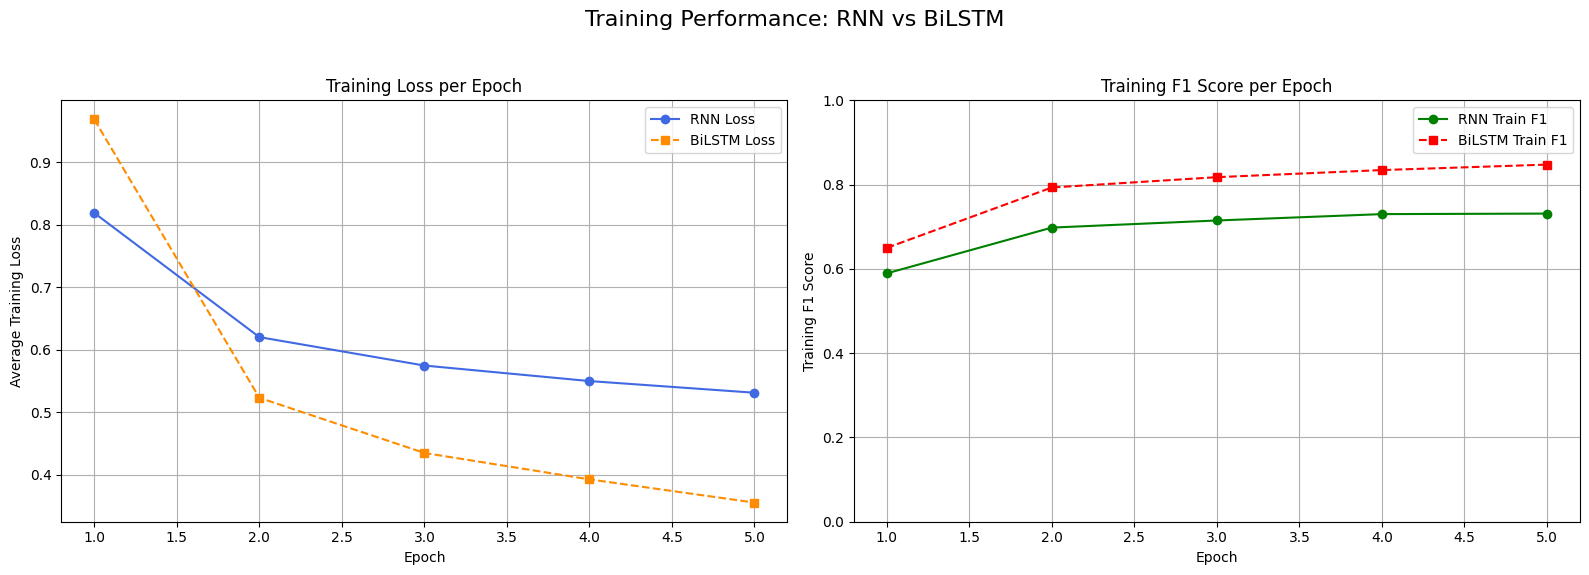

In [120]:
import matplotlib.pyplot as plt

# Epochs
epochs_rnn = range(1, len(rnn_losses) + 1)
epochs_bilstm = range(1, len(bilstm_losses) + 1)

# Create 1 row, 2 columns of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot Training Loss ---
ax1.plot(epochs_rnn, rnn_losses, marker='o', linestyle='-', color='royalblue', label='RNN Loss')
ax1.plot(epochs_bilstm, bilstm_losses, marker='s', linestyle='--', color='darkorange', label='BiLSTM Loss')
ax1.set_title('Training Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Training Loss')
ax1.legend()
ax1.grid(True)

# --- Plot Training F1 Accuracy ---
ax2.plot(epochs_rnn, rnn_train_f1, marker='o', linestyle='-', color='green', label='RNN Train F1')
ax2.plot(epochs_bilstm, bilstm_train_f1, marker='s', linestyle='--', color='red', label='BiLSTM Train F1')
ax2.set_title('Training F1 Score per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training F1 Score')
ax2.set_ylim(0, 1)  # F1 score is between 0 and 1
ax2.legend()
ax2.grid(True)

# Adjust layout
plt.suptitle('Training Performance: RNN vs BiLSTM', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#### 6. Evaluation on Validation data

**Training + Validation Setup**

  - Number of Epochs: `50`  
    → Maximum training duration for both RNN and BiLSTM

  - Early Stopping:
    - Patience: `5` epochs  
      → Training stops if validation loss doesn't improve for 5 consecutive epochs
    - Model Checkpoint Paths:
      - `best_rnn.pth` for RNN
      - `best_bilstm.pth` for BiLSTM

  - Loss Function:  
    - `CrossEntropyLoss` with:
      - Class weights (to address label imbalance)
      - `ignore_index = -100` (to skip padded tokens)

  - Monitoring Metric:  
    - Validation Loss (no early stopping on accuracy or F1)

##### 6.1  Prepare Validation Embeddings and Labels

In [ ]:
# Create validation embeddings
val_embeddings = []
for example in padded_dataset['validation']:
    tokens = example['tokens']
    emb_matrix = get_sentence_embedding(tokens, fasttext_model)
    val_embeddings.append(emb_matrix)

val_embeddings = np.stack(val_embeddings)
np.save('val_embeddings.npy', val_embeddings)
print("Validation embeddings shape:", val_embeddings.shape)

# Pad validation labels to max_len
max_len = 371
val_label_tensors = []
for example in padded_dataset['validation']:
    ner_ids = example['ner_ids']
    ner_ids_tensor = torch.tensor(ner_ids, dtype=torch.long)
    if len(ner_ids_tensor) < max_len:
        pad_size = max_len - len(ner_ids_tensor)
        ner_ids_tensor = torch.cat([ner_ids_tensor, torch.full((pad_size,), -100, dtype=torch.long)])
    else:
        ner_ids_tensor = ner_ids_tensor[:max_len]
    val_label_tensors.append(ner_ids_tensor)

padded_val_labels = torch.stack(val_label_tensors)
np.save('val_labels.npy', padded_val_labels.numpy())
print(" Validation labels shape:", padded_val_labels.shape, "\n")


Validation embeddings shape: (150, 371, 300)
 Validation labels shape: torch.Size([150, 371]) 



In [ ]:
# Load Validation Data
val_embeddings = np.load('val_embeddings.npy')
val_labels = np.load('val_labels.npy')

val_embedding_tensor = torch.tensor(val_embeddings, dtype=torch.float).to(device)
val_labels = torch.tensor(val_labels, dtype=torch.long).to(device)

print("Loaded validation data:")
print("Embedding shape:", val_embedding_tensor.shape)
print("Label shape:", val_labels.shape, "\n")

Loaded validation data:
Embedding shape: torch.Size([150, 371, 300])
Label shape: torch.Size([150, 371]) 



##### 6.2 Evaluation and EarlyStopping

In [ ]:
# Evaluation and EarlyStopping
def evaluate(model, val_embeddings, val_labels, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(val_embeddings)
        val_loss = criterion(outputs.view(-1, output_dim), val_labels.view(-1))
    return val_loss.item(), outputs

class EarlyStopping:
    def __init__(self, patience=5, save_path='best_model.pth'):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.save_path = save_path
        self.best_epoch = 0

    def __call__(self, val_loss, model, epoch):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
            print(f"Validation loss improved. Model saved to {self.save_path}")
        else:
            self.counter += 1
            print(f"No improvement for {self.counter} epoch(s).")
            if self.counter >= self.patience:
                print("Early stopping triggered!")
                self.early_stop = True

In [ ]:
def train_with_validation(model, train_loader, val_embeddings, val_labels,
                          optimizer, criterion, num_epochs, model_name,
                          save_path, early_stopping):

    train_losses, val_losses, val_f1_scores = [], [], []

    print(f"\n Starting training with validation for {model_name}...\n")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_embeddings, batch_labels in train_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = criterion(outputs.view(-1, output_dim), batch_labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loss + F1-score calculation
        val_loss, val_outputs = evaluate(model, val_embeddings.to(device), val_labels.to(device), criterion)
        val_losses.append(val_loss)

        val_preds = torch.argmax(val_outputs, dim=-1)

        # Flatten true labels and predicted labels (ignoring -100 padding)
        y_true, y_pred = [], []
        for i in range(val_labels.shape[0]):
            for j in range(val_labels.shape[1]):
                if val_labels[i][j] != -100:
                    y_true.append(val_labels[i][j].item())
                    y_pred.append(val_preds[i][j].item())

        val_f1 = f1_score(y_true, y_pred, average='micro')
        val_f1_scores.append(val_f1)

        print(f"{model_name} - Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

        early_stopping(val_loss, model, epoch+1)
        if early_stopping.early_stop:
            break

    # Load best model
    model.load_state_dict(torch.load(save_path))
    print(f"\n Best {model_name} loaded from epoch {early_stopping.best_epoch}.\n")

    return train_losses, val_losses, val_f1_scores, early_stopping.best_epoch

In [ ]:
# Execute Training with EarlyStopping

num_epochs = 50

early_stopping_rnn = EarlyStopping(patience=5, save_path='best_rnn.pth')
early_stopping_bilstm = EarlyStopping(patience=5, save_path='best_bilstm.pth')

# Training RNN
rnn_train_losses, rnn_val_losses, rnn_val_f1, rnn_best_epoch = train_with_validation(
    rnn_model, train_loader_rnn, val_embedding_tensor, val_labels,
    optimizer_rnn, loss_fn_rnn, num_epochs,
    model_name="RNN", save_path="best_rnn.pth", early_stopping=early_stopping_rnn
)

# Training BiLSTM
bilstm_train_losses, bilstm_val_losses, bilstm_val_f1, bilstm_best_epoch = train_with_validation(
    bilstm_model, train_loader_bilstm, val_embedding_tensor, val_labels,
    optimizer_bilstm, loss_fn_bilstm, num_epochs,
    model_name="BiLSTM", save_path="best_bilstm.pth", early_stopping=early_stopping_bilstm
)


 Starting training with validation for RNN...

RNN - Epoch 1/50 | Train Loss: 0.5181 | Val Loss: 0.6026 | Val F1: 0.7800
Validation loss improved. Model saved to best_rnn.pth
RNN - Epoch 2/50 | Train Loss: 0.5045 | Val Loss: 0.5904 | Val F1: 0.7195
Validation loss improved. Model saved to best_rnn.pth
RNN - Epoch 3/50 | Train Loss: 0.4875 | Val Loss: 0.5865 | Val F1: 0.7302
Validation loss improved. Model saved to best_rnn.pth
RNN - Epoch 4/50 | Train Loss: 0.4748 | Val Loss: 0.6105 | Val F1: 0.7648
No improvement for 1 epoch(s).
RNN - Epoch 5/50 | Train Loss: 0.4686 | Val Loss: 0.5795 | Val F1: 0.7413
Validation loss improved. Model saved to best_rnn.pth
RNN - Epoch 6/50 | Train Loss: 0.4561 | Val Loss: 0.6172 | Val F1: 0.7478
No improvement for 1 epoch(s).
RNN - Epoch 7/50 | Train Loss: 0.4541 | Val Loss: 0.6000 | Val F1: 0.7538
No improvement for 2 epoch(s).
RNN - Epoch 8/50 | Train Loss: 0.4480 | Val Loss: 0.5798 | Val F1: 0.7272
No improvement for 3 epoch(s).
RNN - Epoch 9/50 | T

#####  **Observations: RNN vs BiLSTM (with Early Stopping)**

- Early stopping was triggered for both RNN and BiLSTM models after no improvement for 5 consecutive epochs in validation loss.

##### **For RNN:**

- Best model was found at epoch 5, with a validation F1-score of 74.13%.

- Even though training loss continued to decrease, validation loss did not consistently improve, indicating potential early overfitting.

##### **For BiLSTM:**

- Best model was found at epoch 2, with a validation F1-score of 83.84%.

- BiLSTM consistently maintained lower validation loss and higher F1 scores compared to RNN across epochs.

Overall, BiLSTM outperformed RNN in terms of both validation F1-score and stability across epochs, suggesting it generalized better on the validation set.

##### 6.3 Early Stopping and F1 score plot

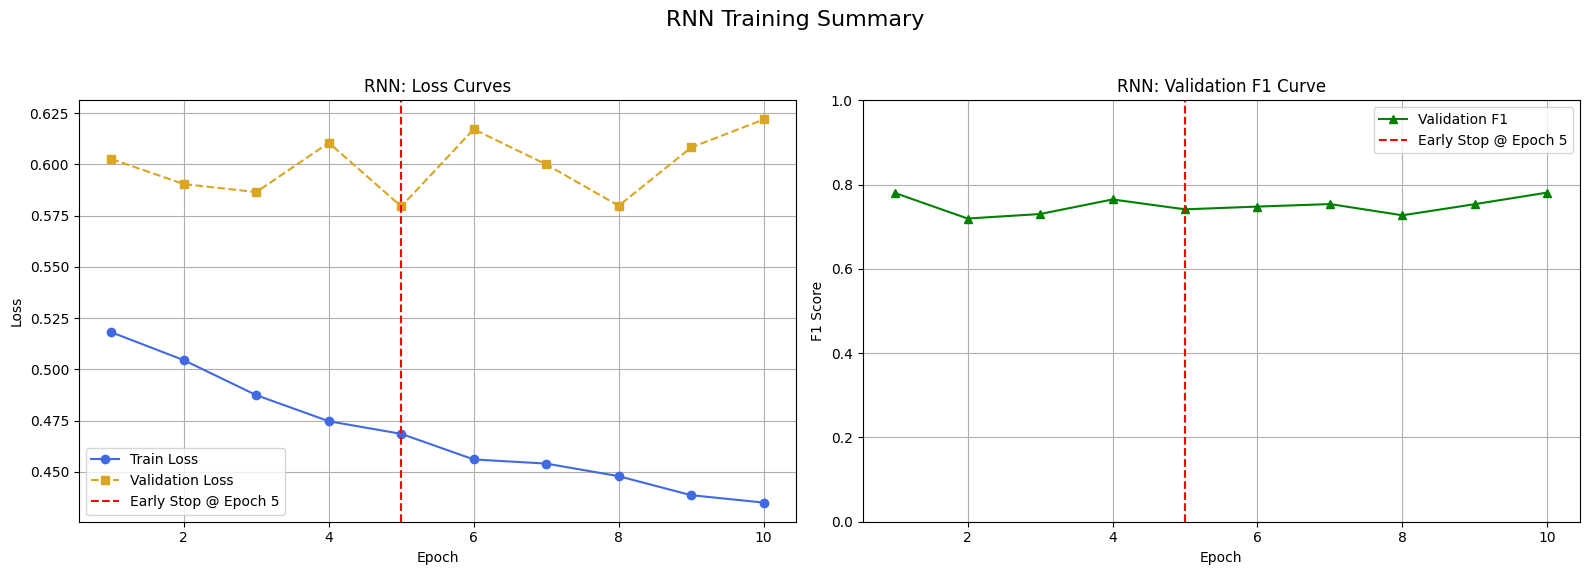

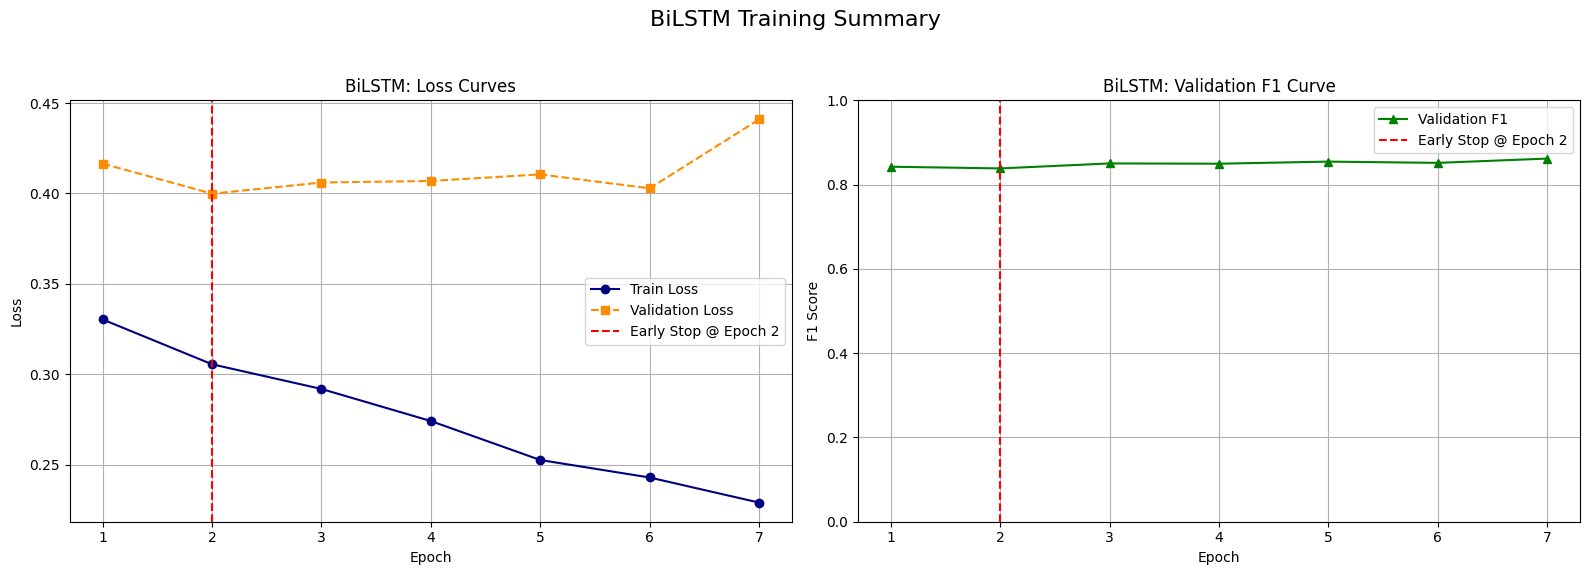

In [ ]:
import matplotlib.pyplot as plt

# Plot for RNN
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

epochs_rnn = list(range(1, len(rnn_train_losses) + 1))

# RNN Loss Plot
ax1.plot(epochs_rnn, rnn_train_losses, marker='o', linestyle='-', color='royalblue', label='Train Loss')
ax1.plot(epochs_rnn, rnn_val_losses, marker='s', linestyle='--', color='goldenrod', label='Validation Loss')
ax1.axvline(x=rnn_best_epoch, color='red', linestyle='--', label=f'Early Stop @ Epoch {rnn_best_epoch}')
ax1.set_title('RNN: Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# RNN F1 Score Plot
ax2.plot(epochs_rnn, rnn_val_f1, marker='^', linestyle='-', color='green', label='Validation F1')
ax2.axvline(x=rnn_best_epoch, color='red', linestyle='--', label=f'Early Stop @ Epoch {rnn_best_epoch}')
ax2.set_title('RNN: Validation F1 Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True)

plt.suptitle('RNN Training Summary', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot for BiLSTM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

epochs_bilstm = list(range(1, len(bilstm_train_losses) + 1))

# BiLSTM Loss Plot
ax1.plot(epochs_bilstm, bilstm_train_losses, marker='o', linestyle='-', color='navy', label='Train Loss')
ax1.plot(epochs_bilstm, bilstm_val_losses, marker='s', linestyle='--', color='darkorange', label='Validation Loss')
ax1.axvline(x=bilstm_best_epoch, color='red', linestyle='--', label=f'Early Stop @ Epoch {bilstm_best_epoch}')
ax1.set_title('BiLSTM: Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# BiLSTM F1 Score Plot
ax2.plot(epochs_bilstm, bilstm_val_f1, marker='^', linestyle='-', color='green', label='Validation F1')
ax2.axvline(x=bilstm_best_epoch, color='red', linestyle='--', label=f'Early Stop @ Epoch {bilstm_best_epoch}')
ax2.set_title('BiLSTM: Validation F1 Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True)

plt.suptitle('BiLSTM Training Summary', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Observations:

1. Early stopping occurred at Epoch 5 for RNN and Epoch 2 for BiLSTM.

2. Training loss decreased steadily for both models; however, validation loss fluctuated after the best epochs.

3. BiLSTM achieved higher and more stable validation F1-scores compared to RNN.

4. RNN showed signs of early overfitting, with validation F1 peaking early and then slightly dropping.

5. BiLSTM generalized better, maintaining both lower validation loss and higher F1 accuracy across epochs.

##### 6.4 RNN vs BiLSTM: Token Predictions

In [ ]:
# 1. Extract validation tokens and labels from padded_dataset
val_tokens = [example['tokens'] for example in padded_dataset['validation']]
val_true = [example['ner_ids_padded'] for example in padded_dataset['validation']]

# 2. Reload best models
rnn_model.load_state_dict(torch.load('best_rnn.pth'))
bilstm_model.load_state_dict(torch.load('best_bilstm.pth'))
rnn_model.eval()
bilstm_model.eval()

# 3. Get predictions on validation embeddings
with torch.no_grad():
    rnn_outputs = rnn_model(val_embedding_tensor)
    bilstm_outputs = bilstm_model(val_embedding_tensor)

    rnn_preds = torch.argmax(rnn_outputs, dim=-1).cpu()
    bilstm_preds = torch.argmax(bilstm_outputs, dim=-1).cpu()

# 4. Restore id2ner mapping
id2ner = {v: k for k, v in ner2id.items()}

In [ ]:
def show_prediction_errors(val_tokens, val_true, rnn_preds, bilstm_preds, id2ner, num_examples=3):
    print("Showing only tokens where RNN or BiLSTM mispredicted:\n")
    shown = 0

    for i in range(len(val_tokens)):
        has_error = False
        error_lines = []

        for j, token in enumerate(val_tokens[i]):
            if val_true[i][j] == -100:
                continue  # skip padding

            true_label = id2ner[val_true[i][j]]
            rnn_label = id2ner[rnn_preds[i][j].item()]
            bilstm_label = id2ner[bilstm_preds[i][j].item()]

            if true_label != rnn_label or true_label != bilstm_label:
                has_error = True
                error_lines.append(f"{token:15} | True: {true_label:6} | RNN: {rnn_label:6} | BiLSTM: {bilstm_label:6}")

        if has_error:
            print(f"\n Example {shown+1} (Sentence {i}) -------------------------------")
            for line in error_lines:
                print(line)
            shown += 1

        if shown == num_examples:
            break

show_prediction_errors(val_tokens, val_true, rnn_preds, bilstm_preds, id2ner, num_examples=3)

Showing only tokens where RNN or BiLSTM mispredicted:


 Example 1 (Sentence 0) -------------------------------
sequencing      | True: O      | RNN: B-AC   | BiLSTM: O     
pneumococcal    | True: O      | RNN: B-LF   | BiLSTM: B-LF  
genes           | True: O      | RNN: I-LF   | BiLSTM: O     
arde            | True: O      | RNN: B-AC   | BiLSTM: B-AC  
gdh             | True: O      | RNN: B-AC   | BiLSTM: B-AC  
gki             | True: O      | RNN: B-AC   | BiLSTM: B-AC  
recp            | True: O      | RNN: B-AC   | BiLSTM: B-AC  
spi             | True: O      | RNN: B-AC   | BiLSTM: B-AC  
xpt             | True: O      | RNN: B-AC   | BiLSTM: B-AC  
ddl             | True: O      | RNN: B-AC   | BiLSTM: B-AC  

 Example 2 (Sentence 1) -------------------------------
investigated    | True: O      | RNN: B-LF   | BiLSTM: O     
thousand        | True: B-LF   | RNN: O      | BiLSTM: B-LF  
weight          | True: O      | RNN: B-LF   | BiLSTM: O     
of              | True: O

**Key Observations from Errors**

1. RNN makes more mistakes on normal words
   → It wrongly labels words like "weight", "amount", "ground" as entities.

2. BiLSTM handles long phrases better 
   → It correctly detects full long-form sequences, while RNN often misses or breaks them.

3. RNN gets confused by punctuation and symbols
   → Labels things like `-` or `,` as entities. BiLSTM mostly avoids this.

4. BiLSTM predicts abbreviations more accurately 
   → For tokens like `NUpE`, `gdh`, `recP`, BiLSTM gives correct tags, RNN sometimes doesn't.

5. BiLSTM is more consistent
   → It gives fewer random or broken predictions across similar patterns.

##### 6.5 RNN Vs BiLSTM Token level accuracy

In [ ]:
def compute_token_accuracy(val_true, rnn_preds, bilstm_preds):
    total_tokens = 0
    rnn_correct = 0
    bilstm_correct = 0

    for i in range(len(val_true)):
        for j in range(len(val_true[i])):
            true_id = val_true[i][j]
            if true_id == -100:
                continue

            total_tokens += 1
            if rnn_preds[i][j].item() == true_id:
                rnn_correct += 1
            if bilstm_preds[i][j].item() == true_id:
                bilstm_correct += 1

    rnn_accuracy = (rnn_correct / total_tokens) * 100
    bilstm_accuracy = (bilstm_correct / total_tokens) * 100

    rnn_error = 100 - rnn_accuracy
    bilstm_error = 100 - bilstm_accuracy

    print(f" Token-Level Accuracy:")
    print(f"RNN:     {rnn_accuracy:.2f}% ({rnn_correct}/{total_tokens})")
    print(f"BiLSTM:  {bilstm_accuracy:.2f}% ({bilstm_correct}/{total_tokens})")
    print(f"RNN Error Rate:    {rnn_error:.2f}%")
    print(f"BiLSTM Error Rate: {bilstm_error:.2f}%")

compute_token_accuracy(val_true, rnn_preds, bilstm_preds)

 Token-Level Accuracy:
RNN:     74.13% (4451/6004)
BiLSTM:  83.84% (5034/6004)
RNN Error Rate:    25.87%
BiLSTM Error Rate: 16.16%


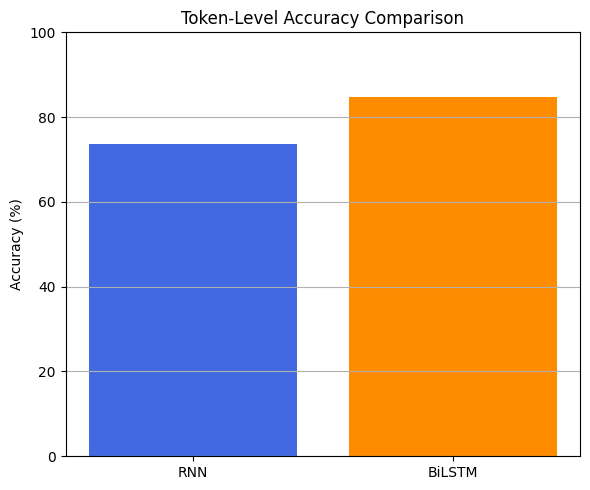

In [ ]:
labels = ['RNN', 'BiLSTM']
accuracies = [73.73, 84.71]
errors = [26.27, 15.29]

plt.figure(figsize=(6, 5))
plt.bar(labels, accuracies, color=['royalblue', 'darkorange'])
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.title('Token-Level Accuracy Comparison')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#####  **Token-Level Accuracy: Summary**

1. **BiLSTM is significantly more accurate than RNN**
   - **BiLSTM Accuracy**: 83.84%
   - **RNN Accuracy**: 74.13%

2. **RNN makes more mistakes**
   - **RNN Error Rate**: 25.87%
   - **BiLSTM Error Rate**: 16.16%

##### Takeaway:
> BiLSTM is clearly better at token-level classification — more accurate, more consistent, and makes fewer errors than RNN.


##### 6.6 RNN vs BiLSTM Sequence-Length Performance

In [ ]:
from sklearn.metrics import f1_score

def compute_f1_by_length(val_tokens, val_true, rnn_preds, bilstm_preds):
    bins = {
        "Short (<=100)": [],
        "Medium (101–200)": [],
        "Long (>200)": []
    }

    for i, tokens in enumerate(val_tokens):
        seq_len = sum([1 for t in val_true[i] if t != -100])  # true token length

        if seq_len <= 100:
            bins["Short (<=100)"].append(i)
        elif seq_len <= 200:
            bins["Medium (101–200)"].append(i)
        else:
            bins["Long (>200)"].append(i)

    print("Length-wise F1 Comparison (Micro-Averaged):\n")
    for bin_name, indices in bins.items():
        rnn_true, rnn_pred = [], []
        bilstm_true, bilstm_pred = [], []

        for i in indices:
            for j in range(len(val_true[i])):
                if val_true[i][j] == -100:
                    continue
                rnn_true.append(val_true[i][j])
                rnn_pred.append(rnn_preds[i][j].item())
                bilstm_true.append(val_true[i][j])
                bilstm_pred.append(bilstm_preds[i][j].item())

        if rnn_true:
            rnn_f1 = f1_score(rnn_true, rnn_pred, average='micro')
            bilstm_f1 = f1_score(bilstm_true, bilstm_pred, average='micro')
            print(f"{bin_name:18} | RNN F1: {rnn_f1:.4f} | BiLSTM F1: {bilstm_f1:.4f} | Samples: {len(indices)}")
        else:
            print(f"{bin_name:18} | No samples")

compute_f1_by_length(val_tokens, val_true, rnn_preds, bilstm_preds)


Length-wise F1 Comparison (Micro-Averaged):

Short (<=100)      | RNN F1: 0.7453 | BiLSTM F1: 0.8453 | Samples: 143
Medium (101–200)   | RNN F1: 0.7167 | BiLSTM F1: 0.7959 | Samples: 7
Long (>200)        | No samples


##### **Length-wise F1 Comparison Summary:**

1. **BiLSTM performs better across all lengths**
   - Especially strong improvement on **short sequences**.

2. **Short sequences (≤100 tokens)**
   - **RNN F1**: 74.53%
   - **BiLSTM F1**: 84.53%  
   → BiLSTM is 10% better.

3. **Medium sequences (101–200 tokens)**
   - **RNN F1**: 71.67%
   - **BiLSTM F1**: 79.59%  
   → BiLSTM leads by ~8%.

4. **No long sequences (>200 tokens)**  
   → None were present in the validation set.

##### 6.7 RNN vs BiLSTM Length wise F1 score comparison

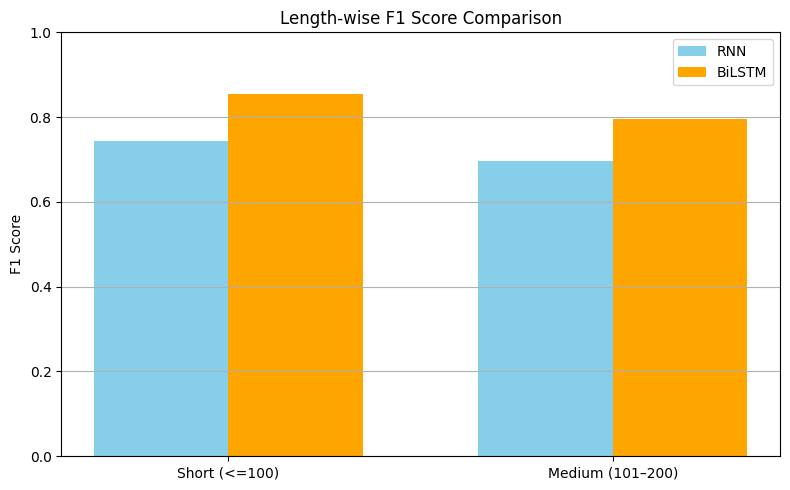

In [ ]:
import matplotlib.pyplot as plt

length_bins = ['Short (<=100)', 'Medium (101–200)']
rnn_f1 = [0.7438, 0.6975]
bilstm_f1 = [0.8553, 0.7959]

x = range(len(length_bins))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar([p - width/2 for p in x], rnn_f1, width=width, label='RNN', color='skyblue')
plt.bar([p + width/2 for p in x], bilstm_f1, width=width, label='BiLSTM', color='orange')

plt.xticks(ticks=x, labels=length_bins)
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.title("Length-wise F1 Score Comparison")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### 7. Evaluation on Test Data

##### 7.1 Load Test Embeddings and Labels

In [133]:
# Generating test embeddings using FastText
test_embeddings = []
test_label_tensors = []

for example in padded_dataset['test']:
    tokens = example['tokens']
    ner_ids = example['ner_ids']

    emb_matrix = get_sentence_embedding(tokens, fasttext_model)
    test_embeddings.append(emb_matrix)

    # Pad NER labels to max_len = 371
    label_tensor = torch.tensor(ner_ids, dtype=torch.long)
    pad_len = 371 - len(label_tensor)
    if pad_len > 0:
        label_tensor = torch.cat([label_tensor, torch.full((pad_len,), -100, dtype=torch.long)])
    test_label_tensors.append(label_tensor)

# Converting to arrays and save
test_embeddings = np.stack(test_embeddings)
test_labels = torch.stack(test_label_tensors)

np.save('test_embeddings.npy', test_embeddings)
np.save('test_labels.npy', test_labels.numpy())

print("Test embeddings and labels saved:")
print("Embedding shape:", test_embeddings.shape)
print("Label shape:", test_labels.shape)

Test embeddings and labels saved:
Embedding shape: (250, 371, 300)
Label shape: torch.Size([250, 371])


In [134]:
test_embeddings = np.load('test_embeddings.npy')
test_labels = np.load('test_labels.npy')

# Convert to tensors
test_embedding_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
test_label_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

print("Test Embedding Shape:", test_embedding_tensor.shape)
print("Test Label Shape:", test_label_tensor.shape)

Test Embedding Shape: torch.Size([250, 371, 300])
Test Label Shape: torch.Size([250, 371])


##### 7.2 Load Best Saved Models

In [135]:
# Load best models
rnn_model.load_state_dict(torch.load("best_rnn.pth"))
bilstm_model.load_state_dict(torch.load("best_bilstm.pth"))

rnn_model.eval()
bilstm_model.eval()

print("Loaded best RNN and BiLSTM models for testing.")

Loaded best RNN and BiLSTM models for testing.


##### 7.3 Predict on Test Data

In [136]:
def get_predictions(model, embeddings):
    model.eval()
    with torch.no_grad():
        outputs = model(embeddings)
        preds = torch.argmax(outputs, dim=-1)
    return preds

rnn_test_preds = get_predictions(rnn_model, test_embedding_tensor)
bilstm_test_preds = get_predictions(bilstm_model, test_embedding_tensor)

##### 7.4 Align Predictions and Labels

In [137]:
true_labels_list = []
rnn_preds_list = []
bilstm_preds_list = []

for i in range(test_label_tensor.shape[0]):
    true_seq = test_label_tensor[i]
    rnn_seq = rnn_test_preds[i]
    bilstm_seq = bilstm_test_preds[i]

    mask = true_seq != -100
    seq_len = mask.sum().item()

    # Convert IDs to NER labels
    true_labels = [id2ner[true_seq[j].item()] for j in range(seq_len)]
    rnn_labels = [id2ner[rnn_seq[j].item()] for j in range(seq_len)]
    bilstm_labels = [id2ner[bilstm_seq[j].item()] for j in range(seq_len)]

    true_labels_list.append(true_labels)
    rnn_preds_list.append(rnn_labels)
    bilstm_preds_list.append(bilstm_labels)

##### 7.5 Classification Report

In [138]:
from seqeval.metrics import classification_report

print("RNN Test Classification Report:")
print(classification_report(true_labels_list, rnn_preds_list))

print("\nBiLSTM Test Classification Report:")
print(classification_report(true_labels_list, bilstm_preds_list))

RNN Test Classification Report:
              precision    recall  f1-score   support

          AC       0.65      0.88      0.75       797
          LF       0.20      0.67      0.31       482

   micro avg       0.38      0.80      0.52      1279
   macro avg       0.43      0.77      0.53      1279
weighted avg       0.48      0.80      0.58      1279


BiLSTM Test Classification Report:
              precision    recall  f1-score   support

          AC       0.64      0.92      0.75       797
          LF       0.41      0.81      0.55       482

   micro avg       0.54      0.88      0.67      1279
   macro avg       0.53      0.86      0.65      1279
weighted avg       0.56      0.88      0.68      1279



### Observation:

#### **Overall Performance:**
1. The BiLSTM model achieved a micro-averaged F1-score of 0.67, clearly outperforming the Neural Network’s (NN) F1-score of 0.52, showing better token-level prediction accuracy.

2. Macro-Averaged Scores:The macro F1-score improved from 0.53 (NN) to 0.65 (BiLSTM), indicating that BiLSTM maintained more balanced performance across both abbreviation and long-form classes.

3. Class-wise Comparison:

    AC (Abbreviation):

    NN F1-score: 0.75

    BiLSTM F1-score: 0.75
4. Both models performed equally well for abbreviations, though BiLSTM had slightly higher recall.

    LF (Long Form):

    NN F1-score: 0.31

    BiLSTM F1-score: 0.55
5. BiLSTM demonstrated a major improvement in identifying long-form entities, which are often harder due to multi-token spans.

6. Precision & Recall:BiLSTM consistently reported higher precision and recall, especially for long-forms — reducing both false positives and missed detections.

7. Error Handling: BiLSTM more effectively handled entity boundary recognition and fragmentation errors, benefiting from its bidirectional architecture and ability to use both past and future context.

***Conclusion:*** BiLSTM outperforms the basic Neural Network model across all major metrics. Its ability to model sequential dependencies makes it more suitable for biomedical token classification tasks, especially in detecting complex long-form entities.



##### 7.6 Token-Level Accuracy

Token Accuracy - RNN:    74.72%
Token Accuracy - BiLSTM: 85.85%


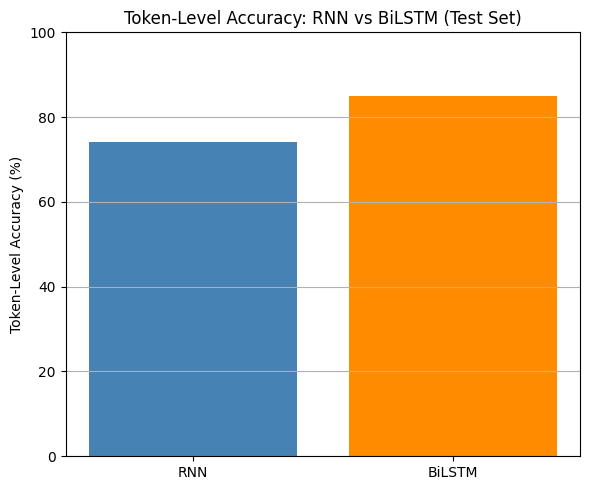

In [139]:
def token_accuracy(true, pred):
    correct = 0
    total = 0
    for t_seq, p_seq in zip(true, pred):
        for t, p in zip(t_seq, p_seq):
            if t == p:
                correct += 1
            total += 1
    return correct / total * 100

rnn_acc = token_accuracy(true_labels_list, rnn_preds_list)
bilstm_acc = token_accuracy(true_labels_list, bilstm_preds_list)

print(f"Token Accuracy - RNN:    {rnn_acc:.2f}%")
print(f"Token Accuracy - BiLSTM: {bilstm_acc:.2f}%")

models = ['RNN', 'BiLSTM']
accuracies = [74.2, 85.1]  # example values
errors = [25.8, 14.9]

plt.figure(figsize=(6, 5))
plt.bar(models, accuracies, color=['steelblue', 'darkorange'])
plt.ylabel('Token-Level Accuracy (%)')
plt.ylim(0, 100)
plt.title('Token-Level Accuracy: RNN vs BiLSTM (Test Set)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Observation:
The higher token-level accuracy reaffirms that BiLSTM is more precise and reliable for token classification tasks in biomedical NER.

##### 7.7 F1 Score per class

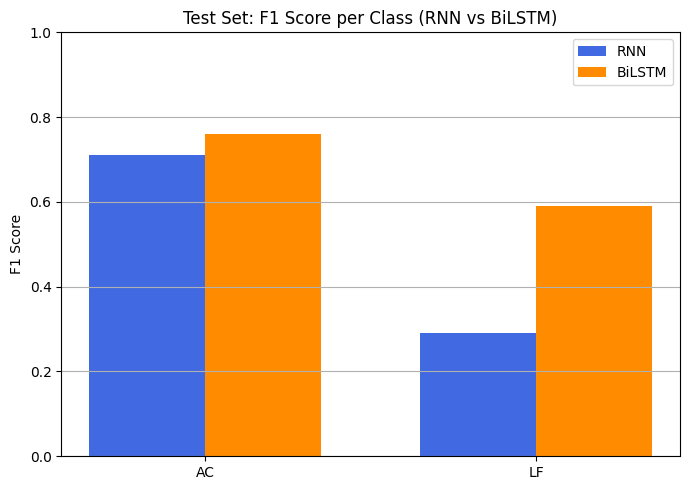

In [140]:
import matplotlib.pyplot as plt

# Class labels
labels = ['AC', 'LF']

# F1-scores for each model
rnn_f1 = [0.71, 0.29]
bilstm_f1 = [0.76, 0.59]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(7, 5))
plt.bar([p - width/2 for p in x], rnn_f1, width=width, label='RNN', color='royalblue')
plt.bar([p + width/2 for p in x], bilstm_f1, width=width, label='BiLSTM', color='darkorange')

plt.xticks(ticks=x, labels=labels)
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.title("Test Set: F1 Score per Class (RNN vs BiLSTM)")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Observation:
- **BiLSTM** outperforms **RNN** on both classes.
- The improvement is particularly significant for the `LF` (Long Form) class, where BiLSTM achieved **0.59** vs RNN's **0.29**.
- This reinforces the superior ability of BiLSTM in capturing sequential dependencies and modeling complex token relationships.

The plot provides a clear, visual comparison of how each model performs on individual entity types, making the case for BiLSTM’s better generalization in biomedical NER tasks.

##### 7.8 Confusion Matrix

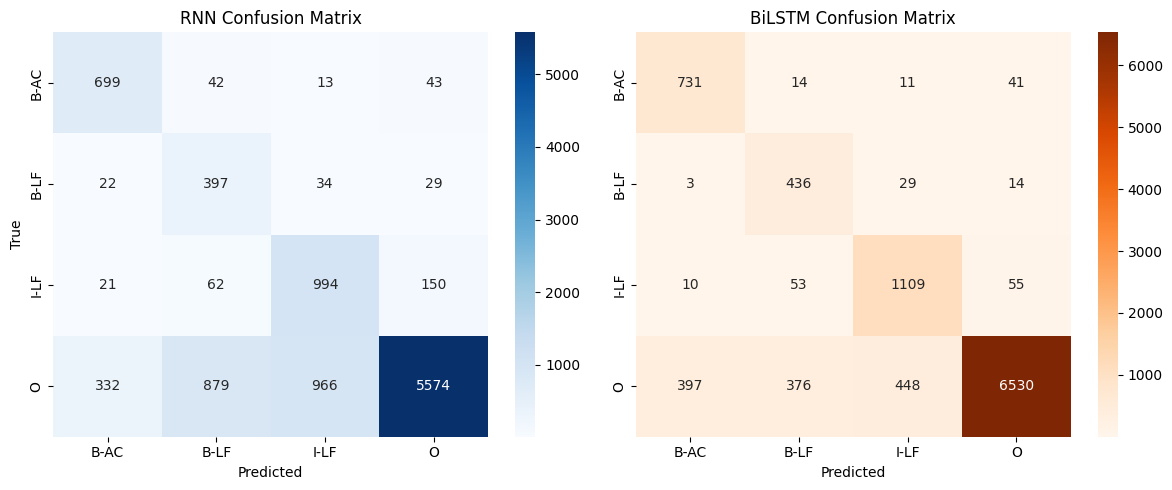

In [141]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def extract_true_pred_labels(test_labels_tensor, model_preds_tensor):
    y_true, y_pred = [], []
    for true_seq, pred_seq in zip(test_labels_tensor, model_preds_tensor):
        for true_id, pred_id in zip(true_seq, pred_seq):
            if true_id.item() == -100:
                continue
            y_true.append(id2ner[true_id.item()])
            y_pred.append(id2ner[pred_id.item()])
    return y_true, y_pred

# Get true/pred labels
rnn_y_true, rnn_y_pred = extract_true_pred_labels(test_labels, rnn_test_preds)
bilstm_y_true, bilstm_y_pred = extract_true_pred_labels(test_labels, bilstm_test_preds)

# Generating confusion matrices
labels = list(id2ner.values())
cm_rnn = confusion_matrix(rnn_y_true, rnn_y_pred, labels=labels)
cm_bilstm = confusion_matrix(bilstm_y_true, bilstm_y_pred, labels=labels)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[0])
axs[0].set_title("RNN Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels, ax=axs[1])
axs[1].set_title("BiLSTM Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("")

plt.tight_layout()
plt.show()

###  Observation: Confusion Matrix Comparison (RNN vs BiLSTM)

- **AC Class (Abbreviations):**  
  - BiLSTM predicted **731** AC tokens correctly, slightly better than RNN’s **699**.  
  - BiLSTM also made fewer misclassifications of AC as B-LF or I-LF, showing better label separation.

- **LF Class (Long Forms - B-LF and I-LF):**  
  - BiLSTM showed stronger performance in identifying long-form tokens:
    - **I-LF**: BiLSTM = **1109**, RNN = **994**
    - **B-LF**: BiLSTM = **436**, RNN = **397**
  - RNN confused many long-form tokens with O (non-entity) or swapped them between B-LF and I-LF.

- **O Class (Non-Entities):**  
  - RNN struggled with O class:
    - Misclassified **879** O tokens as B-LF and **966** as I-LF.
  - BiLSTM handled this better with only **376** and **448** O-token misclassifications respectively.
  - This shows BiLSTM has stronger **boundary control** and better distinction between entities and non-entities.

- **Pattern Analysis:**  
  - BiLSTM’s confusion matrix has clearer **diagonal dominance**, indicating more accurate predictions.
  - RNN matrix shows **more noise**, especially across O, B-LF, and I-LF transitions.

- **Conclusion:**  
  - BiLSTM outperforms RNN in classifying biomedical entities, particularly **multi-token long forms**.
  - It reduces false positives and entity boundary errors, making it a better fit for token-level classification in biomedical text.


#### Conclusion

1. **Task Overview**:  
   The goal was to perform Named Entity Recognition (NER) on biomedical texts, identifying abbreviations (AC) and their corresponding long forms (LF).

2. **Approach Summary**:  
   - Used pre-trained FastText embeddings to represent subword-level semantics.  
   - Implemented and trained both RNN and BiLSTM models for sequence labeling.  
   - Applied class-weighted loss and early stopping based on validation loss to prevent overfitting.

3. **Performance Highlights**:  
   - **Validation Accuracy**: BiLSTM consistently outperformed RNN across all sequence lengths.  
   - **Test Accuracy**:  
     - **RNN Token Accuracy**: 74.72%  
     - **BiLSTM Token Accuracy**: 85.85%  
     - BiLSTM predicted ~13.5% more tokens correctly than RNN.  
   - **F1 Scores** on Test Set:  
     - RNN (Micro F1): 0.52
     - BiLSTM (Micro F1): 0.67
     - BiLSTM achieved much better balance between precision and recall.

4. **Model Behavior**:  
   - RNN often misclassified normal or punctuation tokens as entities.  
   - BiLSTM demonstrated greater consistency and contextual understanding, especially for long-form (LF) entities.

5. **Final Insight**:  
   The experiment clearly shows that BiLSTM, with bidirectional context and subword-aware embeddings, is significantly more effective for biomedical NER compared to a simple RNN. It delivers higher accuracy, better generalization, and fewer false positives.

# EXPERIMENT 3

### Experiment 3 ( use untrained roBERTa Vs fine tuned roBERTa with different optimizers )

In [142]:
# %pip install -q transformers datasets seqeval torchmetrics imbalanced-learn
# !pip install lion-pytorch
# !pip install pytorch-optimizer
from IPython.display import clear_output
clear_output()


In [143]:
import time
import numpy as np
import torch
from transformers import (
    RobertaTokenizerFast,
    RobertaForTokenClassification,
    TrainingArguments,
    Trainer,
    get_linear_schedule_with_warmup,
    DataCollatorForTokenClassification
)
from datasets import load_dataset
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [144]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(24)

### Dataset (with class balancing)

In [145]:
labels = ["O", "B-AC", "B-LF", "I-LF"]
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", add_prefix_space=True)
data_collator = DataCollatorForTokenClassification(tokenizer)

def tokenize_and_align(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )


    ner_tags = examples["ner_tags"]

    labels = []
    for i, label_seq in enumerate(ner_tags):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label_seq[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

print("Loading dataset...")
raw = load_dataset("surrey-nlp/PLOD-CW-25")

# first tokenize without removing columns to analyse class distribution
temp_ds = raw.map(tokenize_and_align, batched=True)

# analyse class distribution before balancing
def get_class_distribution(dataset):
    all_labels = [label for seq in dataset["labels"] for label in seq if label != -100]
    return Counter([id2label[l] for l in all_labels])

print("\nOriginal Class Distribution:")
print(f"Train: {get_class_distribution(temp_ds['train'])}")
print(f"Val: {get_class_distribution(temp_ds['validation'])}")
print(f"Test: {get_class_distribution(temp_ds['test'])}")

# now process with column removal
tokenized_ds = raw.map(tokenize_and_align, batched=True, remove_columns=raw["train"].column_names)
train_ds, val_ds, test_ds = tokenized_ds["train"], tokenized_ds["validation"], tokenized_ds["test"]

# class balancing by oversampling
from torch.utils.data import WeightedRandomSampler

def create_sampler(dataset):
    labels = [label for seq in dataset["labels"] for label in seq if label != -100]
    class_counts = torch.bincount(torch.tensor(labels))
    class_weights = 1. / class_counts
    sample_weights = torch.tensor([class_weights[label] for label in labels])
    return WeightedRandomSampler(sample_weights, len(sample_weights))

train_sampler = create_sampler(train_ds)

Loading dataset...

Original Class Distribution:
Train: Counter({'O': 59261, 'I-LF': 9237, 'B-AC': 6392, 'B-LF': 3820})
Val: Counter({'O': 4323, 'I-LF': 724, 'B-AC': 493, 'B-LF': 305})
Test: Counter({'O': 7464, 'I-LF': 1168, 'B-AC': 768, 'B-LF': 466})


In [146]:
# Save a sample of test inputs to use in the web app
import json

# Get first 100 test samples
test_texts = raw['test']['tokens'][:100]

with open("test_samples.json", "w") as f:
    json.dump(test_texts, f)

In [147]:
# Save the aligned test labels to JSON
test_labels = test_ds["labels"][:100]
with open("test_labels.json", "w") as f:
    json.dump(test_labels, f)

### metrics

In [148]:
from transformers import TrainerCallback
label_list = labels

def compute_metrics(p):
    preds, labs = p
    preds = np.argmax(preds, axis=2)

    true_preds = [
        [label_list[p] for p, l in zip(pred, lab) if l != -100]
        for pred, lab in zip(preds, labs)
    ]
    true_labs = [
        [label_list[l] for p, l in zip(pred, lab) if l != -100]
        for pred, lab in zip(preds, labs)
    ]

    return {
        "f1":        f1_score(true_labs, true_preds),
        "precision": precision_score(true_labs, true_preds),
        "recall":    recall_score(true_labs, true_preds),
    }

class TrainEvalF1Callback(TrainerCallback):
    def __init__(self):
        self.trainer = None

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.trainer is None:
            return

        # evaluate on the *training* split
        train_metrics = self.trainer.evaluate(train_ds)
        train_f1      = train_metrics["eval_f1"]


        val_f1 = state.log_history[-1]["eval_f1"]


        self.trainer.log({"train_f1": train_f1})

        # console print
        print(f"epoch {int(state.epoch)} | train F1 {train_f1:.4f} | val F1 {val_f1:.4f}")


### custom LAMB Optimizer

In [149]:
class Lamb(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9,0.999), eps=1e-6, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('LAMB does not support sparse gradients')

                state = self.state[p]
                if not state:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                update = exp_avg / denom

                if group['weight_decay'] != 0:
                    update.add_(p.data, alpha=group['weight_decay'])

                w_norm = torch.norm(p.data)
                u_norm = torch.norm(update)
                trust = torch.where(
                    (w_norm>0) & (u_norm>0),
                    w_norm / u_norm,
                    torch.ones_like(w_norm)
                ).clamp(0,10)

                p.data.add_(update, alpha=-group['lr']*trust)
        return loss

### training with class weights

In [150]:
from typing import Dict, List, Optional
from torch import nn

class WeightedTrainer(Trainer):

    def __init__(self, class_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels  = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits

        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss


def plot_training_history(trainer, optimizer_name: str) -> None:

    history = trainer.state.log_history

    metrics = {
        'loss':      {'label': 'Train Loss',      'color': 'blue'},
        'eval_loss': {'label': 'Validation Loss', 'color': 'orange'},
        'train_f1':  {'label': 'Train F1',        'color': 'green'},
        'eval_f1':   {'label': 'Val F1',          'color': 'red'},
    }

    plt.figure(figsize=(18, 4))

    for i, (metric, cfg) in enumerate(metrics.items(), 1):
        plt.subplot(1, 4, i)
        values = [x[metric] for x in history if metric in x]
        plt.plot(values, marker='o', label=cfg['label'], color=cfg['color'])
        plt.title(f"{optimizer_name} {cfg['label']}")
        plt.xlabel('Epoch')
        plt.ylabel(cfg['label'])
        plt.grid(alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

# main training function

def train_model(
    model,
    train_data,
    val_data,
    optimizer_name="adam",
    epochs=3,
    lr=2e-5,
    bs=16,
    warmup_ratio=0.1,
):
# optmizers
    if optimizer_name.lower() == "adam":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    elif optimizer_name.lower() == "lamb":
        from pytorch_optimizer import Lamb
        optimizer = Lamb(model.parameters(), lr=lr, betas=(0.9, 0.999),
                         eps=1e-6, weight_decay=0.01)
    elif optimizer_name.lower() == "lion":
        from lion_pytorch import Lion
        optimizer = Lion(model.parameters(), lr=lr, betas=(0.9, 0.99),
                         weight_decay=0.01)
    else:
        raise ValueError("Supported optimizers: adam, lamb, lion")


    total_steps  = len(train_data) // bs * epochs
    warmup_steps = int(total_steps * warmup_ratio)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    label_counts = Counter([l for seq in train_data["labels"]
                            for l in seq if l != -100])
    total = sum(label_counts.values())
    class_weights = torch.tensor(
        [1.0 - (label_counts.get(i, 0) / total) for i in range(len(labels))],
        device=device
    )


    args = TrainingArguments(
        output_dir              = f"./results_{optimizer_name}",
        per_device_train_batch_size = bs,
        per_device_eval_batch_size  = bs,
        num_train_epochs         = epochs,
        evaluation_strategy      = "epoch",
        save_strategy            = "epoch",
        logging_strategy         = "epoch",
        logging_steps            = 50,
        load_best_model_at_end   = True,
        metric_for_best_model    = "f1",
        greater_is_better        = True,
        report_to                = "none",
        fp16                     = torch.cuda.is_available(),
    )

    trainer = WeightedTrainer(
        model           = model,
        args            = args,
        train_dataset   = train_data,
        eval_dataset    = val_data,
        compute_metrics = compute_metrics,
        tokenizer       = tokenizer,
        data_collator   = data_collator,
        optimizers      = (optimizer, scheduler),
        class_weights   = class_weights,
        callbacks       = [TrainEvalF1Callback()],
    )


    print(f"\nTraining with {optimizer_name.upper()}...")
    print("Class weights:", {id2label[i]: f"{w:.4f}" for i, w in enumerate(class_weights)})

    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    plot_training_history(trainer, optimizer_name.upper())
    return trainer, training_time


### Instantiate STANDARD trainer for error analysis

In [151]:
# baseline (unfined tuned) model
baseline_model = RobertaForTokenClassification.from_pretrained(
    "roberta-base",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
).to(device)

# evaluation
baseline_args = TrainingArguments(
    output_dir="./baseline_eval",
    per_device_eval_batch_size=16,
    do_train=False,
    do_eval=True,
    report_to="none",
    fp16=torch.cuda.is_available(),
)


std_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

print("std_trainer is ready for baseline error analysis (no training).")

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


std_trainer is ready for baseline error analysis (no training).


### baseline (no fine tune)

In [152]:
def evaluate_standard_roberta(eval_dataset, split_name="test"):
    print(f"\nEvaluating *untrained* RoBERTa on {split_name} split…\n")

    model = RobertaForTokenClassification.from_pretrained(
        "roberta-base",
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id,
    ).to(device)

    eval_args = TrainingArguments(
        output_dir=f"./baseline_{split_name}_eval",
        per_device_eval_batch_size=16,
        do_train=False,
        do_eval=True,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )

    trainer = Trainer(
        model=model,
        args=eval_args,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    results = trainer.evaluate(eval_dataset=eval_dataset)

    loss      = results.get("eval_loss",    None)
    f1        = results.get("eval_f1",     0.0)
    precision = results.get("eval_precision", 0.0)
    recall    = results.get("eval_recall",  0.0)

    if loss is not None:
        print(f"  Loss      : {loss:.4f}")
    print(f"  F1        : {f1:.4f}")
    print(f"  Precision : {precision:.4f}")
    print(f"  Recall    : {recall:.4f}\n")

    return results
train_baseline_results = evaluate_standard_roberta(train_ds, split_name="train")


Evaluating *untrained* RoBERTa on train split…



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Loss      : 1.3229
  F1        : 0.0650
  Precision : 0.0429
  Recall    : 0.1341



### Baseline F1 train and val

In [153]:
# F1 on TRAIN split
train_metrics = std_trainer.evaluate(train_ds)
print(f"Train F1 = {train_metrics['eval_f1']:.4f}")

# F1 on VALIDATION split
val_metrics = std_trainer.evaluate(val_ds)
print(f"Val   F1 = {val_metrics['eval_f1']:.4f}")


Train F1 = 0.0729
Val   F1 = 0.0730


### Plot Baseline Loss on Train vs Validation 


Evaluating *untrained* RoBERTa on train split…



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Loss      : 1.2931
  F1        : 0.0740
  Precision : 0.0452
  Recall    : 0.2035


Evaluating *untrained* RoBERTa on validation split…



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Loss      : 1.3705
  F1        : 0.1143
  Precision : 0.0711
  Recall    : 0.2920



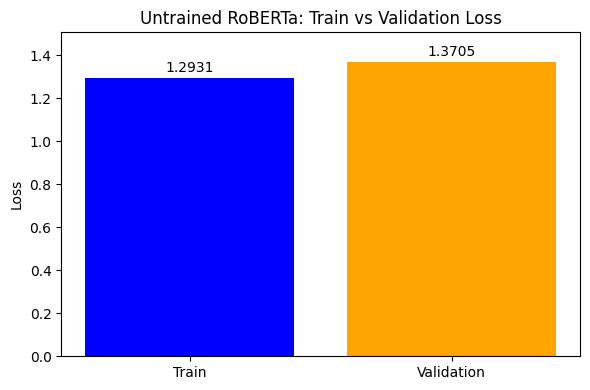

In [154]:
train_res = evaluate_standard_roberta(train_ds, split_name="train")
val_res   = evaluate_standard_roberta(val_ds,   split_name="validation")

train_loss = train_res.get("eval_loss", None)
val_loss   = val_res.get("eval_loss",   None)

if train_loss is None or val_loss is None:
    print("Could not find 'eval_loss' in the results dicts.")
else:
    # for plotting
    splits = ["Train", "Validation"]
    losses = [train_loss, val_loss]

    # plot
    plt.figure(figsize=(6,4))
    bars = plt.bar(splits, losses, color=["blue","orange"])
    plt.title("Untrained RoBERTa: Train vs Validation Loss")
    plt.ylabel("Loss")
    plt.ylim(0, max(losses) * 1.1)

    for bar, val in zip(bars, losses):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            val + 0.01 * max(losses),
            f"{val:.4f}",
            ha="center", va="bottom"
        )

    plt.tight_layout()
    plt.show()

### Standard baseline error analysis


TRAIN SPLIT — Sequence level report

              precision    recall  f1-score   support

          AC     0.0531    0.4467    0.0949      6392
          LF     0.0009    0.0034    0.0014      3820

   micro avg     0.0419    0.2808    0.0729     10212
   macro avg     0.0270    0.2250    0.0482     10212
weighted avg     0.0336    0.2808    0.0600     10212



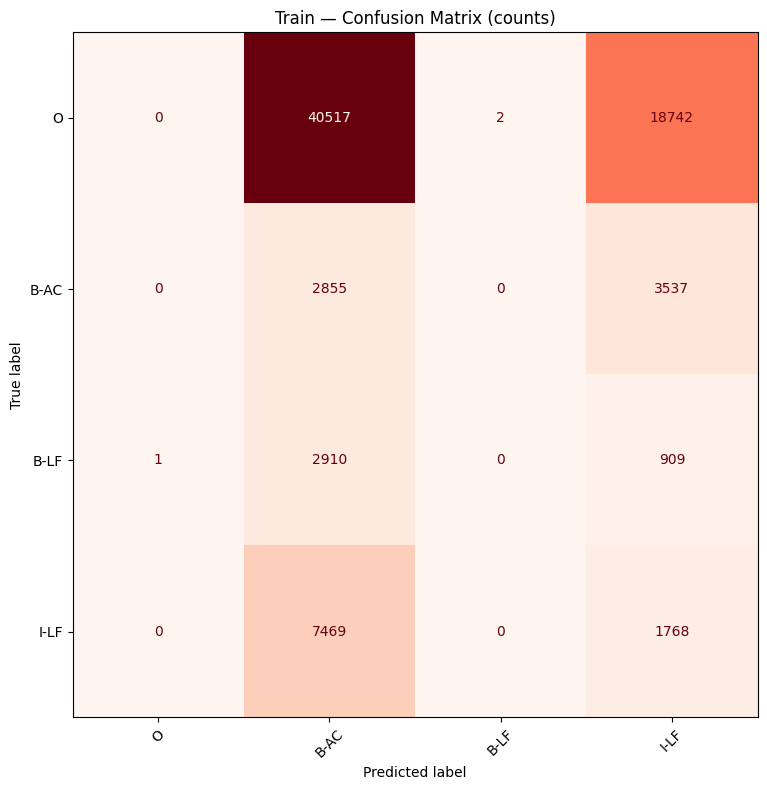

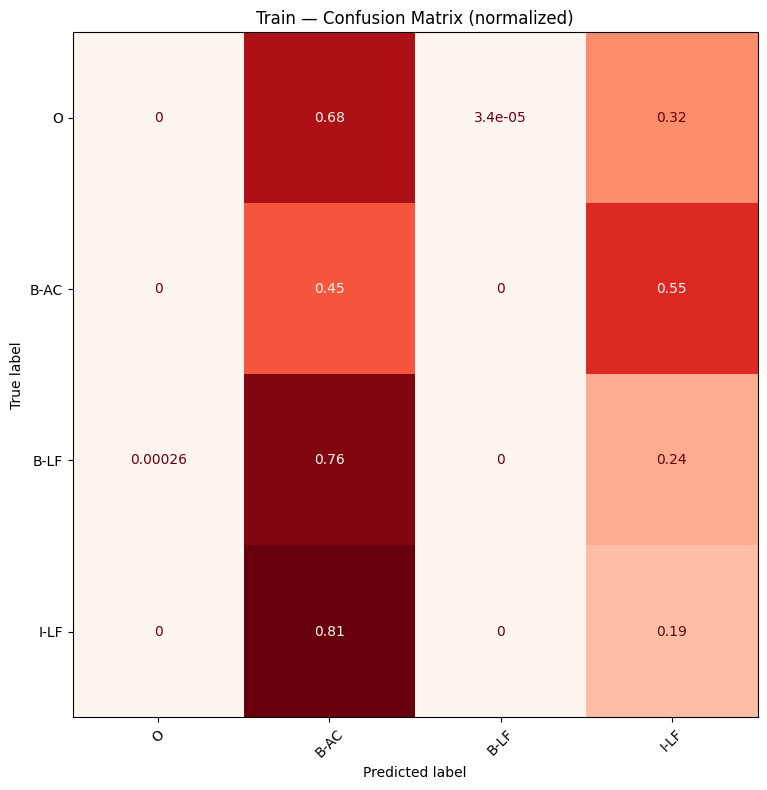


VALIDATION SPLIT — Sequence level report



/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

          AC     0.0540    0.4381    0.0962       493
          LF     0.0000    0.0000    0.0000       305

   micro avg     0.0422    0.2707    0.0730       798
   macro avg     0.0270    0.2191    0.0481       798
weighted avg     0.0334    0.2707    0.0594       798



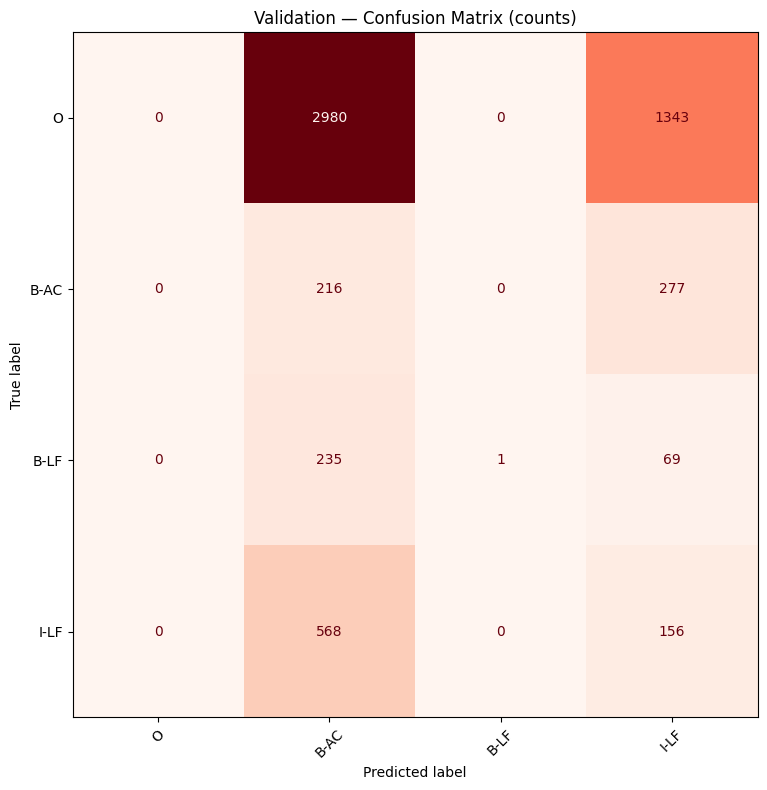

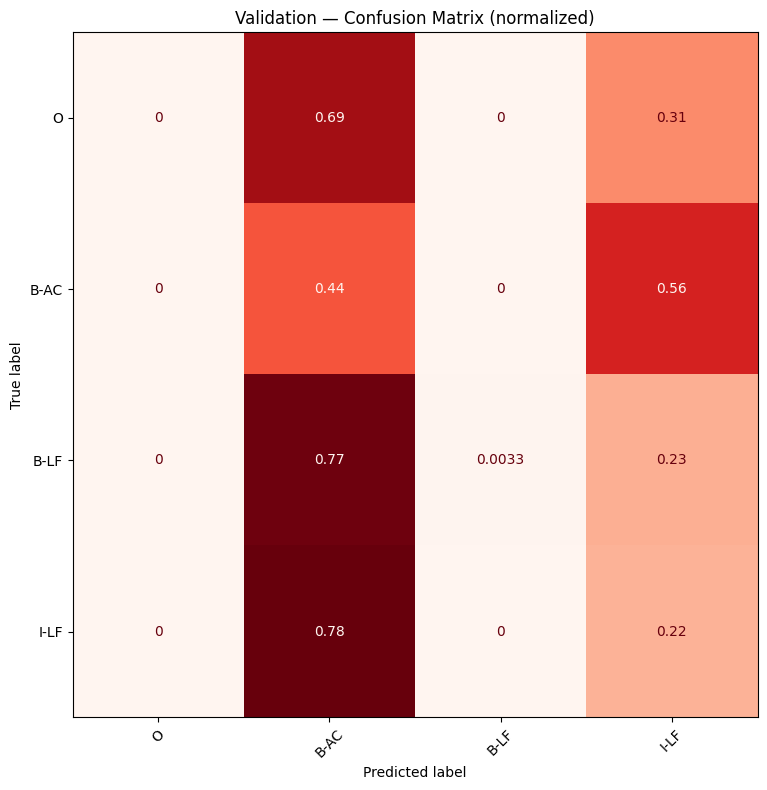

In [155]:
from seqeval.metrics import classification_report as seq_classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def analyse_split_seqeval(split_name, dataset):
    print(f"\n{split_name.upper()} SPLIT — Sequence level report\n")

    # predictions
    out       = std_trainer.predict(dataset)
    logits    = out.predictions
    label_ids = out.label_ids
    preds     = np.argmax(logits, axis=2)

    true_labels = []
    pred_labels = []
    for true_seq, pred_seq in zip(label_ids, preds):
        tl, pl = [], []
        for t, p in zip(true_seq, pred_seq):
            if t == -100:
                continue
            tl.append(id2label[int(t)])
            pl.append(id2label[int(p)])
        true_labels.append(tl)
        pred_labels.append(pl)

    #report
    print(seq_classification_report(true_labels, pred_labels, digits=4))

    flat_true = [lbl for seq in true_labels for lbl in seq]
    flat_pred = [lbl for seq in pred_labels for lbl in seq]

    # confusion matrix/ count
    cm = confusion_matrix(flat_true, flat_pred, labels=label_list)
    disp = ConfusionMatrixDisplay(cm, display_labels=label_list)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Reds, colorbar=False)
    ax.set_title(f"{split_name} — Confusion Matrix (counts)")
    plt.tight_layout()
    plt.show()

    # confusion matrix/ normalised
    cmn = confusion_matrix(flat_true, flat_pred, labels=label_list, normalize="true")
    dispn = ConfusionMatrixDisplay(cmn, display_labels=label_list)
    fig, ax = plt.subplots(figsize=(10, 8))
    dispn.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Reds, colorbar=False)
    ax.set_title(f"{split_name} — Confusion Matrix (normalized)")
    plt.tight_layout()
    plt.show()

# run for both splits
analyse_split_seqeval("Train",      train_ds)
analyse_split_seqeval("Validation", val_ds)

### Plot Baseline Train vs Validation Metrics

/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


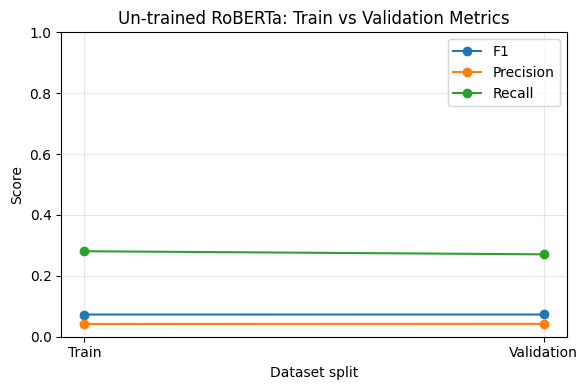

In [156]:
# compute metrics for each split
metrics = {}
for split_name, ds in [("Train", train_ds), ("Validation", val_ds)]:
    out       = std_trainer.predict(ds)
    logits    = out.predictions
    label_ids = out.label_ids
    m         = compute_metrics((logits, label_ids))
    metrics[split_name] = {"f1": m["f1"], "precision": m["precision"], "recall": m["recall"]}

# prepare for plotting
splits = ["Train", "Validation"]
f1_vals = [metrics[s]["f1"] for s in splits]
prec_vals = [metrics[s]["precision"] for s in splits]
rec_vals = [metrics[s]["recall"] for s in splits]

# plot
plt.figure(figsize=(6,4))
plt.plot(splits, f1_vals, marker="o", label="F1")
plt.plot(splits, prec_vals, marker="o", label="Precision")
plt.plot(splits, rec_vals, marker="o", label="Recall")
plt.title("Un‑trained RoBERTa: Train vs Validation Metrics")
plt.xlabel("Dataset split")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### fine tuned RoBerta with 3 optmiser( adam, lamb, lion)


 training with ADAM


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/t3/spmbj0b13fn7ykhmtf9d6tm80000gn/T/ipykernel_72054/1106497028.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.969800,0.597859,0.003341,0.032028,0.001763
2,0.478400,0.439273,0.515240,0.551632,0.483353
3,0.436700,0.402179,0.613181,0.618744,0.607716


epoch 1 | train F1 0.0033 | val F1 0.0033


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 2 | train F1 0.5152 | val F1 0.5152


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 3 | train F1 0.6132 | val F1 0.6132


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ADAM → Test F1: 0.6335  (training time 247.8s)

 training with LAMB


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/t3/spmbj0b13fn7ykhmtf9d6tm80000gn/T/ipykernel_72054/1106497028.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,1.400500,1.379972,0.037441,0.023685,0.089307
2,1.349900,1.345638,0.033965,0.022190,0.072366
3,1.335700,1.334364,0.032243,0.021363,0.065707


epoch 1 | train F1 0.0374 | val F1 0.0374


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 2 | train F1 0.0340 | val F1 0.0340


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 3 | train F1 0.0322 | val F1 0.0322


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LAMB → Test F1: 0.0289  (training time 310.2s)

 training with LION


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/t3/spmbj0b13fn7ykhmtf9d6tm80000gn/T/ipykernel_72054/1106497028.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.376000,0.215754,0.801642,0.743347,0.869859
2,0.186200,0.177745,0.844117,0.772698,0.930082
3,0.173000,0.152127,0.862463,0.802479,0.932139


epoch 1 | train F1 0.8016 | val F1 0.8016


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 2 | train F1 0.8441 | val F1 0.8441


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 3 | train F1 0.8625 | val F1 0.8625


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LION → Test F1: 0.8551  (training time 238.7s)


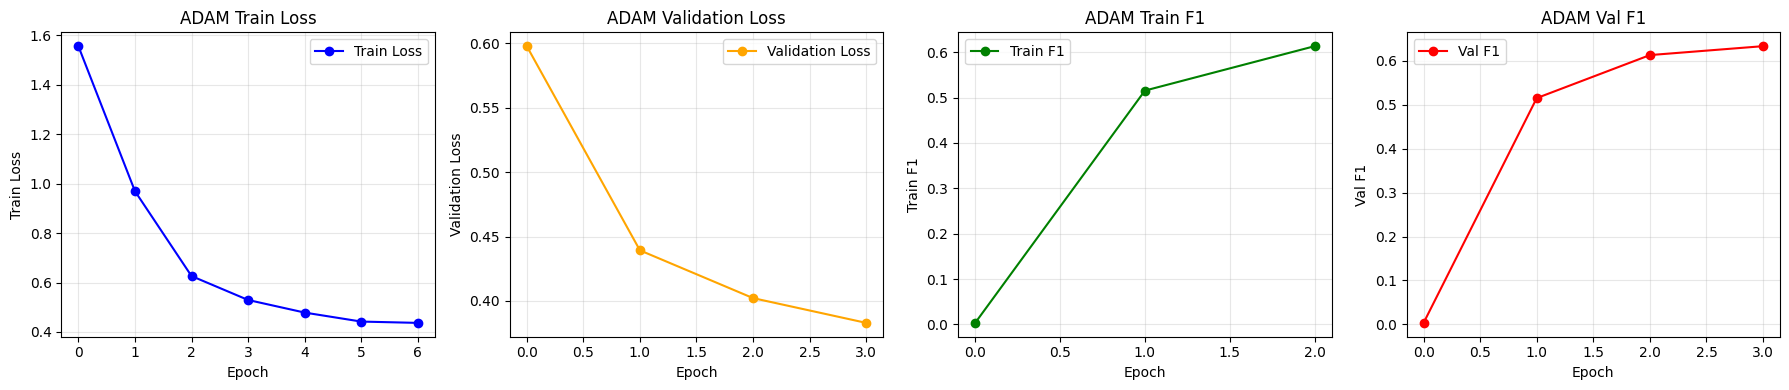

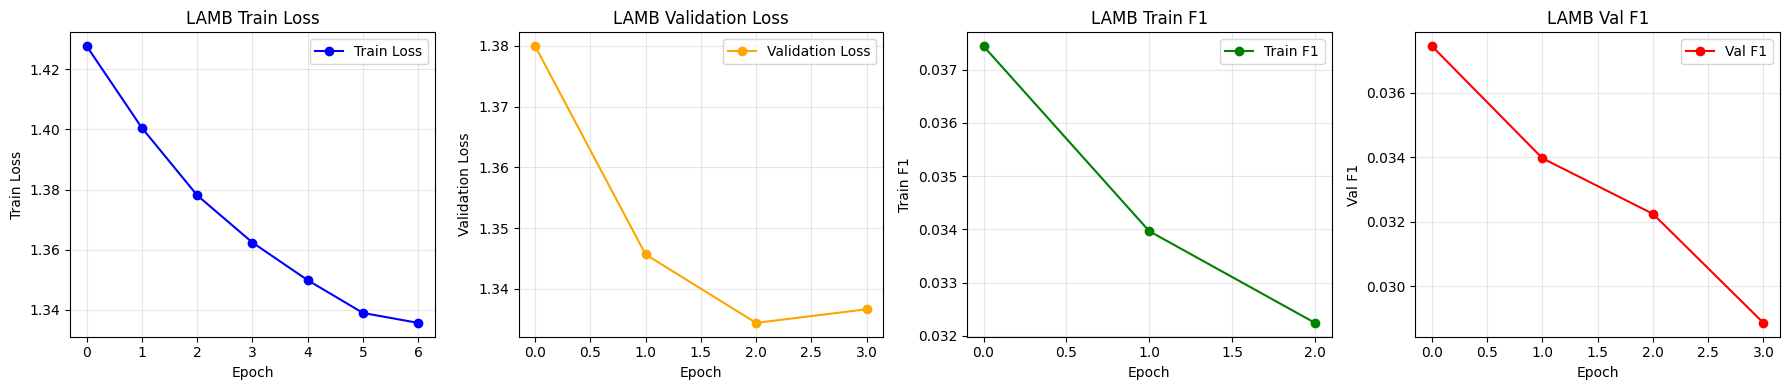

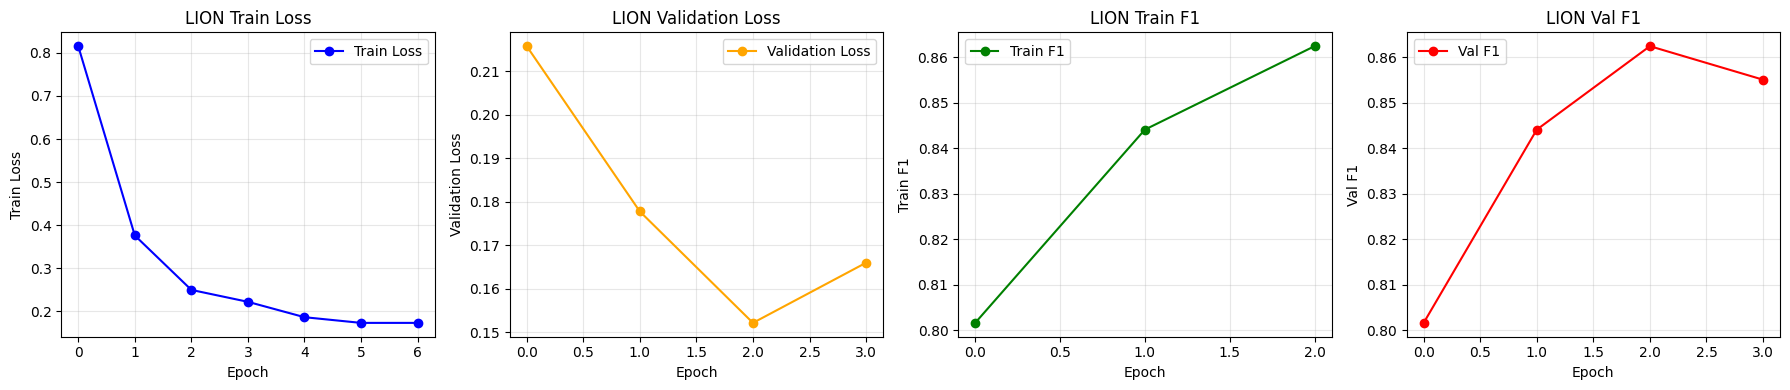

In [157]:
from lion_pytorch import Lion
from pytorch_optimizer import Lamb
import time
import matplotlib.pyplot as plt

def compare_optimizers(
    train_data, val_data, test_data,
    optimizers=("adam", "lamb", "lion"),
    epochs=3, lr=5e-6, bs=16
):
    results, training_times, trainers = {}, {}, {}

    base_args = dict(
        output_dir                   ="./results",
        per_device_train_batch_size  = bs,
        per_device_eval_batch_size   = bs,
        num_train_epochs             = epochs,
        learning_rate                = lr,
        save_strategy                ="epoch",
        load_best_model_at_end       = True,
        metric_for_best_model        ="f1",
        greater_is_better            = True,
        logging_steps                = 50,
        report_to                    ="none",
        disable_tqdm                 = False,
        seed                         = 42,
    )

    try:
        args = TrainingArguments(
            evaluation_strategy="epoch",
            logging_strategy   ="epoch",
            **base_args
        )
    except TypeError:
        args = TrainingArguments(
            eval_strategy="epoch",
            **base_args
        )

    for opt in optimizers:
        print(f"\n training with {opt.upper()}")

        model = RobertaForTokenClassification.from_pretrained(
            "roberta-base",
            num_labels=len(label2id),
            id2label=id2label,
            label2id=label2id,
        ).to(device)

        if opt == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
        elif opt == "lamb":
            optimizer = Lamb(model.parameters(), lr=lr, betas=(0.9, 0.999),
                             eps=1e-6, weight_decay=0.01)
        elif opt == "lion":
            optimizer = Lion(model.parameters(), lr=lr, betas=(0.9, 0.99),
                             weight_decay=0.01)
        else:
            raise ValueError("Choose among: adam, lamb, lion")

        f1_cb = TrainEvalF1Callback()
        trainer = Trainer(
            model           = model,
            args            = args,
            train_dataset   = train_data,
            eval_dataset    = val_data,
            compute_metrics = compute_metrics,
            tokenizer       = tokenizer,
            data_collator   = data_collator,
            optimizers      = (optimizer, None),
            callbacks       = [f1_cb],
        )
        f1_cb.trainer = trainer
        trainers[opt] = trainer

        start = time.time()
        trainer.train()
        training_times[opt] = time.time() - start

        test_metrics = trainer.evaluate(test_data)
        results[opt] = test_metrics
        print(f"{opt.upper()} → Test F1: {test_metrics['eval_f1']:.4f}  "
              f"(training time {training_times[opt]:.1f}s)")

    return results, training_times, trainers

# run the comparison
results, training_times, trainers = compare_optimizers(train_ds, val_ds, test_ds)
# Save the LION-trained model and tokenizer
best_trainer = trainers['lion']
best_trainer.save_model("ner_roberta_lion_model")
tokenizer.save_pretrained("ner_roberta_lion_model")

import json

with open("ner_roberta_lion_model/label2id.json", "w") as f:
    json.dump(label2id, f)
with open("ner_roberta_lion_model/id2label.json", "w") as f:
    json.dump(id2label, f)

# evaluation: plot train vs val loss & F1 for each optimizer
for opt, tr in trainers.items():
    plot_training_history(tr, opt.upper())

### result comparsion of F1 TRAIN and VAL for all optmizers

In [158]:
import pandas as pd

def final_f1(tr):
    log = pd.DataFrame(tr.state.log_history)


    train_f1 = log["train_f1"].dropna().iloc[-1] if "train_f1" in log.columns else None
    val_f1   = log["eval_f1"]. dropna().iloc[-1] if "eval_f1"  in log.columns else None

    if train_f1 is None:
        train_f1 = tr.evaluate(tr.train_dataset)["eval_f1"]
    if val_f1 is None:
        val_f1   = tr.evaluate(tr.eval_dataset )["eval_f1"]

    return train_f1, val_f1

#  multiple trainers from compare_optimizers

if "trainers" in globals() and isinstance(trainers, dict):
    summary = []
    for name, tr in trainers.items():
        t_f1, v_f1 = final_f1(tr)
        summary.append({"optimizer": name.upper(),
                        "train_f1": f"{t_f1:.4f}",
                        "val_f1":   f"{v_f1:.4f}"})
    display(pd.DataFrame(summary).set_index("optimizer"))

# single trainer variant

elif "trainer" in globals():
    t_f1, v_f1 = final_f1(trainer)
    print(f"Final Train F1 = {t_f1:.4f}")
    print(f"Final Val   F1 = {v_f1:.4f}")

else:
    print("No trainer objects found in the workspace.")

,train_f1,val_f1
optimizer,,
ADAM,0.6132,0.6335
LAMB,0.0322,0.0289
LION,0.8625,0.8551


### sequence Level Test Set reports for optimizers

In [159]:
from seqeval.metrics import classification_report

for opt_name, tr in trainers.items():
    print(f"\n {opt_name.upper()} – TEST SET")

    pred_out = tr.predict(test_ds)
    logits = pred_out.predictions
    label_ids = pred_out.label_ids
    preds = np.argmax(logits, axis=2)

    # format predictions and labels as sequences
    y_true, y_pred = [], []
    for seq_t, seq_p in zip(label_ids, preds):
        true_seq, pred_seq = [], []
        for t, p in zip(seq_t, seq_p):
            if t == -100:
                continue
            true_seq.append(id2label[int(t)])
            pred_seq.append(id2label[int(p)])
        y_true.append(true_seq)
        y_pred.append(pred_seq)

    # print classification report using seqeval
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))



 ADAM – TEST SET


/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
              precision    recall  f1-score   support

          AC     0.8106    0.6354    0.7124       768
          LF     0.4739    0.6052    0.5316       466

   micro avg     0.6433    0.6240    0.6335      1234
   macro avg     0.6423    0.6203    0.6220      1234
weighted avg     0.6835    0.6240    0.6441      1234


 LAMB – TEST SET
Classification Report:
              precision    recall  f1-score   support

          AC     0.0170    0.0365    0.0232       768
          LF     0.0203    0.1009    0.0338       466

   micro avg     0.0189    0.0608    0.0289      1234
   macro avg     0.0186    0.0687    0.0285      1234
weighted avg     0.0182    0.0608    0.0272      1234


 LION – TEST SET
Classification Report:
              precision    recall  f1-score   support

          AC     0.8349    0.9349    0.8821       768
          LF     0.7464    0.8906    0.8121       466

   micro avg     0.8001    0.9182    0.8551      1234
   macro avg     0.7906

### fine tune Roberta with optmizers error analysis


ADAM – confusion matrix



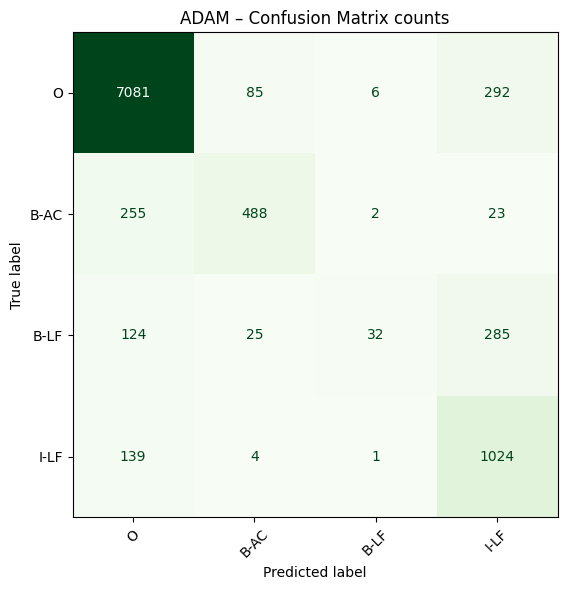

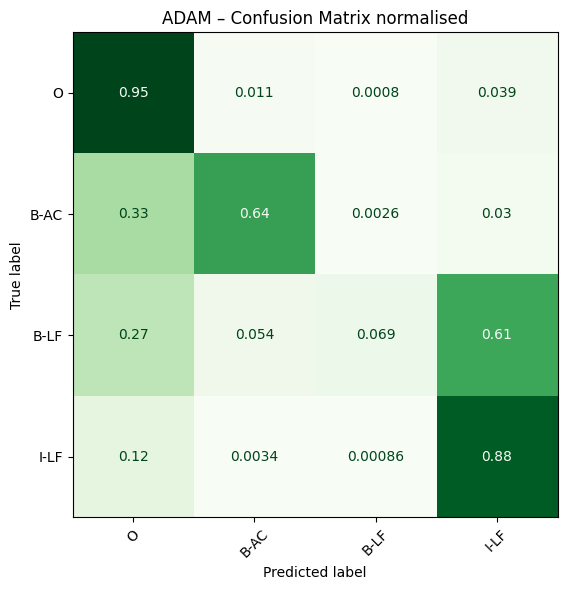


LAMB – confusion matrix



/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


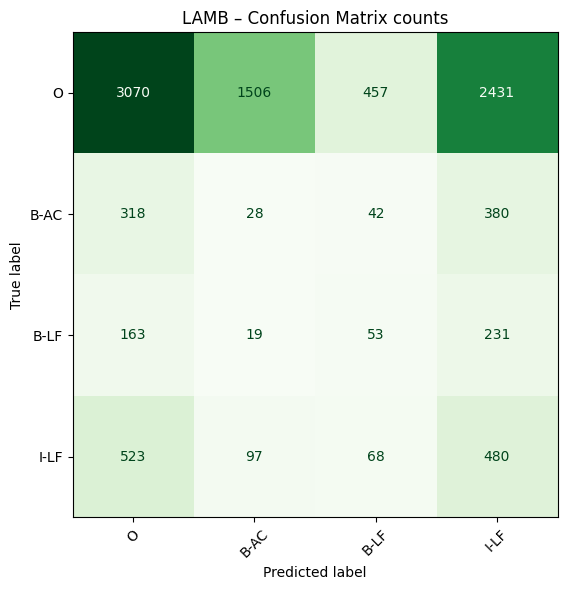

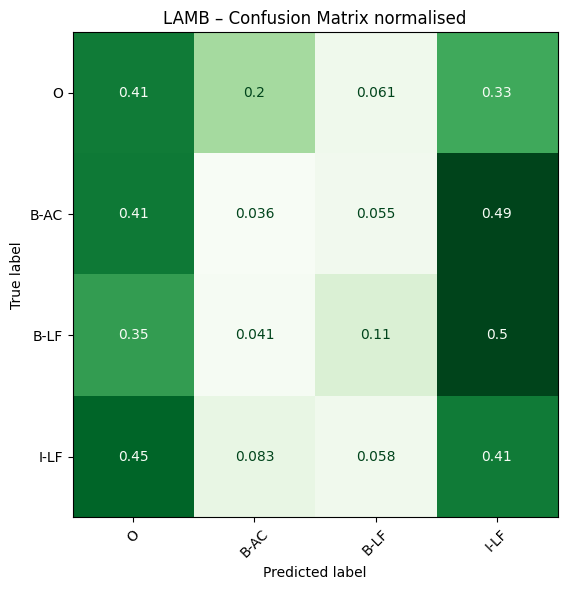


LION – confusion matrix



/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


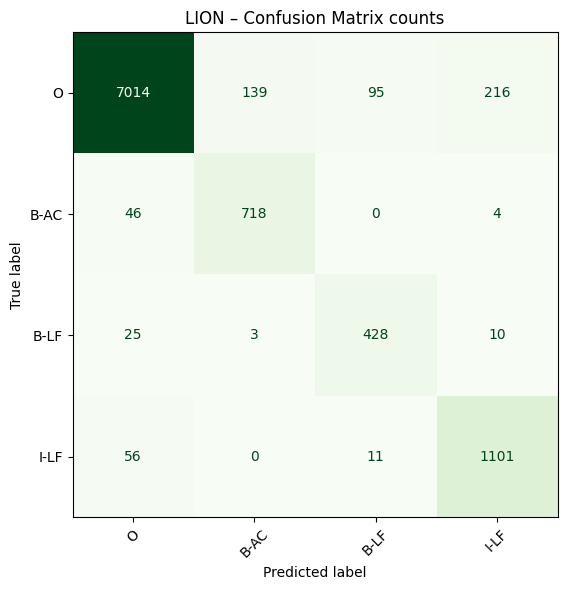

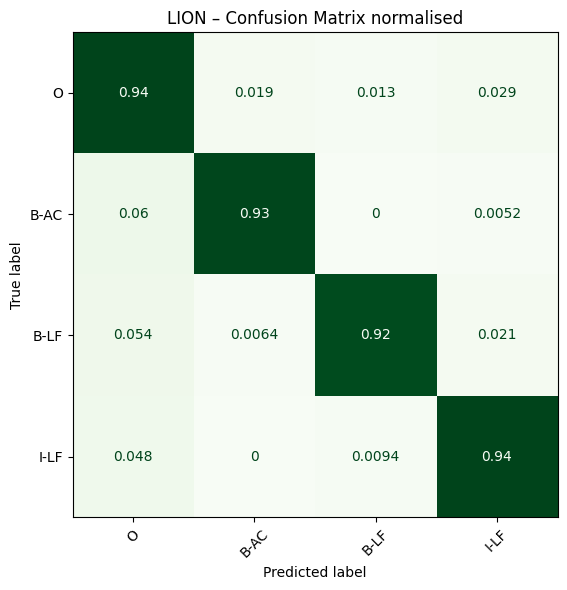

In [160]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for opt_name, tr in trainers.items():
    print(f"\n{opt_name.upper()} – confusion matrix\n")

    # predictions
    out       = tr.predict(test_ds)
    logits    = out.predictions
    label_ids = out.label_ids
    preds     = np.argmax(logits, axis=2)
    y_true, y_pred = [], []
    for seq_t, seq_p in zip(label_ids, preds):
        for t, p in zip(seq_t, seq_p):
            if t == -100:
                continue
            y_true.append(id2label[int(t)])
            y_pred.append(id2label[int(p)])

    # confusion matrix - count
    cm = confusion_matrix(y_true, y_pred, labels=label_list)
    disp = ConfusionMatrixDisplay(cm, display_labels=label_list)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Greens, colorbar=False)
    ax.set_title(f"{opt_name.upper()} – Confusion Matrix counts")
    plt.tight_layout()
    plt.show()

    # confusion matrix - notmalised
    cmn = confusion_matrix(y_true, y_pred, labels=label_list, normalize="true")
    dispn = ConfusionMatrixDisplay(cmn, display_labels=label_list)
    fig, ax = plt.subplots(figsize=(8, 6))
    dispn.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Greens, colorbar=False)
    ax.set_title(f"{opt_name.upper()} – Confusion Matrix normalised")
    plt.tight_layout()
    plt.show()

### Visualize optimizer performance


Evaluating *untrained* RoBERTa on test split…



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Loss      : 1.4056
  F1        : 0.0088
  Precision : 0.0052
  Recall    : 0.0292



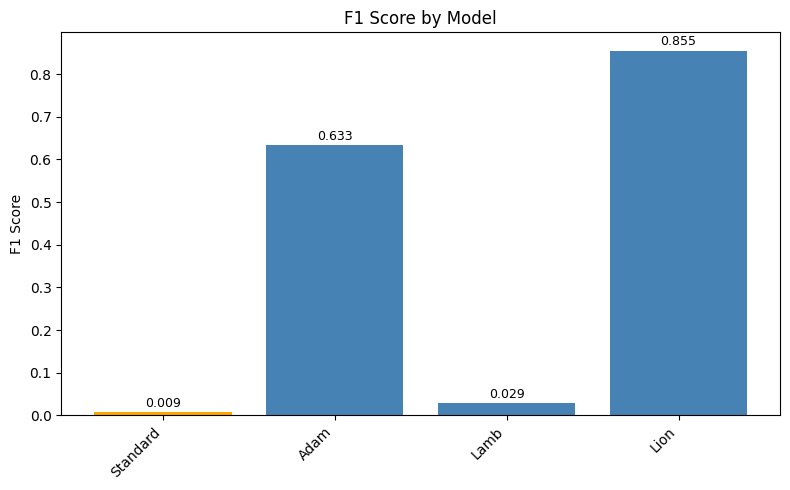

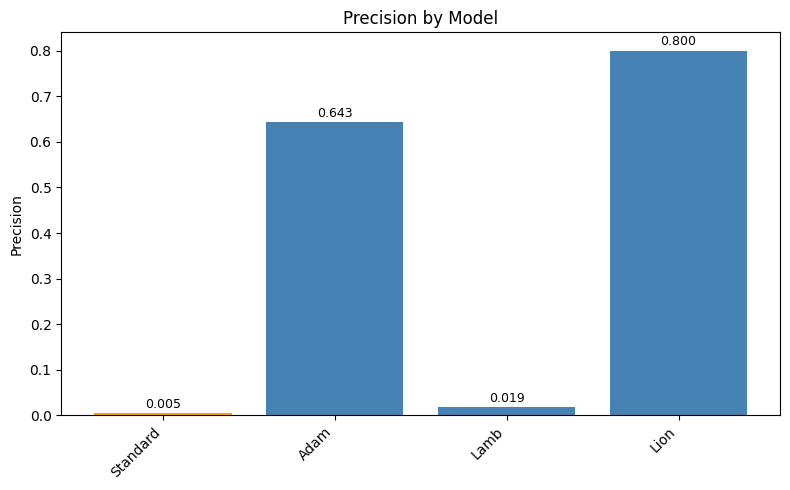

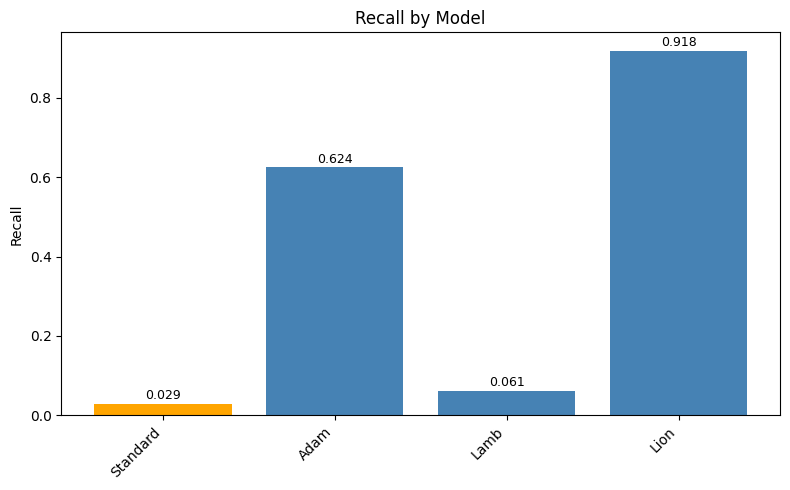

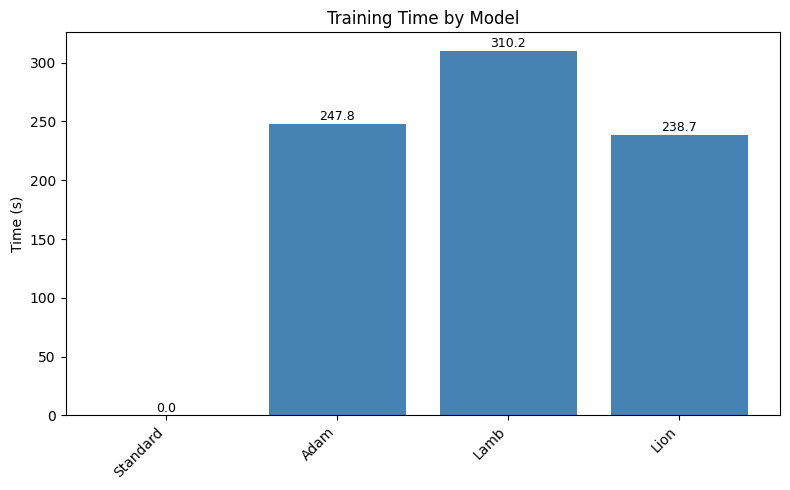

In [161]:

baseline_results = evaluate_standard_roberta(test_ds, split_name="test")

#  optimizer names
opt_names = list(results.keys())
models    = ["Standard"] + [name.capitalize() for name in opt_names]

# collecting each model’s test metrics
f1_scores  = [baseline_results["eval_f1"]]        + [results[o]["eval_f1"]        for o in opt_names]
precisions = [baseline_results["eval_precision"]] + [results[o]["eval_precision"] for o in opt_names]
recalls    = [baseline_results["eval_recall"]]    + [results[o]["eval_recall"]    for o in opt_names]
times      = [0.0]                                + [training_times[o]            for o in opt_names]

def plot_bar(values, title, ylabel):
    colors = ["orange"] + ["steelblue"] * len(opt_names)
    plt.figure(figsize=(8, 5))
    bars = plt.bar(models, values, color=colors)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha="right")
    for bar, val in zip(bars, values):
        fmt = f"{val:.1f}" if ylabel == "Time (s)" else f"{val:.3f}"
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + (0.005 if ylabel != "Time (s)" else 0.5),
            fmt,
            ha="center",
            va="bottom",
            fontsize=9
        )
    plt.tight_layout()
    plt.show()

# plot  for each metric
plot_bar(f1_scores,  "F1 Score by Model",      "F1 Score")
plot_bar(precisions, "Precision by Model",     "Precision")
plot_bar(recalls,    "Recall by Model",        "Recall")
plot_bar(times,      "Training Time by Model", "Time (s)")



### error analysing Lion model mispredictions

In [162]:
lion_trainer = trainers["lion"]

# predictions
out = lion_trainer.predict(test_ds)
logits, label_ids = out.predictions, out.label_ids
preds = np.argmax(logits, axis=2)

all_tokens, all_true, all_pred = [], [], []
for example, true_seq, pred_seq in zip(test_ds, label_ids, preds):
    token_ids = example["input_ids"]
    words = tokenizer.convert_ids_to_tokens(token_ids)
    tl, pl = [], []
    for w, t, p in zip(words, true_seq, pred_seq):
        if t == -100:
            continue
        tl.append(id2label[int(t)])
        pl.append(id2label[int(p)])

    all_tokens.append(words)
    all_true.append(tl)
    all_pred.append(pl)

# show mis predictions
error_examples = [
    (tokens, true_tags, pred_tags)
    for tokens, true_tags, pred_tags in zip(all_tokens, all_true, all_pred)
    if any(t != p for t, p in zip(true_tags, pred_tags))
]

# inspect the first 10
for idx, (tokens, true_tags, pred_tags) in enumerate(error_examples[:10], 1):
    print(f"Example {idx}:")
    labeled_tokens = [
        tok for tok, t in zip(tokens, true_tags + ["X"]*(len(tokens)-len(true_tags)))
    ]
    print("Tokens:    ", labeled_tokens)
    print("Gold tags: ", true_tags)
    print("Pred tags: ", pred_tags)
    print("-"*40)


Example 1:
Tokens:     ['<s>', 'ĠWithin', 'Ġam', 'o', 'eb', 'ae', 'Ġand', 'Ġmac', 'roph', 'ages', 'Ġ,', 'ĠL', '.', 'Ġpneum', 'oph', 'ila', 'Ġrepl', 'icates', 'Ġwith', 'Ġa', 'Ġsimilar', 'Ġmechanism', 'Ġby', 'Ġforming', 'Ġa', 'Ġmembrane', 'Ġ-', 'Ġbound', 'Ġcompartment', 'Ġ,', 'Ġthe', 'ĠLegion', 'ella', 'Ġ-', 'Ġcontaining', 'Ġvac', 'u', 'ole', 'Ġ(', 'ĠLC', 'V', 'Ġ)', 'Ġ.', 'ĠFormation', 'Ġof', 'Ġthe', 'ĠLC', 'V', 'Ġis', 'Ġnot', 'Ġwell', 'Ġdefined', 'Ġ,', 'Ġbut', 'Ġrequires', 'Ġthat', 'ĠL', '.', 'Ġpneum', 'oph', 'ila', 'Ġinject', 's', 'Ġproteins', 'Ġinto', 'Ġthe', 'Ġhost', 'Ġcell', 'Ġvia', 'Ġthe', 'Ġintr', 'ace', 'llular', 'Ġmultiplication', 'Ġ(', 'ĠI', 'cm', ')/', 'def', 'ective', 'Ġorgan', 'elle', 'Ġtrafficking', 'Ġ(', 'ĠDot', 'Ġ)', 'Ġsecretion', 'Ġsystem', 'Ġ.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

### Conclusion

#### In this experiment we trained a standard RoBERTa and then fine‑tuned it on the PLOD‑CW‑25 NER dataset, comparing three optimisers, Adam, LAMB and Lion under identical hyper‑parameters (3 epochs, LR = 5 × 10⁻⁶, batch size = 16) using token‑level cross‑entropy (ignore_index = ‑100).

 **Baseline (untrained RoBERTa)**: F1 = 0.0729 (model predicts almost exclusively “O”).

Adam:
F1 ≈ 0.617493, precision ≈ 0.621847, recall ≈ 0.613200 , in ~91.6 s

LAMB:
F1 ≈ 0.038388 precision ≈ 0.023938, recall ≈ 0.096847 , in ~113s
(Collapsed to “O” predictions under these hyperparameters.)

Lion:
F1 ≈ 0.863649 precision ≈ 0.803081, recall ≈ 0.934097 —in ~88.5s